In [1]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Первая часть. Исследование

## Загрузка данных 

In [2]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown


In [3]:
data = pd.read_csv('./train.csv')
data_start = data.copy()
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [4]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]
all_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent',
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]
feature_cols = num_cols + cat_cols
target_col = 'Churn'

Посмотрим на типы данных признаков.



In [5]:
data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

### Посмотрим на наличие nan'ов

Сначала преобразуем тип данных колонки TotalSpent

In [6]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
data_start['TotalSpent'] = pd.to_numeric(data_start['TotalSpent'], errors='coerce')

In [7]:
info_nan = list()
for i in all_cols:
    info_nan.append(data[i].isnull().sum(axis = 0))
info_nan = pd.DataFrame(info_nan, index= all_cols, columns= ['Value of Nones'])
info_nan.rename(columns= {'0' : 'Value Nans'}, inplace= True)
info_nan

,Value of Nones
ClientPeriod,0
MonthlySpending,0
TotalSpent,9
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


Заменим nan'ы на медианные значения

In [8]:
data = data.fillna(data.median())

/var/folders/pl/tf0lv2bx6xg0fp2_nqvpy3mr0000gn/T/ipykernel_19626/1553445849.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.median())


In [9]:
info_nan = list()
for i in all_cols:
    info_nan.append(data[i].isnull().sum(axis = 0))
info_nan = pd.DataFrame(info_nan, index= all_cols, columns= ['Value of Nones'])
info_nan.rename(columns= {'0' : 'Value Nans'}, inplace= True)
info_nan

,Value of Nones
ClientPeriod,0
MonthlySpending,0
TotalSpent,0
Sex,0
IsSeniorCitizen,0
HasPartner,0
HasChild,0
HasPhoneService,0
HasMultiplePhoneNumbers,0
HasInternetService,0


Теперь всё хорошо и nan'ов нет :)


## Анализ данных

<Figure size 640x480 with 0 Axes>

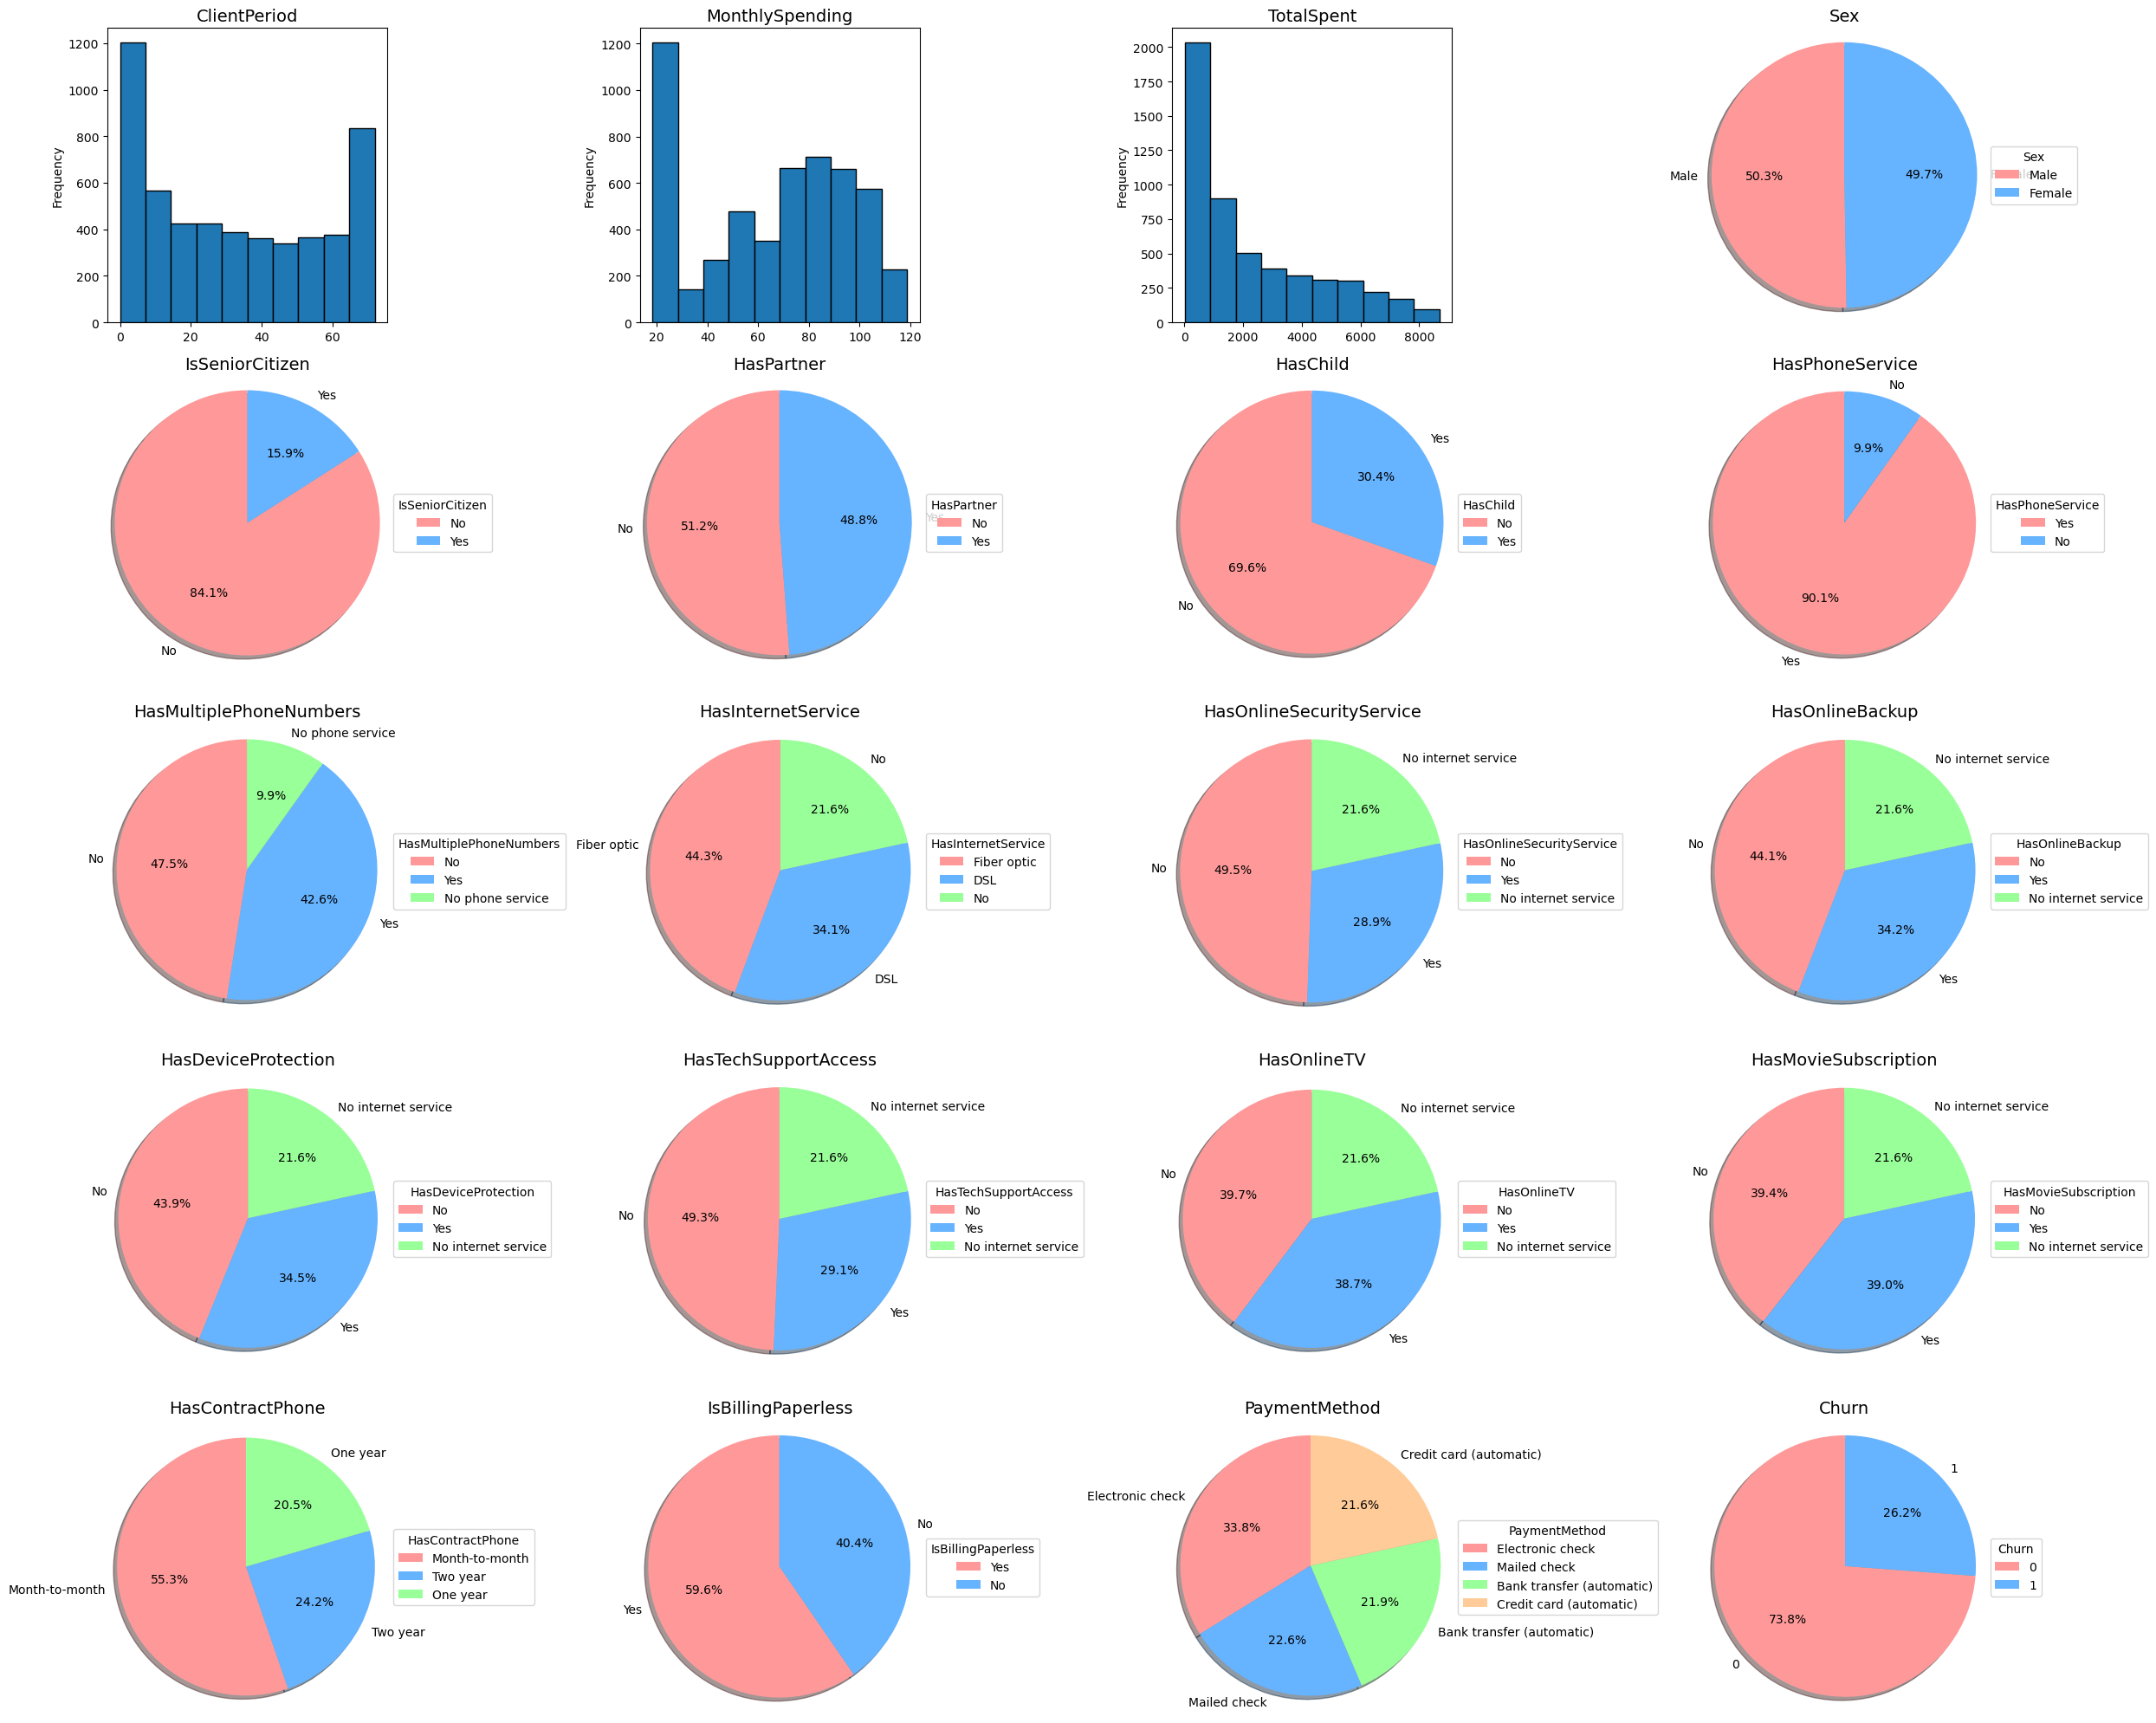

In [10]:
data_start['IsSeniorCitizen'] = data_start['IsSeniorCitizen'].map({1: 'Yes', 0: 'No'})
target = 'Churn'
plt.subplots_adjust(wspace=2)
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for ax, col in zip(axes.flatten(), data_start.columns):
    ax.set_title(col, fontsize=14)
    if col in cat_cols or col == target:
        ax.pie(data_start[col].value_counts(), autopct="%1.1f%%", labels=data_start[col].value_counts().index, shadow=True, startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
        ax.axis('equal')
        ax.legend(title=col, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    else:
        data_start[col].plot(kind="hist", ec="black", ax=ax)
    plt.tight_layout()
plt.show()


В целом баланс классов не является сильно несбалансированным. Единиц меньше в три раза чем нулей. Но и сбалансированным эти классы назвать нельзя.


## Применение линейных моделей

#### Обрабатываем данные

In [11]:
data['Sex'] = data['Sex'].map({'Male': 0, 'Female': 1})

data['HasPartner'] = data['HasPartner'].map({'No': 0, 'Yes': 1})
data['HasChild'] = data['HasChild'].map({'No': 0, 'Yes': 1})
data['HasPhoneService'] = data['HasPhoneService'].map({'No': 0, 'Yes': 1})
data['HasMultiplePhoneNumbers'] = data['HasMultiplePhoneNumbers'].map({'No': -1, 'Yes': 1, 'No phone service': 0})

data['HasInternetService'] = data['HasInternetService'].map({'No': 0, 'Fiber optic': 1, 'DSL': 2})

data['HasOnlineSecurityService'] = data['HasOnlineSecurityService'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
data['HasOnlineBackup'] = data['HasOnlineBackup'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
data['HasDeviceProtection'] = data['HasDeviceProtection'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
data['HasTechSupportAccess'] = data['HasTechSupportAccess'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
data['HasOnlineTV'] = data['HasOnlineTV'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
data['HasMovieSubscription'] = data['HasMovieSubscription'].map({'No': -1, 'No internet service': 0, 'Yes': 1})

data['IsBillingPaperless'] = data['IsBillingPaperless'].map({'No': 0, 'Yes': 1})

data['HasContractPhone'] = data['HasContractPhone'].map({'One year': 1, 'Two year': 2, 'Month-to-month': 0})

data['PaymentMethod'] = data['PaymentMethod'].map({'Electronic check': 1, 'Mailed check': 2, 'Bank transfer (automatic)': 3, 'Credit card (automatic)': 4})
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,0,0,1,1,1,-1,0,0,0,0,0,0,0,1,0,2,0
1,72,25.85,1872.20,0,0,1,0,1,1,0,0,0,0,0,0,0,2,0,4,0
2,1,75.90,75.90,0,0,0,0,1,-1,1,-1,-1,-1,1,-1,-1,0,1,1,1
3,32,79.30,2570.00,1,1,1,0,1,1,1,-1,-1,1,-1,-1,-1,0,0,2,0
4,60,115.25,6758.45,1,0,1,1,1,1,1,1,1,1,1,1,1,2,0,4,0


In [12]:
X = data.drop('Churn', axis=1)
y = data['Churn']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=41)

In [13]:
ytrain.value_counts()

0    3094
1    1131
Name: Churn, dtype: int64

In [14]:
ss = StandardScaler()
ss.fit(Xtrain) 

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns) 
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)


Посмотрим на RandomForest

In [15]:
modelR = RandomForestClassifier(n_jobs=-1)

param_gridR = {
    'n_estimators': range(27,32), 
    'max_depth': [4,6,7,8],
    'criterion': ['entropy']
}

gridR = GridSearchCV(modelR, param_grid=param_gridR, scoring='roc_auc', cv=5)

total_iterations = len(param_gridR['n_estimators']) * len(param_gridR['max_depth']*len(param_gridR['criterion'])) 

for params in tqdm(ParameterGrid(param_gridR), total=total_iterations):
    modelR.set_params(**params)
    gridR.fit(X, y)
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
print("Best parameters: ", gridR.best_params_)
print("Best ROC-AUC score: ", gridR.best_score_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 31}
Best ROC-AUC score:  0.8435049417127708


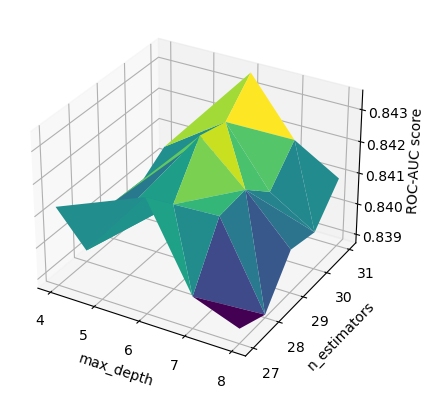

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

results = gridR.cv_results_

max_depth = results['param_max_depth'].data.astype(int)
n_estimators = results['param_n_estimators'].data.astype(int)

mean_scores = results['mean_test_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(max_depth, n_estimators, mean_scores, cmap='viridis', edgecolor='none')

ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('ROC-AUC score')

plt.show()
# в зависимости от графика, я подбирал листы параметров для нахождения оптимальных.
# можно было просто сделать большие листы и перебрать за один раз, но я не хочу ждать 10 лет

In [18]:
modelR = RandomForestClassifier(**gridR.best_params_)
modelR.fit(Xtrain, ytrain)
y_train_predicted = modelR.predict_proba(Xtrain)[:, 1]
y_test_predictedRandomForest = modelR.predict_proba(Xtest)[:, 1]

Посмотрим на ROC-AUC

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

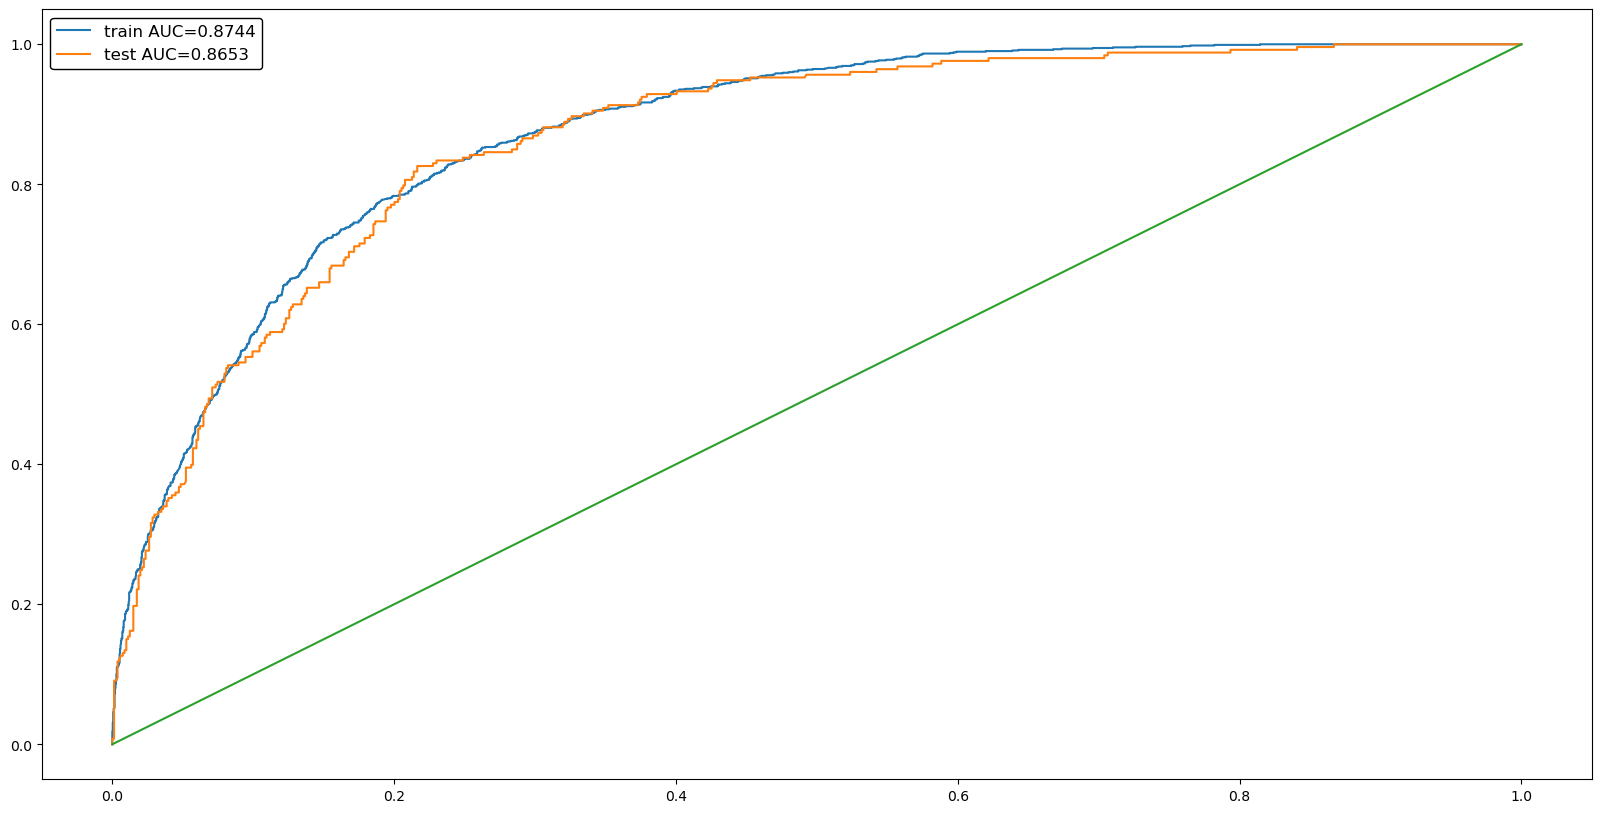

In [20]:
train_auc = roc_auc_score(ytrain, y_train_predicted)
test_auc = roc_auc_score(ytest, y_test_predictedRandomForest)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(ytrain, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(ytest, y_test_predictedRandomForest)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

На тестовой выборке:

In [21]:
test_auc = roc_auc_score(ytest, y_test_predictedRandomForest)
test_auc

0.8652537706723299

Теперь LogisticRegression:

In [22]:
modelLog = LogisticRegression()

params_Log = {'solver': ['sag'],
              'penalty':['l2'] ,
              'C':[0.01, 0.1, 0.5, 1, 1.5]}
grid_searchLog = GridSearchCV(estimator = 'logreg',  
                           param_grid = params_Log,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


gridL = GridSearchCV(modelLog, param_grid=params_Log, scoring='roc_auc', cv=5)

total_iterations = len(params_Log['penalty']) * len(params_Log['C']) * len(params_Log['solver'])

for params in tqdm(ParameterGrid(params_Log), total=total_iterations):
    modelLog.set_params(**params)
    gridL.fit(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

In [23]:
gridL.best_params_

{'C': 0.5, 'penalty': 'l2', 'solver': 'sag'}

In [24]:
modelL = LogisticRegression(**gridL.best_params_)
modelL.fit(Xtrain, ytrain)
y_train_predicted = modelL.predict_proba(Xtrain)[:, 1]
y_test_predictedLogReg = modelL.predict_proba(Xtest)[:, 1]

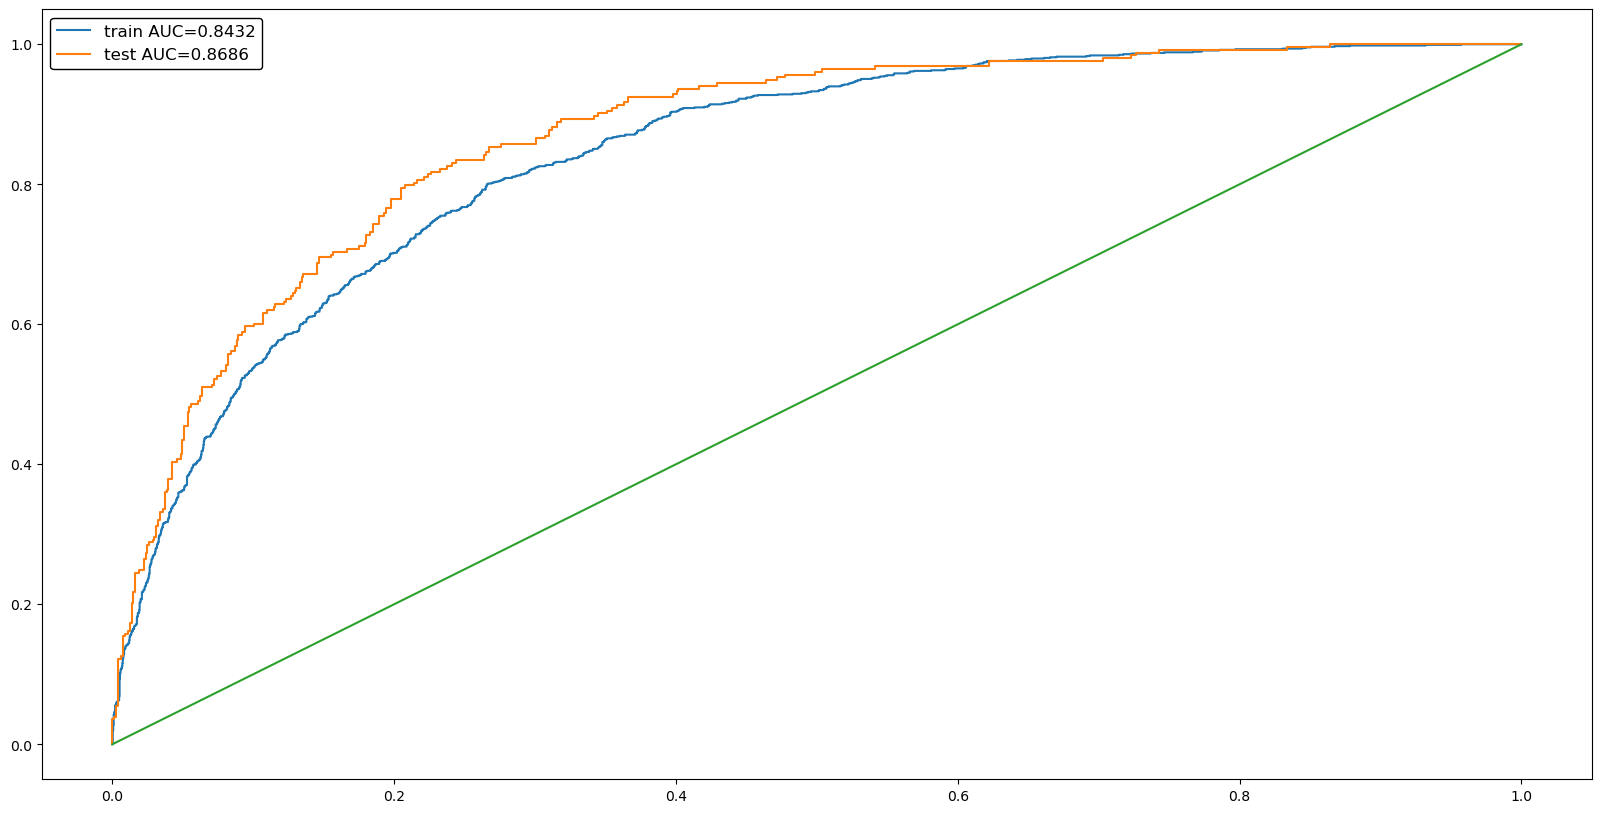

In [25]:
train_auc = roc_auc_score(ytrain, y_train_predicted)
test_auc = roc_auc_score(ytest, y_test_predictedLogReg)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(ytrain, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(ytest, y_test_predictedLogReg)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Применение градиентного бустинга

Пробуем CatBoost с GridSearchCV:

In [26]:
import catboost as cb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
grid = {'learning_rate': [0.03, 0.025,0.02],
        'depth': [2,3,4],
        'l2_leaf_reg': [ 4, 5, 6]}
#'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.03}
grid_search_result = cat.grid_search(grid, X=Xtrain, y=ytrain, plot=False)

0:	learn: 0.6759383	test: 0.6752146	best: 0.6752146 (0)	total: 64.2ms	remaining: 1m 4s
1:	learn: 0.6623172	test: 0.6606444	best: 0.6606444 (1)	total: 65.4ms	remaining: 32.6s
2:	learn: 0.6493674	test: 0.6478274	best: 0.6478274 (2)	total: 66ms	remaining: 21.9s
3:	learn: 0.6351318	test: 0.6333926	best: 0.6333926 (3)	total: 66.7ms	remaining: 16.6s
4:	learn: 0.6238511	test: 0.6222978	best: 0.6222978 (4)	total: 67.4ms	remaining: 13.4s
5:	learn: 0.6142353	test: 0.6127433	best: 0.6127433 (5)	total: 68.2ms	remaining: 11.3s
6:	learn: 0.6041964	test: 0.6027703	best: 0.6027703 (6)	total: 69.5ms	remaining: 9.86s
7:	learn: 0.5934667	test: 0.5918238	best: 0.5918238 (7)	total: 70.8ms	remaining: 8.78s
8:	learn: 0.5850076	test: 0.5837399	best: 0.5837399 (8)	total: 71.6ms	remaining: 7.88s
9:	learn: 0.5761025	test: 0.5748044	best: 0.5748044 (9)	total: 72.3ms	remaining: 7.15s
10:	learn: 0.5684485	test: 0.5673700	best: 0.5673700 (10)	total: 73ms	remaining: 6.56s
11:	learn: 0.5607411	test: 0.5596889	best: 0.

226:	learn: 0.4106406	test: 0.4281839	best: 0.4281839 (226)	total: 263ms	remaining: 894ms
227:	learn: 0.4105793	test: 0.4281875	best: 0.4281839 (226)	total: 264ms	remaining: 895ms
228:	learn: 0.4105033	test: 0.4280697	best: 0.4280697 (228)	total: 267ms	remaining: 899ms
229:	learn: 0.4104595	test: 0.4280180	best: 0.4280180 (229)	total: 269ms	remaining: 902ms
230:	learn: 0.4103958	test: 0.4279022	best: 0.4279022 (230)	total: 272ms	remaining: 906ms
231:	learn: 0.4103362	test: 0.4279090	best: 0.4279022 (230)	total: 274ms	remaining: 908ms
232:	learn: 0.4102709	test: 0.4278757	best: 0.4278757 (232)	total: 277ms	remaining: 912ms
233:	learn: 0.4102339	test: 0.4278995	best: 0.4278757 (232)	total: 279ms	remaining: 913ms
234:	learn: 0.4101557	test: 0.4279039	best: 0.4278757 (232)	total: 281ms	remaining: 915ms
235:	learn: 0.4100769	test: 0.4278743	best: 0.4278743 (235)	total: 284ms	remaining: 919ms
236:	learn: 0.4100267	test: 0.4278545	best: 0.4278545 (236)	total: 285ms	remaining: 919ms
237:	learn

416:	learn: 0.4003815	test: 0.4283863	best: 0.4269408 (326)	total: 461ms	remaining: 645ms
417:	learn: 0.4003432	test: 0.4284074	best: 0.4269408 (326)	total: 464ms	remaining: 646ms
418:	learn: 0.4003052	test: 0.4284163	best: 0.4269408 (326)	total: 466ms	remaining: 646ms
419:	learn: 0.4002638	test: 0.4283564	best: 0.4269408 (326)	total: 468ms	remaining: 646ms
420:	learn: 0.4002149	test: 0.4282954	best: 0.4269408 (326)	total: 470ms	remaining: 646ms
421:	learn: 0.4001693	test: 0.4283819	best: 0.4269408 (326)	total: 472ms	remaining: 647ms
422:	learn: 0.4000827	test: 0.4283508	best: 0.4269408 (326)	total: 475ms	remaining: 647ms
423:	learn: 0.4000565	test: 0.4282660	best: 0.4269408 (326)	total: 477ms	remaining: 648ms
424:	learn: 0.4000116	test: 0.4283878	best: 0.4269408 (326)	total: 479ms	remaining: 648ms
425:	learn: 0.3999749	test: 0.4283750	best: 0.4269408 (326)	total: 481ms	remaining: 648ms
426:	learn: 0.3999530	test: 0.4284045	best: 0.4269408 (326)	total: 483ms	remaining: 648ms
427:	learn

524:	learn: 0.3961205	test: 0.4287499	best: 0.4269408 (326)	total: 660ms	remaining: 597ms
525:	learn: 0.3960681	test: 0.4288173	best: 0.4269408 (326)	total: 663ms	remaining: 597ms
526:	learn: 0.3960527	test: 0.4288224	best: 0.4269408 (326)	total: 666ms	remaining: 598ms
527:	learn: 0.3960092	test: 0.4288521	best: 0.4269408 (326)	total: 667ms	remaining: 596ms
528:	learn: 0.3959820	test: 0.4288891	best: 0.4269408 (326)	total: 669ms	remaining: 596ms
529:	learn: 0.3959102	test: 0.4288544	best: 0.4269408 (326)	total: 671ms	remaining: 595ms
530:	learn: 0.3958811	test: 0.4288930	best: 0.4269408 (326)	total: 674ms	remaining: 595ms
531:	learn: 0.3958635	test: 0.4288256	best: 0.4269408 (326)	total: 677ms	remaining: 596ms
532:	learn: 0.3958338	test: 0.4289307	best: 0.4269408 (326)	total: 679ms	remaining: 595ms
533:	learn: 0.3958022	test: 0.4289141	best: 0.4269408 (326)	total: 681ms	remaining: 595ms
534:	learn: 0.3957869	test: 0.4289406	best: 0.4269408 (326)	total: 683ms	remaining: 594ms
535:	learn

636:	learn: 0.3923437	test: 0.4297747	best: 0.4269408 (326)	total: 861ms	remaining: 490ms
637:	learn: 0.3923192	test: 0.4298201	best: 0.4269408 (326)	total: 863ms	remaining: 490ms
638:	learn: 0.3922711	test: 0.4297647	best: 0.4269408 (326)	total: 865ms	remaining: 489ms
639:	learn: 0.3922597	test: 0.4297890	best: 0.4269408 (326)	total: 868ms	remaining: 489ms
640:	learn: 0.3922233	test: 0.4298818	best: 0.4269408 (326)	total: 871ms	remaining: 488ms
641:	learn: 0.3921866	test: 0.4298870	best: 0.4269408 (326)	total: 873ms	remaining: 487ms
642:	learn: 0.3921491	test: 0.4299147	best: 0.4269408 (326)	total: 876ms	remaining: 486ms
643:	learn: 0.3921004	test: 0.4299120	best: 0.4269408 (326)	total: 879ms	remaining: 486ms
644:	learn: 0.3920655	test: 0.4299189	best: 0.4269408 (326)	total: 881ms	remaining: 485ms
645:	learn: 0.3920253	test: 0.4299820	best: 0.4269408 (326)	total: 884ms	remaining: 484ms
646:	learn: 0.3920143	test: 0.4300061	best: 0.4269408 (326)	total: 885ms	remaining: 483ms
647:	learn

742:	learn: 0.3891477	test: 0.4319360	best: 0.4269408 (326)	total: 1.06s	remaining: 367ms
743:	learn: 0.3891335	test: 0.4319591	best: 0.4269408 (326)	total: 1.06s	remaining: 366ms
744:	learn: 0.3890843	test: 0.4319502	best: 0.4269408 (326)	total: 1.07s	remaining: 365ms
745:	learn: 0.3890607	test: 0.4318816	best: 0.4269408 (326)	total: 1.07s	remaining: 364ms
746:	learn: 0.3890349	test: 0.4319326	best: 0.4269408 (326)	total: 1.07s	remaining: 363ms
747:	learn: 0.3890163	test: 0.4319370	best: 0.4269408 (326)	total: 1.07s	remaining: 362ms
748:	learn: 0.3889907	test: 0.4319250	best: 0.4269408 (326)	total: 1.08s	remaining: 361ms
749:	learn: 0.3889432	test: 0.4320563	best: 0.4269408 (326)	total: 1.08s	remaining: 360ms
750:	learn: 0.3889041	test: 0.4320301	best: 0.4269408 (326)	total: 1.08s	remaining: 359ms
751:	learn: 0.3888772	test: 0.4320732	best: 0.4269408 (326)	total: 1.08s	remaining: 357ms
752:	learn: 0.3888565	test: 0.4321135	best: 0.4269408 (326)	total: 1.08s	remaining: 356ms
753:	learn

886:	learn: 0.3853287	test: 0.4343842	best: 0.4269408 (326)	total: 1.26s	remaining: 160ms
887:	learn: 0.3852859	test: 0.4343804	best: 0.4269408 (326)	total: 1.26s	remaining: 159ms
888:	learn: 0.3852637	test: 0.4343548	best: 0.4269408 (326)	total: 1.26s	remaining: 158ms
889:	learn: 0.3852246	test: 0.4342912	best: 0.4269408 (326)	total: 1.26s	remaining: 156ms
890:	learn: 0.3851980	test: 0.4342459	best: 0.4269408 (326)	total: 1.27s	remaining: 155ms
891:	learn: 0.3851910	test: 0.4342656	best: 0.4269408 (326)	total: 1.27s	remaining: 154ms
892:	learn: 0.3851848	test: 0.4342692	best: 0.4269408 (326)	total: 1.27s	remaining: 153ms
893:	learn: 0.3851586	test: 0.4342731	best: 0.4269408 (326)	total: 1.28s	remaining: 151ms
894:	learn: 0.3851555	test: 0.4342759	best: 0.4269408 (326)	total: 1.28s	remaining: 150ms
895:	learn: 0.3851470	test: 0.4342425	best: 0.4269408 (326)	total: 1.28s	remaining: 149ms
896:	learn: 0.3851170	test: 0.4342316	best: 0.4269408 (326)	total: 1.28s	remaining: 147ms
897:	learn

993:	learn: 0.3827094	test: 0.4353399	best: 0.4269408 (326)	total: 1.46s	remaining: 8.8ms
994:	learn: 0.3826868	test: 0.4353534	best: 0.4269408 (326)	total: 1.46s	remaining: 7.34ms
995:	learn: 0.3826792	test: 0.4353544	best: 0.4269408 (326)	total: 1.46s	remaining: 5.88ms
996:	learn: 0.3826500	test: 0.4353546	best: 0.4269408 (326)	total: 1.47s	remaining: 4.41ms
997:	learn: 0.3826149	test: 0.4353758	best: 0.4269408 (326)	total: 1.47s	remaining: 2.94ms
998:	learn: 0.3825941	test: 0.4353154	best: 0.4269408 (326)	total: 1.47s	remaining: 1.47ms
999:	learn: 0.3825611	test: 0.4353365	best: 0.4269408 (326)	total: 1.47s	remaining: 0us

bestTest = 0.4269407947
bestIteration = 326

0:	loss: 0.4269408	best: 0.4269408 (0)	total: 1.51s	remaining: 39.3s
0:	learn: 0.6787416	test: 0.6781384	best: 0.6781384 (0)	total: 1.9ms	remaining: 1.9s
1:	learn: 0.6671876	test: 0.6657801	best: 0.6657801 (1)	total: 2.75ms	remaining: 1.37s
2:	learn: 0.6560954	test: 0.6547869	best: 0.6547869 (2)	total: 3.61ms	remaining:

195:	learn: 0.4159867	test: 0.4307491	best: 0.4307491 (195)	total: 179ms	remaining: 735ms
196:	learn: 0.4159077	test: 0.4307428	best: 0.4307428 (196)	total: 182ms	remaining: 740ms
197:	learn: 0.4157365	test: 0.4307261	best: 0.4307261 (197)	total: 184ms	remaining: 746ms
198:	learn: 0.4156653	test: 0.4307752	best: 0.4307261 (197)	total: 185ms	remaining: 746ms
199:	learn: 0.4156010	test: 0.4306540	best: 0.4306540 (199)	total: 187ms	remaining: 747ms
200:	learn: 0.4155381	test: 0.4306631	best: 0.4306540 (199)	total: 189ms	remaining: 750ms
201:	learn: 0.4154904	test: 0.4306615	best: 0.4306540 (199)	total: 190ms	remaining: 750ms
202:	learn: 0.4154360	test: 0.4305990	best: 0.4305990 (202)	total: 191ms	remaining: 750ms
203:	learn: 0.4153877	test: 0.4305562	best: 0.4305562 (203)	total: 193ms	remaining: 753ms
204:	learn: 0.4152959	test: 0.4304809	best: 0.4304809 (204)	total: 195ms	remaining: 756ms
205:	learn: 0.4152350	test: 0.4304028	best: 0.4304028 (205)	total: 197ms	remaining: 758ms
206:	learn

398:	learn: 0.4042585	test: 0.4276630	best: 0.4276128 (396)	total: 379ms	remaining: 571ms
399:	learn: 0.4042109	test: 0.4276877	best: 0.4276128 (396)	total: 381ms	remaining: 572ms
400:	learn: 0.4041554	test: 0.4277310	best: 0.4276128 (396)	total: 384ms	remaining: 573ms
401:	learn: 0.4041028	test: 0.4277744	best: 0.4276128 (396)	total: 386ms	remaining: 574ms
402:	learn: 0.4040368	test: 0.4278924	best: 0.4276128 (396)	total: 389ms	remaining: 576ms
403:	learn: 0.4040047	test: 0.4278929	best: 0.4276128 (396)	total: 391ms	remaining: 576ms
404:	learn: 0.4039702	test: 0.4279262	best: 0.4276128 (396)	total: 393ms	remaining: 577ms
405:	learn: 0.4039234	test: 0.4278743	best: 0.4276128 (396)	total: 395ms	remaining: 577ms
406:	learn: 0.4038931	test: 0.4278755	best: 0.4276128 (396)	total: 398ms	remaining: 579ms
407:	learn: 0.4038487	test: 0.4278815	best: 0.4276128 (396)	total: 400ms	remaining: 580ms
408:	learn: 0.4037586	test: 0.4277774	best: 0.4276128 (396)	total: 402ms	remaining: 581ms
409:	learn

588:	learn: 0.3973558	test: 0.4290704	best: 0.4276128 (396)	total: 579ms	remaining: 404ms
589:	learn: 0.3973292	test: 0.4290318	best: 0.4276128 (396)	total: 581ms	remaining: 404ms
590:	learn: 0.3972797	test: 0.4290629	best: 0.4276128 (396)	total: 584ms	remaining: 404ms
591:	learn: 0.3972678	test: 0.4290238	best: 0.4276128 (396)	total: 587ms	remaining: 404ms
592:	learn: 0.3972315	test: 0.4290375	best: 0.4276128 (396)	total: 589ms	remaining: 404ms
593:	learn: 0.3972118	test: 0.4289835	best: 0.4276128 (396)	total: 591ms	remaining: 404ms
594:	learn: 0.3971850	test: 0.4290147	best: 0.4276128 (396)	total: 592ms	remaining: 403ms
595:	learn: 0.3971639	test: 0.4290051	best: 0.4276128 (396)	total: 595ms	remaining: 403ms
596:	learn: 0.3971380	test: 0.4290319	best: 0.4276128 (396)	total: 596ms	remaining: 403ms
597:	learn: 0.3971104	test: 0.4291229	best: 0.4276128 (396)	total: 599ms	remaining: 403ms
598:	learn: 0.3970671	test: 0.4291390	best: 0.4276128 (396)	total: 601ms	remaining: 402ms
599:	learn

780:	learn: 0.3919505	test: 0.4311975	best: 0.4276128 (396)	total: 777ms	remaining: 218ms
781:	learn: 0.3919317	test: 0.4312260	best: 0.4276128 (396)	total: 779ms	remaining: 217ms
782:	learn: 0.3919118	test: 0.4312130	best: 0.4276128 (396)	total: 781ms	remaining: 217ms
783:	learn: 0.3918863	test: 0.4312270	best: 0.4276128 (396)	total: 783ms	remaining: 216ms
784:	learn: 0.3918546	test: 0.4313012	best: 0.4276128 (396)	total: 785ms	remaining: 215ms
785:	learn: 0.3918141	test: 0.4312792	best: 0.4276128 (396)	total: 787ms	remaining: 214ms
786:	learn: 0.3918109	test: 0.4312822	best: 0.4276128 (396)	total: 790ms	remaining: 214ms
787:	learn: 0.3917917	test: 0.4313125	best: 0.4276128 (396)	total: 792ms	remaining: 213ms
788:	learn: 0.3917536	test: 0.4313333	best: 0.4276128 (396)	total: 795ms	remaining: 213ms
789:	learn: 0.3917349	test: 0.4313375	best: 0.4276128 (396)	total: 797ms	remaining: 212ms
790:	learn: 0.3916965	test: 0.4313173	best: 0.4276128 (396)	total: 799ms	remaining: 211ms
791:	learn

913:	learn: 0.3886637	test: 0.4330621	best: 0.4276128 (396)	total: 975ms	remaining: 91.8ms
914:	learn: 0.3886553	test: 0.4330827	best: 0.4276128 (396)	total: 979ms	remaining: 90.9ms
915:	learn: 0.3886305	test: 0.4331207	best: 0.4276128 (396)	total: 981ms	remaining: 89.9ms
916:	learn: 0.3886080	test: 0.4331923	best: 0.4276128 (396)	total: 983ms	remaining: 89ms
917:	learn: 0.3885792	test: 0.4332654	best: 0.4276128 (396)	total: 986ms	remaining: 88.1ms
918:	learn: 0.3885580	test: 0.4332560	best: 0.4276128 (396)	total: 988ms	remaining: 87.1ms
919:	learn: 0.3885490	test: 0.4332608	best: 0.4276128 (396)	total: 991ms	remaining: 86.1ms
920:	learn: 0.3885257	test: 0.4332982	best: 0.4276128 (396)	total: 993ms	remaining: 85.2ms
921:	learn: 0.3884923	test: 0.4332609	best: 0.4276128 (396)	total: 996ms	remaining: 84.2ms
922:	learn: 0.3884633	test: 0.4332885	best: 0.4276128 (396)	total: 998ms	remaining: 83.3ms
923:	learn: 0.3884362	test: 0.4332911	best: 0.4276128 (396)	total: 1000ms	remaining: 82.2ms


20:	learn: 0.5473013	test: 0.5462953	best: 0.5462953 (20)	total: 38.6ms	remaining: 1.8s
21:	learn: 0.5436496	test: 0.5428208	best: 0.5428208 (21)	total: 40.7ms	remaining: 1.81s
22:	learn: 0.5394071	test: 0.5384391	best: 0.5384391 (22)	total: 43.7ms	remaining: 1.85s
23:	learn: 0.5362097	test: 0.5355223	best: 0.5355223 (23)	total: 46ms	remaining: 1.87s
24:	learn: 0.5332897	test: 0.5328634	best: 0.5328634 (24)	total: 47.8ms	remaining: 1.87s
25:	learn: 0.5298303	test: 0.5292651	best: 0.5292651 (25)	total: 50.9ms	remaining: 1.91s
26:	learn: 0.5274686	test: 0.5267202	best: 0.5267202 (26)	total: 53.6ms	remaining: 1.93s
27:	learn: 0.5246105	test: 0.5237359	best: 0.5237359 (27)	total: 55.6ms	remaining: 1.93s
28:	learn: 0.5218604	test: 0.5210090	best: 0.5210090 (28)	total: 57.4ms	remaining: 1.92s
29:	learn: 0.5190316	test: 0.5183723	best: 0.5183723 (29)	total: 59.4ms	remaining: 1.92s
30:	learn: 0.5163702	test: 0.5159645	best: 0.5159645 (30)	total: 61ms	remaining: 1.91s
31:	learn: 0.5133393	test:

190:	learn: 0.4205551	test: 0.4334599	best: 0.4334599 (190)	total: 239ms	remaining: 1.01s
191:	learn: 0.4204494	test: 0.4334308	best: 0.4334308 (191)	total: 241ms	remaining: 1.01s
192:	learn: 0.4203782	test: 0.4333933	best: 0.4333933 (192)	total: 243ms	remaining: 1.02s
193:	learn: 0.4202933	test: 0.4333681	best: 0.4333681 (193)	total: 245ms	remaining: 1.02s
194:	learn: 0.4201790	test: 0.4332902	best: 0.4332902 (194)	total: 247ms	remaining: 1.02s
195:	learn: 0.4200867	test: 0.4332600	best: 0.4332600 (195)	total: 249ms	remaining: 1.02s
196:	learn: 0.4199070	test: 0.4331973	best: 0.4331973 (196)	total: 252ms	remaining: 1.03s
197:	learn: 0.4197984	test: 0.4332069	best: 0.4331973 (196)	total: 255ms	remaining: 1.03s
198:	learn: 0.4196267	test: 0.4329919	best: 0.4329919 (198)	total: 256ms	remaining: 1.03s
199:	learn: 0.4195240	test: 0.4328612	best: 0.4328612 (199)	total: 258ms	remaining: 1.03s
200:	learn: 0.4194672	test: 0.4328095	best: 0.4328095 (200)	total: 260ms	remaining: 1.03s
201:	learn

340:	learn: 0.4104122	test: 0.4286825	best: 0.4286825 (340)	total: 439ms	remaining: 849ms
341:	learn: 0.4103600	test: 0.4286050	best: 0.4286050 (341)	total: 442ms	remaining: 850ms
342:	learn: 0.4103261	test: 0.4286387	best: 0.4286050 (341)	total: 444ms	remaining: 850ms
343:	learn: 0.4102761	test: 0.4285870	best: 0.4285870 (343)	total: 446ms	remaining: 851ms
344:	learn: 0.4102426	test: 0.4285465	best: 0.4285465 (344)	total: 449ms	remaining: 852ms
345:	learn: 0.4101989	test: 0.4285429	best: 0.4285429 (345)	total: 451ms	remaining: 852ms
346:	learn: 0.4101669	test: 0.4286074	best: 0.4285429 (345)	total: 453ms	remaining: 852ms
347:	learn: 0.4101378	test: 0.4285821	best: 0.4285429 (345)	total: 455ms	remaining: 852ms
348:	learn: 0.4100665	test: 0.4285250	best: 0.4285250 (348)	total: 456ms	remaining: 851ms
349:	learn: 0.4100403	test: 0.4285152	best: 0.4285152 (349)	total: 458ms	remaining: 851ms
350:	learn: 0.4100226	test: 0.4284643	best: 0.4284643 (350)	total: 460ms	remaining: 851ms
351:	learn

458:	learn: 0.4057378	test: 0.4271313	best: 0.4271313 (458)	total: 638ms	remaining: 752ms
459:	learn: 0.4057044	test: 0.4271258	best: 0.4271258 (459)	total: 641ms	remaining: 752ms
460:	learn: 0.4056721	test: 0.4271208	best: 0.4271208 (460)	total: 644ms	remaining: 753ms
461:	learn: 0.4056341	test: 0.4270985	best: 0.4270985 (461)	total: 647ms	remaining: 753ms
462:	learn: 0.4056034	test: 0.4271306	best: 0.4270985 (461)	total: 649ms	remaining: 753ms
463:	learn: 0.4055713	test: 0.4271214	best: 0.4270985 (461)	total: 651ms	remaining: 752ms
464:	learn: 0.4055361	test: 0.4271007	best: 0.4270985 (461)	total: 653ms	remaining: 751ms
465:	learn: 0.4055025	test: 0.4270977	best: 0.4270977 (465)	total: 655ms	remaining: 751ms
466:	learn: 0.4054410	test: 0.4271154	best: 0.4270977 (465)	total: 658ms	remaining: 750ms
467:	learn: 0.4054166	test: 0.4271243	best: 0.4270977 (465)	total: 659ms	remaining: 750ms
468:	learn: 0.4053869	test: 0.4271162	best: 0.4270977 (465)	total: 661ms	remaining: 749ms
469:	learn

626:	learn: 0.4003340	test: 0.4277708	best: 0.4269757 (493)	total: 837ms	remaining: 498ms
627:	learn: 0.4003134	test: 0.4277664	best: 0.4269757 (493)	total: 840ms	remaining: 497ms
628:	learn: 0.4002986	test: 0.4277862	best: 0.4269757 (493)	total: 842ms	remaining: 497ms
629:	learn: 0.4002691	test: 0.4278665	best: 0.4269757 (493)	total: 845ms	remaining: 496ms
630:	learn: 0.4002419	test: 0.4278711	best: 0.4269757 (493)	total: 847ms	remaining: 495ms
631:	learn: 0.4002182	test: 0.4278630	best: 0.4269757 (493)	total: 849ms	remaining: 494ms
632:	learn: 0.4001712	test: 0.4277938	best: 0.4269757 (493)	total: 853ms	remaining: 494ms
633:	learn: 0.4001539	test: 0.4277843	best: 0.4269757 (493)	total: 855ms	remaining: 494ms
634:	learn: 0.4001272	test: 0.4278082	best: 0.4269757 (493)	total: 858ms	remaining: 493ms
635:	learn: 0.4001126	test: 0.4278278	best: 0.4269757 (493)	total: 860ms	remaining: 492ms
636:	learn: 0.4000874	test: 0.4277904	best: 0.4269757 (493)	total: 861ms	remaining: 491ms
637:	learn

760:	learn: 0.3970910	test: 0.4281249	best: 0.4269757 (493)	total: 1.03s	remaining: 325ms
761:	learn: 0.3970655	test: 0.4281382	best: 0.4269757 (493)	total: 1.04s	remaining: 324ms
762:	learn: 0.3970461	test: 0.4281681	best: 0.4269757 (493)	total: 1.04s	remaining: 323ms
763:	learn: 0.3970257	test: 0.4281954	best: 0.4269757 (493)	total: 1.04s	remaining: 322ms
764:	learn: 0.3970107	test: 0.4281700	best: 0.4269757 (493)	total: 1.04s	remaining: 321ms
765:	learn: 0.3969701	test: 0.4281230	best: 0.4269757 (493)	total: 1.05s	remaining: 320ms
766:	learn: 0.3969420	test: 0.4281185	best: 0.4269757 (493)	total: 1.05s	remaining: 319ms
767:	learn: 0.3969261	test: 0.4280745	best: 0.4269757 (493)	total: 1.05s	remaining: 318ms
768:	learn: 0.3969091	test: 0.4280712	best: 0.4269757 (493)	total: 1.05s	remaining: 317ms
769:	learn: 0.3968815	test: 0.4280458	best: 0.4269757 (493)	total: 1.06s	remaining: 316ms
770:	learn: 0.3968709	test: 0.4280640	best: 0.4269757 (493)	total: 1.06s	remaining: 315ms
771:	learn

897:	learn: 0.3939451	test: 0.4288864	best: 0.4269757 (493)	total: 1.24s	remaining: 140ms
898:	learn: 0.3939144	test: 0.4288851	best: 0.4269757 (493)	total: 1.24s	remaining: 139ms
899:	learn: 0.3938983	test: 0.4289087	best: 0.4269757 (493)	total: 1.24s	remaining: 138ms
900:	learn: 0.3938900	test: 0.4289258	best: 0.4269757 (493)	total: 1.24s	remaining: 137ms
901:	learn: 0.3938776	test: 0.4289191	best: 0.4269757 (493)	total: 1.24s	remaining: 135ms
902:	learn: 0.3938568	test: 0.4289350	best: 0.4269757 (493)	total: 1.25s	remaining: 134ms
903:	learn: 0.3938348	test: 0.4289456	best: 0.4269757 (493)	total: 1.25s	remaining: 133ms
904:	learn: 0.3938052	test: 0.4289449	best: 0.4269757 (493)	total: 1.25s	remaining: 131ms
905:	learn: 0.3937556	test: 0.4289203	best: 0.4269757 (493)	total: 1.25s	remaining: 130ms
906:	learn: 0.3937467	test: 0.4289229	best: 0.4269757 (493)	total: 1.25s	remaining: 129ms
907:	learn: 0.3937312	test: 0.4289273	best: 0.4269757 (493)	total: 1.26s	remaining: 127ms
908:	learn

52:	learn: 0.4516059	test: 0.4568161	best: 0.4568161 (52)	total: 53.1ms	remaining: 949ms
53:	learn: 0.4507935	test: 0.4562004	best: 0.4562004 (53)	total: 54.8ms	remaining: 959ms
54:	learn: 0.4500053	test: 0.4557546	best: 0.4557546 (54)	total: 57ms	remaining: 980ms
55:	learn: 0.4491472	test: 0.4549542	best: 0.4549542 (55)	total: 59.4ms	remaining: 1s
56:	learn: 0.4480166	test: 0.4543108	best: 0.4543108 (56)	total: 61.9ms	remaining: 1.02s
57:	learn: 0.4473376	test: 0.4538392	best: 0.4538392 (57)	total: 63.9ms	remaining: 1.04s
58:	learn: 0.4465255	test: 0.4531099	best: 0.4531099 (58)	total: 65.5ms	remaining: 1.04s
59:	learn: 0.4457994	test: 0.4523799	best: 0.4523799 (59)	total: 67.3ms	remaining: 1.05s
60:	learn: 0.4450141	test: 0.4518046	best: 0.4518046 (60)	total: 69.1ms	remaining: 1.06s
61:	learn: 0.4442855	test: 0.4509651	best: 0.4509651 (61)	total: 71.9ms	remaining: 1.09s
62:	learn: 0.4436191	test: 0.4505315	best: 0.4505315 (62)	total: 74.4ms	remaining: 1.11s
63:	learn: 0.4429951	test:

246:	learn: 0.4091604	test: 0.4280003	best: 0.4277907 (239)	total: 252ms	remaining: 769ms
247:	learn: 0.4090966	test: 0.4279594	best: 0.4277907 (239)	total: 255ms	remaining: 774ms
248:	learn: 0.4090276	test: 0.4280125	best: 0.4277907 (239)	total: 257ms	remaining: 777ms
249:	learn: 0.4089725	test: 0.4278925	best: 0.4277907 (239)	total: 260ms	remaining: 781ms
250:	learn: 0.4089225	test: 0.4279341	best: 0.4277907 (239)	total: 262ms	remaining: 782ms
251:	learn: 0.4088482	test: 0.4278828	best: 0.4277907 (239)	total: 264ms	remaining: 784ms
252:	learn: 0.4087915	test: 0.4278320	best: 0.4277907 (239)	total: 267ms	remaining: 787ms
253:	learn: 0.4087178	test: 0.4278769	best: 0.4277907 (239)	total: 268ms	remaining: 788ms
254:	learn: 0.4086606	test: 0.4278732	best: 0.4277907 (239)	total: 270ms	remaining: 788ms
255:	learn: 0.4086413	test: 0.4278865	best: 0.4277907 (239)	total: 271ms	remaining: 789ms
256:	learn: 0.4085646	test: 0.4278188	best: 0.4277907 (239)	total: 273ms	remaining: 790ms
257:	learn

356:	learn: 0.4030855	test: 0.4275829	best: 0.4270401 (289)	total: 453ms	remaining: 816ms
357:	learn: 0.4030375	test: 0.4275838	best: 0.4270401 (289)	total: 455ms	remaining: 816ms
358:	learn: 0.4029960	test: 0.4276259	best: 0.4270401 (289)	total: 457ms	remaining: 815ms
359:	learn: 0.4029585	test: 0.4276145	best: 0.4270401 (289)	total: 460ms	remaining: 817ms
360:	learn: 0.4028730	test: 0.4274939	best: 0.4270401 (289)	total: 463ms	remaining: 820ms
361:	learn: 0.4028339	test: 0.4275359	best: 0.4270401 (289)	total: 465ms	remaining: 819ms
362:	learn: 0.4027861	test: 0.4275702	best: 0.4270401 (289)	total: 467ms	remaining: 820ms
363:	learn: 0.4027314	test: 0.4276596	best: 0.4270401 (289)	total: 470ms	remaining: 822ms
364:	learn: 0.4026947	test: 0.4277015	best: 0.4270401 (289)	total: 472ms	remaining: 821ms
365:	learn: 0.4026375	test: 0.4277157	best: 0.4270401 (289)	total: 474ms	remaining: 821ms
366:	learn: 0.4025893	test: 0.4277738	best: 0.4270401 (289)	total: 476ms	remaining: 821ms
367:	learn

512:	learn: 0.3970384	test: 0.4286701	best: 0.4270401 (289)	total: 652ms	remaining: 619ms
513:	learn: 0.3970056	test: 0.4286822	best: 0.4270401 (289)	total: 654ms	remaining: 618ms
514:	learn: 0.3969608	test: 0.4286720	best: 0.4270401 (289)	total: 656ms	remaining: 618ms
515:	learn: 0.3969188	test: 0.4286905	best: 0.4270401 (289)	total: 659ms	remaining: 618ms
516:	learn: 0.3968875	test: 0.4287031	best: 0.4270401 (289)	total: 661ms	remaining: 617ms
517:	learn: 0.3968587	test: 0.4287408	best: 0.4270401 (289)	total: 663ms	remaining: 617ms
518:	learn: 0.3968263	test: 0.4288042	best: 0.4270401 (289)	total: 665ms	remaining: 616ms
519:	learn: 0.3967873	test: 0.4288246	best: 0.4270401 (289)	total: 667ms	remaining: 616ms
520:	learn: 0.3967428	test: 0.4288429	best: 0.4270401 (289)	total: 670ms	remaining: 616ms
521:	learn: 0.3967150	test: 0.4288756	best: 0.4270401 (289)	total: 672ms	remaining: 615ms
522:	learn: 0.3966656	test: 0.4287963	best: 0.4270401 (289)	total: 674ms	remaining: 615ms
523:	learn

689:	learn: 0.3910790	test: 0.4314136	best: 0.4270401 (289)	total: 850ms	remaining: 382ms
690:	learn: 0.3910654	test: 0.4313688	best: 0.4270401 (289)	total: 853ms	remaining: 382ms
691:	learn: 0.3910417	test: 0.4313556	best: 0.4270401 (289)	total: 856ms	remaining: 381ms
692:	learn: 0.3910035	test: 0.4313454	best: 0.4270401 (289)	total: 858ms	remaining: 380ms
693:	learn: 0.3909939	test: 0.4313672	best: 0.4270401 (289)	total: 860ms	remaining: 379ms
694:	learn: 0.3909542	test: 0.4313369	best: 0.4270401 (289)	total: 863ms	remaining: 379ms
695:	learn: 0.3909359	test: 0.4313267	best: 0.4270401 (289)	total: 865ms	remaining: 378ms
696:	learn: 0.3909266	test: 0.4313485	best: 0.4270401 (289)	total: 867ms	remaining: 377ms
697:	learn: 0.3909180	test: 0.4313524	best: 0.4270401 (289)	total: 871ms	remaining: 377ms
698:	learn: 0.3908938	test: 0.4313961	best: 0.4270401 (289)	total: 873ms	remaining: 376ms
699:	learn: 0.3908599	test: 0.4314862	best: 0.4270401 (289)	total: 875ms	remaining: 375ms
700:	learn

825:	learn: 0.3873989	test: 0.4328143	best: 0.4270401 (289)	total: 1.05s	remaining: 221ms
826:	learn: 0.3873749	test: 0.4328454	best: 0.4270401 (289)	total: 1.05s	remaining: 220ms
827:	learn: 0.3873377	test: 0.4328822	best: 0.4270401 (289)	total: 1.05s	remaining: 219ms
828:	learn: 0.3873075	test: 0.4328606	best: 0.4270401 (289)	total: 1.06s	remaining: 218ms
829:	learn: 0.3872732	test: 0.4328215	best: 0.4270401 (289)	total: 1.06s	remaining: 217ms
830:	learn: 0.3872460	test: 0.4328402	best: 0.4270401 (289)	total: 1.06s	remaining: 216ms
831:	learn: 0.3872104	test: 0.4328313	best: 0.4270401 (289)	total: 1.06s	remaining: 214ms
832:	learn: 0.3871851	test: 0.4328346	best: 0.4270401 (289)	total: 1.06s	remaining: 214ms
833:	learn: 0.3871369	test: 0.4328502	best: 0.4270401 (289)	total: 1.07s	remaining: 212ms
834:	learn: 0.3871065	test: 0.4328848	best: 0.4270401 (289)	total: 1.07s	remaining: 211ms
835:	learn: 0.3870776	test: 0.4329304	best: 0.4270401 (289)	total: 1.07s	remaining: 210ms
836:	learn

23:	learn: 0.5183483	test: 0.5195496	best: 0.5195496 (23)	total: 21ms	remaining: 856ms
24:	learn: 0.5150734	test: 0.5162877	best: 0.5162877 (24)	total: 23.2ms	remaining: 903ms
25:	learn: 0.5118625	test: 0.5132574	best: 0.5132574 (25)	total: 25.2ms	remaining: 944ms
26:	learn: 0.5096029	test: 0.5113044	best: 0.5113044 (26)	total: 28.1ms	remaining: 1.01s
27:	learn: 0.5065363	test: 0.5084063	best: 0.5084063 (27)	total: 30.5ms	remaining: 1.06s
28:	learn: 0.5043545	test: 0.5063310	best: 0.5063310 (28)	total: 32.4ms	remaining: 1.08s
29:	learn: 0.5015047	test: 0.5036045	best: 0.5036045 (29)	total: 34.5ms	remaining: 1.12s
30:	learn: 0.4993830	test: 0.5015528	best: 0.5015528 (30)	total: 36.7ms	remaining: 1.15s
31:	learn: 0.4969920	test: 0.4995556	best: 0.4995556 (31)	total: 38.6ms	remaining: 1.17s
32:	learn: 0.4947162	test: 0.4972735	best: 0.4972735 (32)	total: 40.5ms	remaining: 1.19s
33:	learn: 0.4926587	test: 0.4953896	best: 0.4953896 (33)	total: 43.1ms	remaining: 1.22s
34:	learn: 0.4905974	te

235:	learn: 0.4126931	test: 0.4290497	best: 0.4290346 (234)	total: 221ms	remaining: 714ms
236:	learn: 0.4126181	test: 0.4290056	best: 0.4290056 (236)	total: 223ms	remaining: 719ms
237:	learn: 0.4125391	test: 0.4290132	best: 0.4290056 (236)	total: 225ms	remaining: 722ms
238:	learn: 0.4124629	test: 0.4290226	best: 0.4290056 (236)	total: 228ms	remaining: 724ms
239:	learn: 0.4123848	test: 0.4289940	best: 0.4289940 (239)	total: 229ms	remaining: 726ms
240:	learn: 0.4122868	test: 0.4289397	best: 0.4289397 (240)	total: 232ms	remaining: 730ms
241:	learn: 0.4122289	test: 0.4289341	best: 0.4289341 (241)	total: 234ms	remaining: 732ms
242:	learn: 0.4121576	test: 0.4288007	best: 0.4288007 (242)	total: 235ms	remaining: 733ms
243:	learn: 0.4120851	test: 0.4288286	best: 0.4288007 (242)	total: 238ms	remaining: 738ms
244:	learn: 0.4119716	test: 0.4286898	best: 0.4286898 (244)	total: 240ms	remaining: 741ms
245:	learn: 0.4119219	test: 0.4287291	best: 0.4286898 (244)	total: 242ms	remaining: 743ms
246:	learn

434:	learn: 0.4028012	test: 0.4278949	best: 0.4272705 (348)	total: 419ms	remaining: 544ms
435:	learn: 0.4027704	test: 0.4279073	best: 0.4272705 (348)	total: 422ms	remaining: 546ms
436:	learn: 0.4027302	test: 0.4279523	best: 0.4272705 (348)	total: 424ms	remaining: 547ms
437:	learn: 0.4026921	test: 0.4279924	best: 0.4272705 (348)	total: 427ms	remaining: 548ms
438:	learn: 0.4026550	test: 0.4280139	best: 0.4272705 (348)	total: 430ms	remaining: 549ms
439:	learn: 0.4026259	test: 0.4280264	best: 0.4272705 (348)	total: 433ms	remaining: 551ms
440:	learn: 0.4025910	test: 0.4280477	best: 0.4272705 (348)	total: 435ms	remaining: 551ms
441:	learn: 0.4025698	test: 0.4280703	best: 0.4272705 (348)	total: 438ms	remaining: 552ms
442:	learn: 0.4025386	test: 0.4280365	best: 0.4272705 (348)	total: 439ms	remaining: 552ms
443:	learn: 0.4024989	test: 0.4279744	best: 0.4272705 (348)	total: 442ms	remaining: 553ms
444:	learn: 0.4024784	test: 0.4279970	best: 0.4272705 (348)	total: 444ms	remaining: 554ms
445:	learn

612:	learn: 0.3971378	test: 0.4294548	best: 0.4272705 (348)	total: 620ms	remaining: 391ms
613:	learn: 0.3971125	test: 0.4294642	best: 0.4272705 (348)	total: 622ms	remaining: 391ms
614:	learn: 0.3970604	test: 0.4294055	best: 0.4272705 (348)	total: 625ms	remaining: 391ms
615:	learn: 0.3970461	test: 0.4294089	best: 0.4272705 (348)	total: 627ms	remaining: 391ms
616:	learn: 0.3970205	test: 0.4294401	best: 0.4272705 (348)	total: 629ms	remaining: 391ms
617:	learn: 0.3969948	test: 0.4294176	best: 0.4272705 (348)	total: 632ms	remaining: 391ms
618:	learn: 0.3969705	test: 0.4294485	best: 0.4272705 (348)	total: 634ms	remaining: 390ms
619:	learn: 0.3969092	test: 0.4293685	best: 0.4272705 (348)	total: 636ms	remaining: 390ms
620:	learn: 0.3968926	test: 0.4293390	best: 0.4272705 (348)	total: 638ms	remaining: 390ms
621:	learn: 0.3968408	test: 0.4293276	best: 0.4272705 (348)	total: 641ms	remaining: 390ms
622:	learn: 0.3968056	test: 0.4292955	best: 0.4272705 (348)	total: 643ms	remaining: 389ms
623:	learn

796:	learn: 0.3919006	test: 0.4314668	best: 0.4272705 (348)	total: 819ms	remaining: 209ms
797:	learn: 0.3918802	test: 0.4314979	best: 0.4272705 (348)	total: 821ms	remaining: 208ms
798:	learn: 0.3918488	test: 0.4315143	best: 0.4272705 (348)	total: 822ms	remaining: 207ms
799:	learn: 0.3918187	test: 0.4315307	best: 0.4272705 (348)	total: 824ms	remaining: 206ms
800:	learn: 0.3917975	test: 0.4315275	best: 0.4272705 (348)	total: 826ms	remaining: 205ms
801:	learn: 0.3917761	test: 0.4315148	best: 0.4272705 (348)	total: 828ms	remaining: 204ms
802:	learn: 0.3917570	test: 0.4315455	best: 0.4272705 (348)	total: 830ms	remaining: 204ms
803:	learn: 0.3917266	test: 0.4315488	best: 0.4272705 (348)	total: 831ms	remaining: 203ms
804:	learn: 0.3917056	test: 0.4315363	best: 0.4272705 (348)	total: 833ms	remaining: 202ms
805:	learn: 0.3916707	test: 0.4315595	best: 0.4272705 (348)	total: 835ms	remaining: 201ms
806:	learn: 0.3916388	test: 0.4316134	best: 0.4272705 (348)	total: 836ms	remaining: 200ms
807:	learn

995:	learn: 0.3872745	test: 0.4337111	best: 0.4272705 (348)	total: 1.02s	remaining: 4.09ms
996:	learn: 0.3872426	test: 0.4337003	best: 0.4272705 (348)	total: 1.02s	remaining: 3.07ms
997:	learn: 0.3872203	test: 0.4337093	best: 0.4272705 (348)	total: 1.02s	remaining: 2.05ms
998:	learn: 0.3871944	test: 0.4337399	best: 0.4272705 (348)	total: 1.02s	remaining: 1.02ms
999:	learn: 0.3871915	test: 0.4337417	best: 0.4272705 (348)	total: 1.03s	remaining: 0us

bestTest = 0.4272704616
bestIteration = 348

4:	loss: 0.4272705	best: 0.4269408 (0)	total: 6.36s	remaining: 28s
0:	learn: 0.6815746	test: 0.6810940	best: 0.6810940 (0)	total: 2.16ms	remaining: 2.15s
1:	learn: 0.6721702	test: 0.6710319	best: 0.6710319 (1)	total: 4.3ms	remaining: 2.15s
2:	learn: 0.6630485	test: 0.6619846	best: 0.6619846 (2)	total: 6.56ms	remaining: 2.18s
3:	learn: 0.6531688	test: 0.6521166	best: 0.6521166 (3)	total: 8.76ms	remaining: 2.18s
4:	learn: 0.6446049	test: 0.6437605	best: 0.6437605 (4)	total: 10.9ms	remaining: 2.18s
5

220:	learn: 0.4181888	test: 0.4322516	best: 0.4322516 (220)	total: 189ms	remaining: 666ms
221:	learn: 0.4180934	test: 0.4321728	best: 0.4321728 (221)	total: 191ms	remaining: 669ms
222:	learn: 0.4180461	test: 0.4321566	best: 0.4321566 (222)	total: 192ms	remaining: 670ms
223:	learn: 0.4179791	test: 0.4320710	best: 0.4320710 (223)	total: 194ms	remaining: 672ms
224:	learn: 0.4178892	test: 0.4320515	best: 0.4320515 (224)	total: 197ms	remaining: 677ms
225:	learn: 0.4178244	test: 0.4319686	best: 0.4319686 (225)	total: 198ms	remaining: 679ms
226:	learn: 0.4177375	test: 0.4319766	best: 0.4319686 (225)	total: 199ms	remaining: 677ms
227:	learn: 0.4176577	test: 0.4319588	best: 0.4319588 (227)	total: 200ms	remaining: 676ms
228:	learn: 0.4175280	test: 0.4317874	best: 0.4317874 (228)	total: 202ms	remaining: 680ms
229:	learn: 0.4174751	test: 0.4317349	best: 0.4317349 (229)	total: 203ms	remaining: 681ms
230:	learn: 0.4173515	test: 0.4315699	best: 0.4315699 (230)	total: 205ms	remaining: 682ms
231:	learn

445:	learn: 0.4068692	test: 0.4274836	best: 0.4274836 (445)	total: 388ms	remaining: 482ms
446:	learn: 0.4068263	test: 0.4274891	best: 0.4274836 (445)	total: 392ms	remaining: 485ms
447:	learn: 0.4067838	test: 0.4274830	best: 0.4274830 (447)	total: 394ms	remaining: 486ms
448:	learn: 0.4067490	test: 0.4275055	best: 0.4274830 (447)	total: 397ms	remaining: 487ms
449:	learn: 0.4067081	test: 0.4275001	best: 0.4274830 (447)	total: 400ms	remaining: 489ms
450:	learn: 0.4066763	test: 0.4274575	best: 0.4274575 (450)	total: 402ms	remaining: 490ms
451:	learn: 0.4066433	test: 0.4274408	best: 0.4274408 (451)	total: 404ms	remaining: 490ms
452:	learn: 0.4066025	test: 0.4274268	best: 0.4274268 (452)	total: 407ms	remaining: 492ms
453:	learn: 0.4065653	test: 0.4274681	best: 0.4274268 (452)	total: 408ms	remaining: 491ms
454:	learn: 0.4064846	test: 0.4273747	best: 0.4273747 (454)	total: 410ms	remaining: 491ms
455:	learn: 0.4064544	test: 0.4273741	best: 0.4273741 (455)	total: 412ms	remaining: 491ms
456:	learn

649:	learn: 0.3999679	test: 0.4283179	best: 0.4271393 (496)	total: 587ms	remaining: 316ms
650:	learn: 0.3999524	test: 0.4283357	best: 0.4271393 (496)	total: 589ms	remaining: 316ms
651:	learn: 0.3999374	test: 0.4283535	best: 0.4271393 (496)	total: 592ms	remaining: 316ms
652:	learn: 0.3999315	test: 0.4283505	best: 0.4271393 (496)	total: 594ms	remaining: 316ms
653:	learn: 0.3999018	test: 0.4284300	best: 0.4271393 (496)	total: 597ms	remaining: 316ms
654:	learn: 0.3998856	test: 0.4283772	best: 0.4271393 (496)	total: 599ms	remaining: 316ms
655:	learn: 0.3998711	test: 0.4283951	best: 0.4271393 (496)	total: 602ms	remaining: 315ms
656:	learn: 0.3998472	test: 0.4283751	best: 0.4271393 (496)	total: 604ms	remaining: 315ms
657:	learn: 0.3998191	test: 0.4284296	best: 0.4271393 (496)	total: 606ms	remaining: 315ms
658:	learn: 0.3997995	test: 0.4283806	best: 0.4271393 (496)	total: 607ms	remaining: 314ms
659:	learn: 0.3997767	test: 0.4283727	best: 0.4271393 (496)	total: 610ms	remaining: 314ms
660:	learn

850:	learn: 0.3951837	test: 0.4295790	best: 0.4271393 (496)	total: 786ms	remaining: 138ms
851:	learn: 0.3951544	test: 0.4296233	best: 0.4271393 (496)	total: 789ms	remaining: 137ms
852:	learn: 0.3951357	test: 0.4296526	best: 0.4271393 (496)	total: 791ms	remaining: 136ms
853:	learn: 0.3951057	test: 0.4296810	best: 0.4271393 (496)	total: 794ms	remaining: 136ms
854:	learn: 0.3950770	test: 0.4297458	best: 0.4271393 (496)	total: 796ms	remaining: 135ms
855:	learn: 0.3950598	test: 0.4297706	best: 0.4271393 (496)	total: 798ms	remaining: 134ms
856:	learn: 0.3950500	test: 0.4297740	best: 0.4271393 (496)	total: 800ms	remaining: 134ms
857:	learn: 0.3950294	test: 0.4297699	best: 0.4271393 (496)	total: 803ms	remaining: 133ms
858:	learn: 0.3950082	test: 0.4297587	best: 0.4271393 (496)	total: 805ms	remaining: 132ms
859:	learn: 0.3949890	test: 0.4297997	best: 0.4271393 (496)	total: 807ms	remaining: 131ms
860:	learn: 0.3949725	test: 0.4298211	best: 0.4271393 (496)	total: 808ms	remaining: 131ms
861:	learn

66:	learn: 0.4414775	test: 0.4492295	best: 0.4492295 (66)	total: 51.8ms	remaining: 722ms
67:	learn: 0.4405159	test: 0.4480447	best: 0.4480447 (67)	total: 55.7ms	remaining: 763ms
68:	learn: 0.4398133	test: 0.4476365	best: 0.4476365 (68)	total: 58.1ms	remaining: 784ms
69:	learn: 0.4391887	test: 0.4470164	best: 0.4470164 (69)	total: 60.1ms	remaining: 798ms
70:	learn: 0.4384731	test: 0.4464788	best: 0.4464788 (70)	total: 62.5ms	remaining: 818ms
71:	learn: 0.4380590	test: 0.4460994	best: 0.4460994 (71)	total: 64.4ms	remaining: 830ms
72:	learn: 0.4373820	test: 0.4456501	best: 0.4456501 (72)	total: 66.6ms	remaining: 846ms
73:	learn: 0.4368803	test: 0.4453032	best: 0.4453032 (73)	total: 69ms	remaining: 863ms
74:	learn: 0.4364450	test: 0.4449113	best: 0.4449113 (74)	total: 71.3ms	remaining: 880ms
75:	learn: 0.4360154	test: 0.4444375	best: 0.4444375 (75)	total: 73.6ms	remaining: 895ms
76:	learn: 0.4356714	test: 0.4442244	best: 0.4442244 (76)	total: 75.5ms	remaining: 905ms
77:	learn: 0.4353341	te

278:	learn: 0.4073832	test: 0.4282449	best: 0.4280800 (268)	total: 252ms	remaining: 651ms
279:	learn: 0.4073386	test: 0.4282366	best: 0.4280800 (268)	total: 255ms	remaining: 655ms
280:	learn: 0.4072920	test: 0.4282139	best: 0.4280800 (268)	total: 256ms	remaining: 656ms
281:	learn: 0.4072439	test: 0.4281934	best: 0.4280800 (268)	total: 259ms	remaining: 659ms
282:	learn: 0.4072101	test: 0.4282069	best: 0.4280800 (268)	total: 260ms	remaining: 659ms
283:	learn: 0.4071306	test: 0.4282307	best: 0.4280800 (268)	total: 262ms	remaining: 661ms
284:	learn: 0.4070763	test: 0.4282777	best: 0.4280800 (268)	total: 264ms	remaining: 661ms
285:	learn: 0.4070257	test: 0.4282984	best: 0.4280800 (268)	total: 266ms	remaining: 664ms
286:	learn: 0.4069669	test: 0.4282511	best: 0.4280800 (268)	total: 268ms	remaining: 666ms
287:	learn: 0.4069078	test: 0.4282436	best: 0.4280800 (268)	total: 270ms	remaining: 668ms
288:	learn: 0.4068299	test: 0.4282897	best: 0.4280800 (268)	total: 273ms	remaining: 671ms
289:	learn

409:	learn: 0.4005854	test: 0.4290162	best: 0.4279114 (342)	total: 451ms	remaining: 649ms
410:	learn: 0.4005123	test: 0.4289351	best: 0.4279114 (342)	total: 453ms	remaining: 650ms
411:	learn: 0.4004644	test: 0.4290199	best: 0.4279114 (342)	total: 456ms	remaining: 651ms
412:	learn: 0.4004227	test: 0.4290363	best: 0.4279114 (342)	total: 458ms	remaining: 652ms
413:	learn: 0.4003481	test: 0.4290143	best: 0.4279114 (342)	total: 461ms	remaining: 652ms
414:	learn: 0.4003251	test: 0.4290191	best: 0.4279114 (342)	total: 463ms	remaining: 653ms
415:	learn: 0.4002740	test: 0.4290279	best: 0.4279114 (342)	total: 466ms	remaining: 654ms
416:	learn: 0.4002192	test: 0.4290782	best: 0.4279114 (342)	total: 468ms	remaining: 655ms
417:	learn: 0.4001884	test: 0.4290848	best: 0.4279114 (342)	total: 470ms	remaining: 655ms
418:	learn: 0.4001378	test: 0.4290681	best: 0.4279114 (342)	total: 472ms	remaining: 654ms
419:	learn: 0.4000909	test: 0.4291900	best: 0.4279114 (342)	total: 474ms	remaining: 655ms
420:	learn

522:	learn: 0.3963939	test: 0.4299569	best: 0.4279114 (342)	total: 650ms	remaining: 593ms
523:	learn: 0.3963627	test: 0.4300636	best: 0.4279114 (342)	total: 654ms	remaining: 594ms
524:	learn: 0.3963467	test: 0.4300687	best: 0.4279114 (342)	total: 656ms	remaining: 593ms
525:	learn: 0.3963172	test: 0.4301728	best: 0.4279114 (342)	total: 659ms	remaining: 594ms
526:	learn: 0.3962719	test: 0.4301619	best: 0.4279114 (342)	total: 660ms	remaining: 593ms
527:	learn: 0.3962399	test: 0.4302005	best: 0.4279114 (342)	total: 662ms	remaining: 592ms
528:	learn: 0.3962014	test: 0.4302222	best: 0.4279114 (342)	total: 664ms	remaining: 591ms
529:	learn: 0.3961477	test: 0.4301413	best: 0.4279114 (342)	total: 667ms	remaining: 591ms
530:	learn: 0.3961183	test: 0.4300899	best: 0.4279114 (342)	total: 669ms	remaining: 591ms
531:	learn: 0.3960896	test: 0.4300494	best: 0.4279114 (342)	total: 671ms	remaining: 590ms
532:	learn: 0.3960705	test: 0.4299950	best: 0.4279114 (342)	total: 673ms	remaining: 589ms
533:	learn

633:	learn: 0.3926059	test: 0.4313594	best: 0.4279114 (342)	total: 850ms	remaining: 491ms
634:	learn: 0.3925958	test: 0.4313796	best: 0.4279114 (342)	total: 854ms	remaining: 491ms
635:	learn: 0.3925710	test: 0.4314255	best: 0.4279114 (342)	total: 856ms	remaining: 490ms
636:	learn: 0.3925401	test: 0.4314578	best: 0.4279114 (342)	total: 858ms	remaining: 489ms
637:	learn: 0.3925104	test: 0.4315276	best: 0.4279114 (342)	total: 860ms	remaining: 488ms
638:	learn: 0.3924718	test: 0.4315319	best: 0.4279114 (342)	total: 863ms	remaining: 488ms
639:	learn: 0.3924478	test: 0.4315690	best: 0.4279114 (342)	total: 864ms	remaining: 486ms
640:	learn: 0.3924187	test: 0.4316237	best: 0.4279114 (342)	total: 867ms	remaining: 486ms
641:	learn: 0.3923855	test: 0.4317152	best: 0.4279114 (342)	total: 870ms	remaining: 485ms
642:	learn: 0.3923497	test: 0.4317499	best: 0.4279114 (342)	total: 872ms	remaining: 484ms
643:	learn: 0.3923092	test: 0.4317953	best: 0.4279114 (342)	total: 873ms	remaining: 483ms
644:	learn

744:	learn: 0.3892239	test: 0.4333352	best: 0.4279114 (342)	total: 1.05s	remaining: 360ms
745:	learn: 0.3891952	test: 0.4333406	best: 0.4279114 (342)	total: 1.05s	remaining: 358ms
746:	learn: 0.3891632	test: 0.4334019	best: 0.4279114 (342)	total: 1.05s	remaining: 357ms
747:	learn: 0.3891408	test: 0.4334671	best: 0.4279114 (342)	total: 1.06s	remaining: 356ms
748:	learn: 0.3891048	test: 0.4334923	best: 0.4279114 (342)	total: 1.06s	remaining: 355ms
749:	learn: 0.3890773	test: 0.4334947	best: 0.4279114 (342)	total: 1.06s	remaining: 354ms
750:	learn: 0.3890689	test: 0.4335138	best: 0.4279114 (342)	total: 1.06s	remaining: 353ms
751:	learn: 0.3890456	test: 0.4335460	best: 0.4279114 (342)	total: 1.07s	remaining: 352ms
752:	learn: 0.3890175	test: 0.4336342	best: 0.4279114 (342)	total: 1.07s	remaining: 350ms
753:	learn: 0.3889763	test: 0.4336839	best: 0.4279114 (342)	total: 1.07s	remaining: 349ms
754:	learn: 0.3889659	test: 0.4336359	best: 0.4279114 (342)	total: 1.07s	remaining: 348ms
755:	learn

849:	learn: 0.3866062	test: 0.4350270	best: 0.4279114 (342)	total: 1.25s	remaining: 221ms
850:	learn: 0.3865751	test: 0.4351106	best: 0.4279114 (342)	total: 1.25s	remaining: 219ms
851:	learn: 0.3865523	test: 0.4351136	best: 0.4279114 (342)	total: 1.25s	remaining: 218ms
852:	learn: 0.3865287	test: 0.4350885	best: 0.4279114 (342)	total: 1.26s	remaining: 217ms
853:	learn: 0.3865040	test: 0.4351006	best: 0.4279114 (342)	total: 1.26s	remaining: 215ms
854:	learn: 0.3864718	test: 0.4351261	best: 0.4279114 (342)	total: 1.26s	remaining: 214ms
855:	learn: 0.3864525	test: 0.4351196	best: 0.4279114 (342)	total: 1.26s	remaining: 213ms
856:	learn: 0.3864458	test: 0.4351371	best: 0.4279114 (342)	total: 1.27s	remaining: 211ms
857:	learn: 0.3864204	test: 0.4351613	best: 0.4279114 (342)	total: 1.27s	remaining: 210ms
858:	learn: 0.3864045	test: 0.4351618	best: 0.4279114 (342)	total: 1.27s	remaining: 209ms
859:	learn: 0.3863853	test: 0.4351516	best: 0.4279114 (342)	total: 1.27s	remaining: 207ms
860:	learn

964:	learn: 0.3838077	test: 0.4365324	best: 0.4279114 (342)	total: 1.45s	remaining: 52.6ms
965:	learn: 0.3837861	test: 0.4365572	best: 0.4279114 (342)	total: 1.45s	remaining: 51.1ms
966:	learn: 0.3837574	test: 0.4365635	best: 0.4279114 (342)	total: 1.45s	remaining: 49.6ms
967:	learn: 0.3837285	test: 0.4365408	best: 0.4279114 (342)	total: 1.46s	remaining: 48.1ms
968:	learn: 0.3836953	test: 0.4365332	best: 0.4279114 (342)	total: 1.46s	remaining: 46.6ms
969:	learn: 0.3836771	test: 0.4365483	best: 0.4279114 (342)	total: 1.46s	remaining: 45.2ms
970:	learn: 0.3836597	test: 0.4365639	best: 0.4279114 (342)	total: 1.46s	remaining: 43.7ms
971:	learn: 0.3836400	test: 0.4365917	best: 0.4279114 (342)	total: 1.47s	remaining: 42.2ms
972:	learn: 0.3836148	test: 0.4366327	best: 0.4279114 (342)	total: 1.47s	remaining: 40.7ms
973:	learn: 0.3835944	test: 0.4366113	best: 0.4279114 (342)	total: 1.47s	remaining: 39.2ms
974:	learn: 0.3835856	test: 0.4366021	best: 0.4279114 (342)	total: 1.47s	remaining: 37.7ms

79:	learn: 0.4410200	test: 0.4489768	best: 0.4489768 (79)	total: 129ms	remaining: 1.48s
80:	learn: 0.4408049	test: 0.4486686	best: 0.4486686 (80)	total: 131ms	remaining: 1.49s
81:	learn: 0.4403732	test: 0.4483956	best: 0.4483956 (81)	total: 134ms	remaining: 1.5s
82:	learn: 0.4399248	test: 0.4481898	best: 0.4481898 (82)	total: 135ms	remaining: 1.5s
83:	learn: 0.4393033	test: 0.4477889	best: 0.4477889 (83)	total: 138ms	remaining: 1.5s
84:	learn: 0.4388796	test: 0.4474127	best: 0.4474127 (84)	total: 141ms	remaining: 1.51s
85:	learn: 0.4382512	test: 0.4468436	best: 0.4468436 (85)	total: 144ms	remaining: 1.52s
86:	learn: 0.4379193	test: 0.4465690	best: 0.4465690 (86)	total: 146ms	remaining: 1.53s
87:	learn: 0.4373842	test: 0.4460206	best: 0.4460206 (87)	total: 148ms	remaining: 1.53s
88:	learn: 0.4369610	test: 0.4457792	best: 0.4457792 (88)	total: 150ms	remaining: 1.54s
89:	learn: 0.4367256	test: 0.4455948	best: 0.4455948 (89)	total: 152ms	remaining: 1.54s
90:	learn: 0.4363286	test: 0.445375

234:	learn: 0.4130261	test: 0.4302043	best: 0.4302043 (234)	total: 328ms	remaining: 1.07s
235:	learn: 0.4129705	test: 0.4302084	best: 0.4302043 (234)	total: 331ms	remaining: 1.07s
236:	learn: 0.4129166	test: 0.4302215	best: 0.4302043 (234)	total: 334ms	remaining: 1.07s
237:	learn: 0.4128286	test: 0.4301397	best: 0.4301397 (237)	total: 336ms	remaining: 1.07s
238:	learn: 0.4127054	test: 0.4300227	best: 0.4300227 (238)	total: 337ms	remaining: 1.07s
239:	learn: 0.4126136	test: 0.4299675	best: 0.4299675 (239)	total: 339ms	remaining: 1.07s
240:	learn: 0.4125586	test: 0.4299364	best: 0.4299364 (240)	total: 341ms	remaining: 1.07s
241:	learn: 0.4124818	test: 0.4299390	best: 0.4299364 (240)	total: 344ms	remaining: 1.08s
242:	learn: 0.4124128	test: 0.4299984	best: 0.4299364 (240)	total: 346ms	remaining: 1.08s
243:	learn: 0.4122883	test: 0.4299898	best: 0.4299364 (240)	total: 348ms	remaining: 1.08s
244:	learn: 0.4122577	test: 0.4299895	best: 0.4299364 (240)	total: 350ms	remaining: 1.08s
245:	learn

395:	learn: 0.4044280	test: 0.4276700	best: 0.4273689 (366)	total: 529ms	remaining: 807ms
396:	learn: 0.4043884	test: 0.4276394	best: 0.4273689 (366)	total: 531ms	remaining: 806ms
397:	learn: 0.4043517	test: 0.4276173	best: 0.4273689 (366)	total: 534ms	remaining: 808ms
398:	learn: 0.4043098	test: 0.4276517	best: 0.4273689 (366)	total: 536ms	remaining: 807ms
399:	learn: 0.4042182	test: 0.4275337	best: 0.4273689 (366)	total: 539ms	remaining: 808ms
400:	learn: 0.4041785	test: 0.4275682	best: 0.4273689 (366)	total: 541ms	remaining: 808ms
401:	learn: 0.4041372	test: 0.4275840	best: 0.4273689 (366)	total: 543ms	remaining: 808ms
402:	learn: 0.4041098	test: 0.4275862	best: 0.4273689 (366)	total: 546ms	remaining: 808ms
403:	learn: 0.4040533	test: 0.4274709	best: 0.4273689 (366)	total: 549ms	remaining: 810ms
404:	learn: 0.4039929	test: 0.4275506	best: 0.4273689 (366)	total: 552ms	remaining: 811ms
405:	learn: 0.4039561	test: 0.4275815	best: 0.4273689 (366)	total: 554ms	remaining: 811ms
406:	learn

503:	learn: 0.4002256	test: 0.4283809	best: 0.4273689 (366)	total: 729ms	remaining: 717ms
504:	learn: 0.4002098	test: 0.4283998	best: 0.4273689 (366)	total: 732ms	remaining: 718ms
505:	learn: 0.4001741	test: 0.4284162	best: 0.4273689 (366)	total: 734ms	remaining: 717ms
506:	learn: 0.4001551	test: 0.4284195	best: 0.4273689 (366)	total: 737ms	remaining: 717ms
507:	learn: 0.4001275	test: 0.4283870	best: 0.4273689 (366)	total: 740ms	remaining: 717ms
508:	learn: 0.4001026	test: 0.4283997	best: 0.4273689 (366)	total: 743ms	remaining: 716ms
509:	learn: 0.4000690	test: 0.4284683	best: 0.4273689 (366)	total: 745ms	remaining: 716ms
510:	learn: 0.4000099	test: 0.4284968	best: 0.4273689 (366)	total: 748ms	remaining: 715ms
511:	learn: 0.3999799	test: 0.4284495	best: 0.4273689 (366)	total: 750ms	remaining: 715ms
512:	learn: 0.3999380	test: 0.4284363	best: 0.4273689 (366)	total: 752ms	remaining: 713ms
513:	learn: 0.3999139	test: 0.4284495	best: 0.4273689 (366)	total: 754ms	remaining: 713ms
514:	learn

666:	learn: 0.3955559	test: 0.4290855	best: 0.4273689 (366)	total: 927ms	remaining: 463ms
667:	learn: 0.3955418	test: 0.4290441	best: 0.4273689 (366)	total: 930ms	remaining: 462ms
668:	learn: 0.3955354	test: 0.4290250	best: 0.4273689 (366)	total: 932ms	remaining: 461ms
669:	learn: 0.3954980	test: 0.4290499	best: 0.4273689 (366)	total: 935ms	remaining: 460ms
670:	learn: 0.3954624	test: 0.4290750	best: 0.4273689 (366)	total: 937ms	remaining: 459ms
671:	learn: 0.3954517	test: 0.4290932	best: 0.4273689 (366)	total: 939ms	remaining: 459ms
672:	learn: 0.3954109	test: 0.4291276	best: 0.4273689 (366)	total: 942ms	remaining: 457ms
673:	learn: 0.3953699	test: 0.4292112	best: 0.4273689 (366)	total: 944ms	remaining: 456ms
674:	learn: 0.3953305	test: 0.4292939	best: 0.4273689 (366)	total: 946ms	remaining: 455ms
675:	learn: 0.3953182	test: 0.4292977	best: 0.4273689 (366)	total: 948ms	remaining: 454ms
676:	learn: 0.3952887	test: 0.4292189	best: 0.4273689 (366)	total: 949ms	remaining: 453ms
677:	learn

824:	learn: 0.3914713	test: 0.4307441	best: 0.4273689 (366)	total: 1.13s	remaining: 239ms
825:	learn: 0.3914561	test: 0.4307350	best: 0.4273689 (366)	total: 1.13s	remaining: 238ms
826:	learn: 0.3914247	test: 0.4307396	best: 0.4273689 (366)	total: 1.13s	remaining: 237ms
827:	learn: 0.3913832	test: 0.4307225	best: 0.4273689 (366)	total: 1.13s	remaining: 235ms
828:	learn: 0.3913531	test: 0.4306868	best: 0.4273689 (366)	total: 1.13s	remaining: 234ms
829:	learn: 0.3913340	test: 0.4306756	best: 0.4273689 (366)	total: 1.14s	remaining: 233ms
830:	learn: 0.3913179	test: 0.4306474	best: 0.4273689 (366)	total: 1.14s	remaining: 232ms
831:	learn: 0.3912993	test: 0.4306769	best: 0.4273689 (366)	total: 1.14s	remaining: 230ms
832:	learn: 0.3912722	test: 0.4306783	best: 0.4273689 (366)	total: 1.14s	remaining: 229ms
833:	learn: 0.3912624	test: 0.4306449	best: 0.4273689 (366)	total: 1.15s	remaining: 228ms
834:	learn: 0.3912403	test: 0.4307245	best: 0.4273689 (366)	total: 1.15s	remaining: 227ms
835:	learn

992:	learn: 0.3877839	test: 0.4331358	best: 0.4273689 (366)	total: 1.33s	remaining: 9.35ms
993:	learn: 0.3877764	test: 0.4331287	best: 0.4273689 (366)	total: 1.33s	remaining: 8.02ms
994:	learn: 0.3877527	test: 0.4331337	best: 0.4273689 (366)	total: 1.33s	remaining: 6.69ms
995:	learn: 0.3877298	test: 0.4331371	best: 0.4273689 (366)	total: 1.33s	remaining: 5.35ms
996:	learn: 0.3877136	test: 0.4331312	best: 0.4273689 (366)	total: 1.33s	remaining: 4.01ms
997:	learn: 0.3876980	test: 0.4331216	best: 0.4273689 (366)	total: 1.34s	remaining: 2.68ms
998:	learn: 0.3876762	test: 0.4331255	best: 0.4273689 (366)	total: 1.34s	remaining: 1.34ms
999:	learn: 0.3876519	test: 0.4330795	best: 0.4273689 (366)	total: 1.34s	remaining: 0us

bestTest = 0.4273689054
bestIteration = 366

7:	loss: 0.4273689	best: 0.4269408 (0)	total: 10.2s	remaining: 24.2s
0:	learn: 0.6815884	test: 0.6811091	best: 0.6811091 (0)	total: 1.64ms	remaining: 1.63s
1:	learn: 0.6721820	test: 0.6710440	best: 0.6710440 (1)	total: 3.89ms	rem

202:	learn: 0.4198052	test: 0.4333194	best: 0.4333052 (201)	total: 182ms	remaining: 714ms
203:	learn: 0.4196952	test: 0.4332413	best: 0.4332413 (203)	total: 184ms	remaining: 720ms
204:	learn: 0.4196486	test: 0.4332212	best: 0.4332212 (204)	total: 187ms	remaining: 725ms
205:	learn: 0.4195654	test: 0.4332076	best: 0.4332076 (205)	total: 189ms	remaining: 729ms
206:	learn: 0.4194857	test: 0.4332119	best: 0.4332076 (205)	total: 191ms	remaining: 733ms
207:	learn: 0.4194056	test: 0.4331563	best: 0.4331563 (207)	total: 194ms	remaining: 737ms
208:	learn: 0.4193471	test: 0.4331313	best: 0.4331313 (208)	total: 196ms	remaining: 742ms
209:	learn: 0.4192753	test: 0.4331186	best: 0.4331186 (209)	total: 198ms	remaining: 744ms
210:	learn: 0.4192100	test: 0.4331196	best: 0.4331186 (209)	total: 200ms	remaining: 746ms
211:	learn: 0.4191400	test: 0.4330516	best: 0.4330516 (211)	total: 202ms	remaining: 749ms
212:	learn: 0.4189795	test: 0.4330186	best: 0.4330186 (212)	total: 203ms	remaining: 752ms
213:	learn

321:	learn: 0.4115052	test: 0.4284802	best: 0.4284802 (321)	total: 381ms	remaining: 802ms
322:	learn: 0.4114731	test: 0.4284671	best: 0.4284671 (322)	total: 384ms	remaining: 805ms
323:	learn: 0.4114335	test: 0.4284762	best: 0.4284671 (322)	total: 387ms	remaining: 807ms
324:	learn: 0.4113993	test: 0.4284334	best: 0.4284334 (324)	total: 389ms	remaining: 808ms
325:	learn: 0.4113783	test: 0.4284220	best: 0.4284220 (325)	total: 391ms	remaining: 808ms
326:	learn: 0.4113349	test: 0.4284236	best: 0.4284220 (325)	total: 393ms	remaining: 808ms
327:	learn: 0.4112876	test: 0.4284270	best: 0.4284220 (325)	total: 395ms	remaining: 809ms
328:	learn: 0.4112700	test: 0.4284313	best: 0.4284220 (325)	total: 397ms	remaining: 809ms
329:	learn: 0.4112317	test: 0.4283817	best: 0.4283817 (329)	total: 398ms	remaining: 808ms
330:	learn: 0.4111622	test: 0.4282639	best: 0.4282639 (330)	total: 401ms	remaining: 811ms
331:	learn: 0.4111403	test: 0.4282765	best: 0.4282639 (330)	total: 403ms	remaining: 811ms
332:	learn

442:	learn: 0.4067023	test: 0.4271030	best: 0.4271030 (442)	total: 582ms	remaining: 731ms
443:	learn: 0.4066646	test: 0.4270831	best: 0.4270831 (443)	total: 584ms	remaining: 732ms
444:	learn: 0.4066103	test: 0.4271153	best: 0.4270831 (443)	total: 587ms	remaining: 732ms
445:	learn: 0.4065875	test: 0.4271436	best: 0.4270831 (443)	total: 589ms	remaining: 732ms
446:	learn: 0.4065703	test: 0.4271164	best: 0.4270831 (443)	total: 592ms	remaining: 732ms
447:	learn: 0.4065045	test: 0.4270379	best: 0.4270379 (447)	total: 594ms	remaining: 732ms
448:	learn: 0.4064657	test: 0.4270448	best: 0.4270379 (447)	total: 597ms	remaining: 732ms
449:	learn: 0.4064349	test: 0.4270562	best: 0.4270379 (447)	total: 598ms	remaining: 731ms
450:	learn: 0.4063944	test: 0.4270313	best: 0.4270313 (450)	total: 600ms	remaining: 730ms
451:	learn: 0.4063219	test: 0.4270599	best: 0.4270313 (450)	total: 600ms	remaining: 728ms
452:	learn: 0.4062828	test: 0.4270360	best: 0.4270313 (450)	total: 601ms	remaining: 726ms
453:	learn

612:	learn: 0.4009164	test: 0.4283521	best: 0.4268928 (462)	total: 780ms	remaining: 493ms
613:	learn: 0.4008897	test: 0.4283568	best: 0.4268928 (462)	total: 782ms	remaining: 492ms
614:	learn: 0.4008753	test: 0.4283719	best: 0.4268928 (462)	total: 784ms	remaining: 491ms
615:	learn: 0.4008569	test: 0.4283259	best: 0.4268928 (462)	total: 787ms	remaining: 491ms
616:	learn: 0.4008431	test: 0.4283410	best: 0.4268928 (462)	total: 789ms	remaining: 490ms
617:	learn: 0.4008251	test: 0.4282962	best: 0.4268928 (462)	total: 792ms	remaining: 489ms
618:	learn: 0.4007997	test: 0.4283013	best: 0.4268928 (462)	total: 794ms	remaining: 489ms
619:	learn: 0.4007859	test: 0.4283163	best: 0.4268928 (462)	total: 796ms	remaining: 488ms
620:	learn: 0.4007596	test: 0.4282761	best: 0.4268928 (462)	total: 798ms	remaining: 487ms
621:	learn: 0.4007377	test: 0.4282643	best: 0.4268928 (462)	total: 800ms	remaining: 486ms
622:	learn: 0.4007144	test: 0.4282845	best: 0.4268928 (462)	total: 802ms	remaining: 485ms
623:	learn

807:	learn: 0.3963081	test: 0.4289127	best: 0.4268928 (462)	total: 979ms	remaining: 233ms
808:	learn: 0.3962757	test: 0.4289787	best: 0.4268928 (462)	total: 981ms	remaining: 232ms
809:	learn: 0.3962564	test: 0.4290028	best: 0.4268928 (462)	total: 983ms	remaining: 230ms
810:	learn: 0.3962271	test: 0.4290624	best: 0.4268928 (462)	total: 985ms	remaining: 229ms
811:	learn: 0.3962085	test: 0.4290865	best: 0.4268928 (462)	total: 987ms	remaining: 229ms
812:	learn: 0.3961707	test: 0.4290306	best: 0.4268928 (462)	total: 989ms	remaining: 228ms
813:	learn: 0.3961670	test: 0.4290310	best: 0.4268928 (462)	total: 992ms	remaining: 227ms
814:	learn: 0.3961503	test: 0.4289827	best: 0.4268928 (462)	total: 994ms	remaining: 226ms
815:	learn: 0.3961325	test: 0.4290311	best: 0.4268928 (462)	total: 997ms	remaining: 225ms
816:	learn: 0.3961224	test: 0.4290341	best: 0.4268928 (462)	total: 1000ms	remaining: 224ms
817:	learn: 0.3960973	test: 0.4290487	best: 0.4268928 (462)	total: 1s	remaining: 223ms
818:	learn: 

937:	learn: 0.3932847	test: 0.4298697	best: 0.4268928 (462)	total: 1.18s	remaining: 77.9ms
938:	learn: 0.3932452	test: 0.4298652	best: 0.4268928 (462)	total: 1.18s	remaining: 76.7ms
939:	learn: 0.3932217	test: 0.4299261	best: 0.4268928 (462)	total: 1.18s	remaining: 75.5ms
940:	learn: 0.3931994	test: 0.4299689	best: 0.4268928 (462)	total: 1.19s	remaining: 74.3ms
941:	learn: 0.3931845	test: 0.4299429	best: 0.4268928 (462)	total: 1.19s	remaining: 73.1ms
942:	learn: 0.3931668	test: 0.4299226	best: 0.4268928 (462)	total: 1.19s	remaining: 72ms
943:	learn: 0.3931449	test: 0.4299537	best: 0.4268928 (462)	total: 1.19s	remaining: 70.7ms
944:	learn: 0.3931240	test: 0.4299847	best: 0.4268928 (462)	total: 1.19s	remaining: 69.5ms
945:	learn: 0.3931079	test: 0.4300491	best: 0.4268928 (462)	total: 1.2s	remaining: 68.3ms
946:	learn: 0.3930926	test: 0.4301125	best: 0.4268928 (462)	total: 1.2s	remaining: 67.1ms
947:	learn: 0.3930788	test: 0.4301054	best: 0.4268928 (462)	total: 1.2s	remaining: 65.8ms
948:

62:	learn: 0.4312474	test: 0.4420976	best: 0.4420976 (62)	total: 106ms	remaining: 1.58s
63:	learn: 0.4307495	test: 0.4417642	best: 0.4417642 (63)	total: 109ms	remaining: 1.6s
64:	learn: 0.4300416	test: 0.4412825	best: 0.4412825 (64)	total: 112ms	remaining: 1.6s
65:	learn: 0.4294790	test: 0.4410353	best: 0.4410353 (65)	total: 115ms	remaining: 1.63s
66:	learn: 0.4290194	test: 0.4406988	best: 0.4406988 (66)	total: 118ms	remaining: 1.64s
67:	learn: 0.4284028	test: 0.4399710	best: 0.4399710 (67)	total: 120ms	remaining: 1.65s
68:	learn: 0.4277995	test: 0.4395387	best: 0.4395387 (68)	total: 123ms	remaining: 1.66s
69:	learn: 0.4274070	test: 0.4391782	best: 0.4391782 (69)	total: 124ms	remaining: 1.65s
70:	learn: 0.4268109	test: 0.4386858	best: 0.4386858 (70)	total: 125ms	remaining: 1.63s
71:	learn: 0.4263613	test: 0.4382951	best: 0.4382951 (71)	total: 126ms	remaining: 1.62s
72:	learn: 0.4259652	test: 0.4380453	best: 0.4380453 (72)	total: 128ms	remaining: 1.62s
73:	learn: 0.4255442	test: 0.43771

188:	learn: 0.4051435	test: 0.4288578	best: 0.4288578 (188)	total: 305ms	remaining: 1.31s
189:	learn: 0.4050299	test: 0.4288592	best: 0.4288578 (188)	total: 308ms	remaining: 1.31s
190:	learn: 0.4049578	test: 0.4289244	best: 0.4288578 (188)	total: 311ms	remaining: 1.32s
191:	learn: 0.4048717	test: 0.4289406	best: 0.4288578 (188)	total: 313ms	remaining: 1.32s
192:	learn: 0.4047926	test: 0.4289181	best: 0.4288578 (188)	total: 316ms	remaining: 1.32s
193:	learn: 0.4046858	test: 0.4287381	best: 0.4287381 (193)	total: 319ms	remaining: 1.32s
194:	learn: 0.4046104	test: 0.4287709	best: 0.4287381 (193)	total: 322ms	remaining: 1.33s
195:	learn: 0.4045360	test: 0.4287841	best: 0.4287381 (193)	total: 325ms	remaining: 1.33s
196:	learn: 0.4044533	test: 0.4287314	best: 0.4287314 (196)	total: 327ms	remaining: 1.33s
197:	learn: 0.4043953	test: 0.4286967	best: 0.4286967 (197)	total: 329ms	remaining: 1.33s
198:	learn: 0.4042579	test: 0.4286343	best: 0.4286343 (198)	total: 332ms	remaining: 1.33s
199:	learn

321:	learn: 0.3945386	test: 0.4282570	best: 0.4280527 (318)	total: 506ms	remaining: 1.06s
322:	learn: 0.3943826	test: 0.4282451	best: 0.4280527 (318)	total: 508ms	remaining: 1.06s
323:	learn: 0.3943441	test: 0.4282803	best: 0.4280527 (318)	total: 511ms	remaining: 1.07s
324:	learn: 0.3942513	test: 0.4283278	best: 0.4280527 (318)	total: 515ms	remaining: 1.07s
325:	learn: 0.3941386	test: 0.4283997	best: 0.4280527 (318)	total: 518ms	remaining: 1.07s
326:	learn: 0.3940452	test: 0.4283037	best: 0.4280527 (318)	total: 521ms	remaining: 1.07s
327:	learn: 0.3939468	test: 0.4283517	best: 0.4280527 (318)	total: 524ms	remaining: 1.07s
328:	learn: 0.3938726	test: 0.4284184	best: 0.4280527 (318)	total: 526ms	remaining: 1.07s
329:	learn: 0.3937800	test: 0.4284677	best: 0.4280527 (318)	total: 527ms	remaining: 1.07s
330:	learn: 0.3937093	test: 0.4285209	best: 0.4280527 (318)	total: 529ms	remaining: 1.07s
331:	learn: 0.3935961	test: 0.4285141	best: 0.4280527 (318)	total: 531ms	remaining: 1.07s
332:	learn

487:	learn: 0.3828126	test: 0.4303569	best: 0.4280527 (318)	total: 704ms	remaining: 738ms
488:	learn: 0.3827781	test: 0.4304617	best: 0.4280527 (318)	total: 707ms	remaining: 738ms
489:	learn: 0.3826500	test: 0.4305030	best: 0.4280527 (318)	total: 710ms	remaining: 739ms
490:	learn: 0.3825966	test: 0.4304345	best: 0.4280527 (318)	total: 713ms	remaining: 739ms
491:	learn: 0.3824885	test: 0.4304545	best: 0.4280527 (318)	total: 716ms	remaining: 739ms
492:	learn: 0.3824642	test: 0.4304690	best: 0.4280527 (318)	total: 719ms	remaining: 739ms
493:	learn: 0.3823613	test: 0.4304674	best: 0.4280527 (318)	total: 722ms	remaining: 739ms
494:	learn: 0.3822992	test: 0.4304997	best: 0.4280527 (318)	total: 724ms	remaining: 739ms
495:	learn: 0.3822650	test: 0.4304504	best: 0.4280527 (318)	total: 727ms	remaining: 739ms
496:	learn: 0.3822047	test: 0.4304552	best: 0.4280527 (318)	total: 730ms	remaining: 739ms
497:	learn: 0.3821722	test: 0.4305581	best: 0.4280527 (318)	total: 734ms	remaining: 740ms
498:	learn

585:	learn: 0.3761826	test: 0.4321847	best: 0.4280527 (318)	total: 905ms	remaining: 639ms
586:	learn: 0.3760416	test: 0.4321947	best: 0.4280527 (318)	total: 907ms	remaining: 638ms
587:	learn: 0.3760029	test: 0.4321920	best: 0.4280527 (318)	total: 910ms	remaining: 638ms
588:	learn: 0.3759381	test: 0.4322141	best: 0.4280527 (318)	total: 913ms	remaining: 637ms
589:	learn: 0.3758953	test: 0.4322752	best: 0.4280527 (318)	total: 916ms	remaining: 637ms
590:	learn: 0.3758411	test: 0.4322698	best: 0.4280527 (318)	total: 920ms	remaining: 637ms
591:	learn: 0.3757884	test: 0.4323214	best: 0.4280527 (318)	total: 923ms	remaining: 636ms
592:	learn: 0.3757355	test: 0.4323311	best: 0.4280527 (318)	total: 926ms	remaining: 635ms
593:	learn: 0.3756278	test: 0.4323992	best: 0.4280527 (318)	total: 929ms	remaining: 635ms
594:	learn: 0.3755723	test: 0.4324012	best: 0.4280527 (318)	total: 932ms	remaining: 634ms
595:	learn: 0.3755359	test: 0.4323990	best: 0.4280527 (318)	total: 935ms	remaining: 634ms
596:	learn

681:	learn: 0.3709276	test: 0.4340900	best: 0.4280527 (318)	total: 1.1s	remaining: 516ms
682:	learn: 0.3708830	test: 0.4340799	best: 0.4280527 (318)	total: 1.11s	remaining: 515ms
683:	learn: 0.3707987	test: 0.4341204	best: 0.4280527 (318)	total: 1.11s	remaining: 514ms
684:	learn: 0.3706972	test: 0.4342409	best: 0.4280527 (318)	total: 1.11s	remaining: 513ms
685:	learn: 0.3706078	test: 0.4342030	best: 0.4280527 (318)	total: 1.12s	remaining: 512ms
686:	learn: 0.3705769	test: 0.4341901	best: 0.4280527 (318)	total: 1.12s	remaining: 511ms
687:	learn: 0.3705247	test: 0.4342737	best: 0.4280527 (318)	total: 1.12s	remaining: 510ms
688:	learn: 0.3704922	test: 0.4343054	best: 0.4280527 (318)	total: 1.13s	remaining: 508ms
689:	learn: 0.3704686	test: 0.4343973	best: 0.4280527 (318)	total: 1.13s	remaining: 506ms
690:	learn: 0.3704366	test: 0.4343967	best: 0.4280527 (318)	total: 1.13s	remaining: 504ms
691:	learn: 0.3703492	test: 0.4343494	best: 0.4280527 (318)	total: 1.13s	remaining: 503ms
692:	learn:

814:	learn: 0.3638244	test: 0.4362611	best: 0.4280527 (318)	total: 1.3s	remaining: 296ms
815:	learn: 0.3637883	test: 0.4362188	best: 0.4280527 (318)	total: 1.31s	remaining: 295ms
816:	learn: 0.3637165	test: 0.4363666	best: 0.4280527 (318)	total: 1.31s	remaining: 294ms
817:	learn: 0.3636367	test: 0.4363938	best: 0.4280527 (318)	total: 1.31s	remaining: 293ms
818:	learn: 0.3635811	test: 0.4363127	best: 0.4280527 (318)	total: 1.32s	remaining: 291ms
819:	learn: 0.3635525	test: 0.4362323	best: 0.4280527 (318)	total: 1.32s	remaining: 290ms
820:	learn: 0.3634283	test: 0.4361650	best: 0.4280527 (318)	total: 1.32s	remaining: 289ms
821:	learn: 0.3633786	test: 0.4361930	best: 0.4280527 (318)	total: 1.33s	remaining: 287ms
822:	learn: 0.3633506	test: 0.4362937	best: 0.4280527 (318)	total: 1.33s	remaining: 286ms
823:	learn: 0.3632653	test: 0.4362817	best: 0.4280527 (318)	total: 1.33s	remaining: 284ms
824:	learn: 0.3632225	test: 0.4363152	best: 0.4280527 (318)	total: 1.33s	remaining: 283ms
825:	learn:

65:	learn: 0.4366834	test: 0.4479579	best: 0.4479579 (65)	total: 63.8ms	remaining: 903ms
66:	learn: 0.4360338	test: 0.4472155	best: 0.4472155 (66)	total: 67.6ms	remaining: 942ms
67:	learn: 0.4351765	test: 0.4462427	best: 0.4462427 (67)	total: 71.5ms	remaining: 979ms
68:	learn: 0.4344069	test: 0.4459260	best: 0.4459260 (68)	total: 74.7ms	remaining: 1.01s
69:	learn: 0.4336624	test: 0.4450946	best: 0.4450946 (69)	total: 77.3ms	remaining: 1.03s
70:	learn: 0.4330564	test: 0.4444781	best: 0.4444781 (70)	total: 79.9ms	remaining: 1.05s
71:	learn: 0.4324722	test: 0.4442206	best: 0.4442206 (71)	total: 82.3ms	remaining: 1.06s
72:	learn: 0.4320101	test: 0.4438770	best: 0.4438770 (72)	total: 85.2ms	remaining: 1.08s
73:	learn: 0.4315300	test: 0.4435165	best: 0.4435165 (73)	total: 87.5ms	remaining: 1.09s
74:	learn: 0.4309139	test: 0.4428904	best: 0.4428904 (74)	total: 90.5ms	remaining: 1.11s
75:	learn: 0.4304318	test: 0.4424716	best: 0.4424716 (75)	total: 92.8ms	remaining: 1.13s
76:	learn: 0.4299700	

243:	learn: 0.4036370	test: 0.4285408	best: 0.4284979 (242)	total: 265ms	remaining: 820ms
244:	learn: 0.4035650	test: 0.4284877	best: 0.4284877 (244)	total: 267ms	remaining: 822ms
245:	learn: 0.4034366	test: 0.4283719	best: 0.4283719 (245)	total: 269ms	remaining: 824ms
246:	learn: 0.4033597	test: 0.4283769	best: 0.4283719 (245)	total: 272ms	remaining: 828ms
247:	learn: 0.4032803	test: 0.4283197	best: 0.4283197 (247)	total: 275ms	remaining: 833ms
248:	learn: 0.4031810	test: 0.4282562	best: 0.4282562 (248)	total: 277ms	remaining: 836ms
249:	learn: 0.4030952	test: 0.4281665	best: 0.4281665 (249)	total: 279ms	remaining: 837ms
250:	learn: 0.4030590	test: 0.4281443	best: 0.4281443 (250)	total: 281ms	remaining: 837ms
251:	learn: 0.4030016	test: 0.4281423	best: 0.4281423 (251)	total: 283ms	remaining: 839ms
252:	learn: 0.4029563	test: 0.4281028	best: 0.4281028 (252)	total: 284ms	remaining: 839ms
253:	learn: 0.4028739	test: 0.4280351	best: 0.4280351 (253)	total: 287ms	remaining: 843ms
254:	learn

422:	learn: 0.3913277	test: 0.4296384	best: 0.4275361 (276)	total: 463ms	remaining: 632ms
423:	learn: 0.3912747	test: 0.4297363	best: 0.4275361 (276)	total: 466ms	remaining: 633ms
424:	learn: 0.3912392	test: 0.4297321	best: 0.4275361 (276)	total: 470ms	remaining: 636ms
425:	learn: 0.3911585	test: 0.4298087	best: 0.4275361 (276)	total: 473ms	remaining: 637ms
426:	learn: 0.3910820	test: 0.4298845	best: 0.4275361 (276)	total: 476ms	remaining: 639ms
427:	learn: 0.3910091	test: 0.4299595	best: 0.4275361 (276)	total: 478ms	remaining: 639ms
428:	learn: 0.3909751	test: 0.4299571	best: 0.4275361 (276)	total: 481ms	remaining: 640ms
429:	learn: 0.3909125	test: 0.4299979	best: 0.4275361 (276)	total: 484ms	remaining: 642ms
430:	learn: 0.3908405	test: 0.4300387	best: 0.4275361 (276)	total: 487ms	remaining: 643ms
431:	learn: 0.3907849	test: 0.4301379	best: 0.4275361 (276)	total: 489ms	remaining: 642ms
432:	learn: 0.3907249	test: 0.4301792	best: 0.4275361 (276)	total: 492ms	remaining: 644ms
433:	learn

588:	learn: 0.3816687	test: 0.4310051	best: 0.4275361 (276)	total: 661ms	remaining: 461ms
589:	learn: 0.3816447	test: 0.4310261	best: 0.4275361 (276)	total: 664ms	remaining: 461ms
590:	learn: 0.3816142	test: 0.4311118	best: 0.4275361 (276)	total: 667ms	remaining: 462ms
591:	learn: 0.3815447	test: 0.4311180	best: 0.4275361 (276)	total: 670ms	remaining: 461ms
592:	learn: 0.3815069	test: 0.4310784	best: 0.4275361 (276)	total: 673ms	remaining: 462ms
593:	learn: 0.3814603	test: 0.4311372	best: 0.4275361 (276)	total: 676ms	remaining: 462ms
594:	learn: 0.3814079	test: 0.4311289	best: 0.4275361 (276)	total: 678ms	remaining: 462ms
595:	learn: 0.3813750	test: 0.4311117	best: 0.4275361 (276)	total: 681ms	remaining: 462ms
596:	learn: 0.3812552	test: 0.4311476	best: 0.4275361 (276)	total: 684ms	remaining: 462ms
597:	learn: 0.3812410	test: 0.4311700	best: 0.4275361 (276)	total: 685ms	remaining: 460ms
598:	learn: 0.3812116	test: 0.4312548	best: 0.4275361 (276)	total: 688ms	remaining: 460ms
599:	learn

735:	learn: 0.3736040	test: 0.4323788	best: 0.4275361 (276)	total: 861ms	remaining: 309ms
736:	learn: 0.3735552	test: 0.4323595	best: 0.4275361 (276)	total: 864ms	remaining: 308ms
737:	learn: 0.3735161	test: 0.4323883	best: 0.4275361 (276)	total: 866ms	remaining: 307ms
738:	learn: 0.3735001	test: 0.4324034	best: 0.4275361 (276)	total: 868ms	remaining: 307ms
739:	learn: 0.3734288	test: 0.4323930	best: 0.4275361 (276)	total: 871ms	remaining: 306ms
740:	learn: 0.3734038	test: 0.4324192	best: 0.4275361 (276)	total: 874ms	remaining: 306ms
741:	learn: 0.3733659	test: 0.4324247	best: 0.4275361 (276)	total: 877ms	remaining: 305ms
742:	learn: 0.3733138	test: 0.4324510	best: 0.4275361 (276)	total: 879ms	remaining: 304ms
743:	learn: 0.3732606	test: 0.4324794	best: 0.4275361 (276)	total: 881ms	remaining: 303ms
744:	learn: 0.3732027	test: 0.4325003	best: 0.4275361 (276)	total: 883ms	remaining: 302ms
745:	learn: 0.3731473	test: 0.4325217	best: 0.4275361 (276)	total: 886ms	remaining: 302ms
746:	learn

905:	learn: 0.3660239	test: 0.4349685	best: 0.4275361 (276)	total: 1.06s	remaining: 110ms
906:	learn: 0.3659638	test: 0.4350415	best: 0.4275361 (276)	total: 1.06s	remaining: 109ms
907:	learn: 0.3659295	test: 0.4350749	best: 0.4275361 (276)	total: 1.06s	remaining: 108ms
908:	learn: 0.3658985	test: 0.4350825	best: 0.4275361 (276)	total: 1.07s	remaining: 107ms
909:	learn: 0.3658782	test: 0.4350690	best: 0.4275361 (276)	total: 1.07s	remaining: 106ms
910:	learn: 0.3658117	test: 0.4351580	best: 0.4275361 (276)	total: 1.07s	remaining: 105ms
911:	learn: 0.3657869	test: 0.4351858	best: 0.4275361 (276)	total: 1.08s	remaining: 104ms
912:	learn: 0.3657481	test: 0.4351586	best: 0.4275361 (276)	total: 1.08s	remaining: 103ms
913:	learn: 0.3656849	test: 0.4351497	best: 0.4275361 (276)	total: 1.08s	remaining: 102ms
914:	learn: 0.3655651	test: 0.4351761	best: 0.4275361 (276)	total: 1.08s	remaining: 101ms
915:	learn: 0.3655391	test: 0.4351646	best: 0.4275361 (276)	total: 1.08s	remaining: 99.5ms
916:	lear

80:	learn: 0.4386143	test: 0.4488117	best: 0.4488117 (80)	total: 79.1ms	remaining: 897ms
81:	learn: 0.4379518	test: 0.4482156	best: 0.4482156 (81)	total: 82.3ms	remaining: 921ms
82:	learn: 0.4373015	test: 0.4475092	best: 0.4475092 (82)	total: 85.4ms	remaining: 943ms
83:	learn: 0.4367148	test: 0.4471199	best: 0.4471199 (83)	total: 87.9ms	remaining: 958ms
84:	learn: 0.4362850	test: 0.4470127	best: 0.4470127 (84)	total: 90.1ms	remaining: 970ms
85:	learn: 0.4358042	test: 0.4468221	best: 0.4468221 (85)	total: 92.9ms	remaining: 988ms
86:	learn: 0.4352442	test: 0.4462609	best: 0.4462609 (86)	total: 94.2ms	remaining: 989ms
87:	learn: 0.4348380	test: 0.4459620	best: 0.4459620 (87)	total: 96.3ms	remaining: 998ms
88:	learn: 0.4343060	test: 0.4456795	best: 0.4456795 (88)	total: 98.8ms	remaining: 1.01s
89:	learn: 0.4338336	test: 0.4453059	best: 0.4453059 (89)	total: 101ms	remaining: 1.02s
90:	learn: 0.4334106	test: 0.4448866	best: 0.4448866 (90)	total: 103ms	remaining: 1.03s
91:	learn: 0.4328845	te

241:	learn: 0.4074498	test: 0.4286315	best: 0.4286315 (241)	total: 280ms	remaining: 877ms
242:	learn: 0.4074044	test: 0.4286353	best: 0.4286315 (241)	total: 283ms	remaining: 883ms
243:	learn: 0.4073153	test: 0.4285703	best: 0.4285703 (243)	total: 287ms	remaining: 889ms
244:	learn: 0.4072546	test: 0.4286346	best: 0.4285703 (243)	total: 289ms	remaining: 891ms
245:	learn: 0.4071833	test: 0.4285242	best: 0.4285242 (245)	total: 292ms	remaining: 894ms
246:	learn: 0.4071288	test: 0.4285009	best: 0.4285009 (246)	total: 294ms	remaining: 898ms
247:	learn: 0.4070658	test: 0.4284808	best: 0.4284808 (247)	total: 297ms	remaining: 902ms
248:	learn: 0.4070275	test: 0.4284751	best: 0.4284751 (248)	total: 300ms	remaining: 905ms
249:	learn: 0.4069922	test: 0.4285241	best: 0.4284751 (248)	total: 302ms	remaining: 905ms
250:	learn: 0.4069455	test: 0.4285203	best: 0.4284751 (248)	total: 303ms	remaining: 904ms
251:	learn: 0.4068493	test: 0.4285054	best: 0.4284751 (248)	total: 304ms	remaining: 903ms
252:	learn

420:	learn: 0.3979401	test: 0.4281059	best: 0.4279954 (384)	total: 480ms	remaining: 660ms
421:	learn: 0.3978875	test: 0.4281151	best: 0.4279954 (384)	total: 482ms	remaining: 661ms
422:	learn: 0.3978348	test: 0.4281006	best: 0.4279954 (384)	total: 485ms	remaining: 662ms
423:	learn: 0.3977471	test: 0.4281006	best: 0.4279954 (384)	total: 488ms	remaining: 663ms
424:	learn: 0.3977127	test: 0.4281452	best: 0.4279954 (384)	total: 491ms	remaining: 665ms
425:	learn: 0.3976695	test: 0.4281430	best: 0.4279954 (384)	total: 494ms	remaining: 665ms
426:	learn: 0.3976175	test: 0.4281749	best: 0.4279954 (384)	total: 497ms	remaining: 667ms
427:	learn: 0.3975176	test: 0.4282309	best: 0.4279954 (384)	total: 499ms	remaining: 667ms
428:	learn: 0.3974589	test: 0.4282647	best: 0.4279954 (384)	total: 502ms	remaining: 669ms
429:	learn: 0.3973975	test: 0.4283152	best: 0.4279954 (384)	total: 503ms	remaining: 667ms
430:	learn: 0.3973471	test: 0.4283177	best: 0.4279954 (384)	total: 504ms	remaining: 666ms
431:	learn

583:	learn: 0.3891412	test: 0.4299731	best: 0.4279954 (384)	total: 678ms	remaining: 483ms
584:	learn: 0.3890786	test: 0.4300323	best: 0.4279954 (384)	total: 681ms	remaining: 483ms
585:	learn: 0.3890558	test: 0.4300320	best: 0.4279954 (384)	total: 684ms	remaining: 483ms
586:	learn: 0.3890080	test: 0.4300901	best: 0.4279954 (384)	total: 687ms	remaining: 483ms
587:	learn: 0.3889437	test: 0.4301545	best: 0.4279954 (384)	total: 689ms	remaining: 483ms
588:	learn: 0.3888904	test: 0.4301000	best: 0.4279954 (384)	total: 692ms	remaining: 483ms
589:	learn: 0.3888191	test: 0.4301811	best: 0.4279954 (384)	total: 695ms	remaining: 483ms
590:	learn: 0.3887914	test: 0.4301761	best: 0.4279954 (384)	total: 698ms	remaining: 483ms
591:	learn: 0.3887483	test: 0.4302105	best: 0.4279954 (384)	total: 701ms	remaining: 483ms
592:	learn: 0.3886919	test: 0.4302289	best: 0.4279954 (384)	total: 703ms	remaining: 483ms
593:	learn: 0.3886078	test: 0.4301828	best: 0.4279954 (384)	total: 706ms	remaining: 483ms
594:	learn

751:	learn: 0.3816617	test: 0.4308009	best: 0.4279954 (384)	total: 878ms	remaining: 290ms
752:	learn: 0.3816139	test: 0.4308062	best: 0.4279954 (384)	total: 880ms	remaining: 289ms
753:	learn: 0.3815886	test: 0.4308770	best: 0.4279954 (384)	total: 883ms	remaining: 288ms
754:	learn: 0.3815247	test: 0.4308784	best: 0.4279954 (384)	total: 887ms	remaining: 288ms
755:	learn: 0.3814914	test: 0.4309339	best: 0.4279954 (384)	total: 890ms	remaining: 287ms
756:	learn: 0.3814566	test: 0.4308926	best: 0.4279954 (384)	total: 893ms	remaining: 287ms
757:	learn: 0.3814295	test: 0.4308775	best: 0.4279954 (384)	total: 895ms	remaining: 286ms
758:	learn: 0.3813681	test: 0.4308804	best: 0.4279954 (384)	total: 898ms	remaining: 285ms
759:	learn: 0.3813231	test: 0.4308461	best: 0.4279954 (384)	total: 900ms	remaining: 284ms
760:	learn: 0.3812836	test: 0.4308720	best: 0.4279954 (384)	total: 901ms	remaining: 283ms
761:	learn: 0.3812434	test: 0.4309048	best: 0.4279954 (384)	total: 902ms	remaining: 282ms
762:	learn

922:	learn: 0.3746864	test: 0.4325576	best: 0.4279954 (384)	total: 1.08s	remaining: 89.8ms
923:	learn: 0.3746494	test: 0.4325056	best: 0.4279954 (384)	total: 1.08s	remaining: 88.9ms
924:	learn: 0.3744953	test: 0.4326593	best: 0.4279954 (384)	total: 1.08s	remaining: 87.7ms
925:	learn: 0.3744606	test: 0.4326876	best: 0.4279954 (384)	total: 1.08s	remaining: 86.7ms
926:	learn: 0.3744233	test: 0.4326640	best: 0.4279954 (384)	total: 1.09s	remaining: 85.6ms
927:	learn: 0.3744119	test: 0.4326670	best: 0.4279954 (384)	total: 1.09s	remaining: 84.7ms
928:	learn: 0.3743765	test: 0.4326165	best: 0.4279954 (384)	total: 1.09s	remaining: 83.7ms
929:	learn: 0.3742964	test: 0.4326777	best: 0.4279954 (384)	total: 1.1s	remaining: 82.6ms
930:	learn: 0.3742552	test: 0.4326768	best: 0.4279954 (384)	total: 1.1s	remaining: 81.6ms
931:	learn: 0.3742080	test: 0.4326924	best: 0.4279954 (384)	total: 1.1s	remaining: 80.5ms
932:	learn: 0.3741599	test: 0.4326455	best: 0.4279954 (384)	total: 1.1s	remaining: 79.3ms
933

100:	learn: 0.4170009	test: 0.4338192	best: 0.4338192 (100)	total: 99.3ms	remaining: 884ms
101:	learn: 0.4166742	test: 0.4334319	best: 0.4334319 (101)	total: 103ms	remaining: 904ms
102:	learn: 0.4163189	test: 0.4332679	best: 0.4332679 (102)	total: 106ms	remaining: 919ms
103:	learn: 0.4161974	test: 0.4332419	best: 0.4332419 (103)	total: 108ms	remaining: 931ms
104:	learn: 0.4160058	test: 0.4331612	best: 0.4331612 (104)	total: 110ms	remaining: 940ms
105:	learn: 0.4158062	test: 0.4332095	best: 0.4331612 (104)	total: 113ms	remaining: 951ms
106:	learn: 0.4155565	test: 0.4330188	best: 0.4330188 (106)	total: 115ms	remaining: 960ms
107:	learn: 0.4153560	test: 0.4330648	best: 0.4330188 (106)	total: 117ms	remaining: 967ms
108:	learn: 0.4151884	test: 0.4329716	best: 0.4329716 (108)	total: 120ms	remaining: 982ms
109:	learn: 0.4149956	test: 0.4328124	best: 0.4328124 (109)	total: 122ms	remaining: 984ms
110:	learn: 0.4147614	test: 0.4327336	best: 0.4327336 (110)	total: 122ms	remaining: 980ms
111:	lear

290:	learn: 0.3966026	test: 0.4281591	best: 0.4276402 (230)	total: 298ms	remaining: 726ms
291:	learn: 0.3964623	test: 0.4280058	best: 0.4276402 (230)	total: 301ms	remaining: 729ms
292:	learn: 0.3963749	test: 0.4280602	best: 0.4276402 (230)	total: 304ms	remaining: 733ms
293:	learn: 0.3963114	test: 0.4279763	best: 0.4276402 (230)	total: 306ms	remaining: 736ms
294:	learn: 0.3962381	test: 0.4279432	best: 0.4276402 (230)	total: 310ms	remaining: 740ms
295:	learn: 0.3961931	test: 0.4279799	best: 0.4276402 (230)	total: 312ms	remaining: 742ms
296:	learn: 0.3961118	test: 0.4280364	best: 0.4276402 (230)	total: 315ms	remaining: 746ms
297:	learn: 0.3960347	test: 0.4280998	best: 0.4276402 (230)	total: 318ms	remaining: 749ms
298:	learn: 0.3959538	test: 0.4280549	best: 0.4276402 (230)	total: 321ms	remaining: 752ms
299:	learn: 0.3958281	test: 0.4280422	best: 0.4276402 (230)	total: 323ms	remaining: 754ms
300:	learn: 0.3957411	test: 0.4281348	best: 0.4276402 (230)	total: 325ms	remaining: 754ms
301:	learn

454:	learn: 0.3847440	test: 0.4307761	best: 0.4276402 (230)	total: 498ms	remaining: 596ms
455:	learn: 0.3846780	test: 0.4306927	best: 0.4276402 (230)	total: 500ms	remaining: 597ms
456:	learn: 0.3845834	test: 0.4306892	best: 0.4276402 (230)	total: 504ms	remaining: 598ms
457:	learn: 0.3845619	test: 0.4306955	best: 0.4276402 (230)	total: 506ms	remaining: 599ms
458:	learn: 0.3845073	test: 0.4307807	best: 0.4276402 (230)	total: 509ms	remaining: 600ms
459:	learn: 0.3844464	test: 0.4307748	best: 0.4276402 (230)	total: 512ms	remaining: 601ms
460:	learn: 0.3844058	test: 0.4307524	best: 0.4276402 (230)	total: 514ms	remaining: 601ms
461:	learn: 0.3842937	test: 0.4306949	best: 0.4276402 (230)	total: 517ms	remaining: 602ms
462:	learn: 0.3841882	test: 0.4306421	best: 0.4276402 (230)	total: 519ms	remaining: 602ms
463:	learn: 0.3841250	test: 0.4306481	best: 0.4276402 (230)	total: 522ms	remaining: 603ms
464:	learn: 0.3840801	test: 0.4306263	best: 0.4276402 (230)	total: 523ms	remaining: 601ms
465:	learn

618:	learn: 0.3745138	test: 0.4327368	best: 0.4276402 (230)	total: 696ms	remaining: 429ms
619:	learn: 0.3744843	test: 0.4327872	best: 0.4276402 (230)	total: 699ms	remaining: 429ms
620:	learn: 0.3744282	test: 0.4328112	best: 0.4276402 (230)	total: 702ms	remaining: 429ms
621:	learn: 0.3743757	test: 0.4328749	best: 0.4276402 (230)	total: 706ms	remaining: 429ms
622:	learn: 0.3743171	test: 0.4328387	best: 0.4276402 (230)	total: 708ms	remaining: 428ms
623:	learn: 0.3742657	test: 0.4328230	best: 0.4276402 (230)	total: 711ms	remaining: 428ms
624:	learn: 0.3742457	test: 0.4328256	best: 0.4276402 (230)	total: 713ms	remaining: 428ms
625:	learn: 0.3742074	test: 0.4327647	best: 0.4276402 (230)	total: 716ms	remaining: 428ms
626:	learn: 0.3741522	test: 0.4327316	best: 0.4276402 (230)	total: 719ms	remaining: 428ms
627:	learn: 0.3740790	test: 0.4327278	best: 0.4276402 (230)	total: 721ms	remaining: 427ms
628:	learn: 0.3740407	test: 0.4326832	best: 0.4276402 (230)	total: 722ms	remaining: 426ms
629:	learn

799:	learn: 0.3655634	test: 0.4357881	best: 0.4276402 (230)	total: 894ms	remaining: 224ms
800:	learn: 0.3654967	test: 0.4357917	best: 0.4276402 (230)	total: 898ms	remaining: 223ms
801:	learn: 0.3654664	test: 0.4357921	best: 0.4276402 (230)	total: 901ms	remaining: 223ms
802:	learn: 0.3654357	test: 0.4358022	best: 0.4276402 (230)	total: 905ms	remaining: 222ms
803:	learn: 0.3653972	test: 0.4358164	best: 0.4276402 (230)	total: 907ms	remaining: 221ms
804:	learn: 0.3653497	test: 0.4357889	best: 0.4276402 (230)	total: 910ms	remaining: 220ms
805:	learn: 0.3652775	test: 0.4359393	best: 0.4276402 (230)	total: 912ms	remaining: 220ms
806:	learn: 0.3652433	test: 0.4359630	best: 0.4276402 (230)	total: 915ms	remaining: 219ms
807:	learn: 0.3652308	test: 0.4359375	best: 0.4276402 (230)	total: 918ms	remaining: 218ms
808:	learn: 0.3651807	test: 0.4359758	best: 0.4276402 (230)	total: 920ms	remaining: 217ms
809:	learn: 0.3651302	test: 0.4359844	best: 0.4276402 (230)	total: 921ms	remaining: 216ms
810:	learn

973:	learn: 0.3575183	test: 0.4395632	best: 0.4276402 (230)	total: 1.09s	remaining: 29.2ms
974:	learn: 0.3574736	test: 0.4395738	best: 0.4276402 (230)	total: 1.1s	remaining: 28.1ms
975:	learn: 0.3574360	test: 0.4395648	best: 0.4276402 (230)	total: 1.1s	remaining: 27ms
976:	learn: 0.3573982	test: 0.4395360	best: 0.4276402 (230)	total: 1.1s	remaining: 26ms
977:	learn: 0.3573238	test: 0.4395264	best: 0.4276402 (230)	total: 1.11s	remaining: 24.9ms
978:	learn: 0.3572819	test: 0.4395569	best: 0.4276402 (230)	total: 1.11s	remaining: 23.8ms
979:	learn: 0.3572298	test: 0.4395724	best: 0.4276402 (230)	total: 1.11s	remaining: 22.7ms
980:	learn: 0.3572020	test: 0.4395796	best: 0.4276402 (230)	total: 1.11s	remaining: 21.6ms
981:	learn: 0.3571808	test: 0.4396108	best: 0.4276402 (230)	total: 1.12s	remaining: 20.5ms
982:	learn: 0.3571095	test: 0.4396437	best: 0.4276402 (230)	total: 1.12s	remaining: 19.3ms
983:	learn: 0.3570874	test: 0.4396900	best: 0.4276402 (230)	total: 1.12s	remaining: 18.2ms
984:	l

154:	learn: 0.4115568	test: 0.4292920	best: 0.4292884 (147)	total: 150ms	remaining: 816ms
155:	learn: 0.4113511	test: 0.4290711	best: 0.4290711 (155)	total: 153ms	remaining: 826ms
156:	learn: 0.4112461	test: 0.4290730	best: 0.4290711 (155)	total: 156ms	remaining: 838ms
157:	learn: 0.4111460	test: 0.4290095	best: 0.4290095 (157)	total: 159ms	remaining: 847ms
158:	learn: 0.4109949	test: 0.4287962	best: 0.4287962 (158)	total: 162ms	remaining: 857ms
159:	learn: 0.4108768	test: 0.4287135	best: 0.4287135 (159)	total: 165ms	remaining: 865ms
160:	learn: 0.4107669	test: 0.4286387	best: 0.4286387 (160)	total: 167ms	remaining: 872ms
161:	learn: 0.4106703	test: 0.4286103	best: 0.4286103 (161)	total: 170ms	remaining: 878ms
162:	learn: 0.4105916	test: 0.4285851	best: 0.4285851 (162)	total: 172ms	remaining: 884ms
163:	learn: 0.4104766	test: 0.4285002	best: 0.4285002 (163)	total: 174ms	remaining: 885ms
164:	learn: 0.4103056	test: 0.4283945	best: 0.4283945 (164)	total: 174ms	remaining: 883ms
165:	learn

332:	learn: 0.3978222	test: 0.4264509	best: 0.4260121 (278)	total: 349ms	remaining: 699ms
333:	learn: 0.3977205	test: 0.4264355	best: 0.4260121 (278)	total: 352ms	remaining: 702ms
334:	learn: 0.3976445	test: 0.4263953	best: 0.4260121 (278)	total: 356ms	remaining: 706ms
335:	learn: 0.3975631	test: 0.4264155	best: 0.4260121 (278)	total: 359ms	remaining: 709ms
336:	learn: 0.3974965	test: 0.4264813	best: 0.4260121 (278)	total: 361ms	remaining: 711ms
337:	learn: 0.3973956	test: 0.4265840	best: 0.4260121 (278)	total: 364ms	remaining: 714ms
338:	learn: 0.3973343	test: 0.4265743	best: 0.4260121 (278)	total: 368ms	remaining: 717ms
339:	learn: 0.3972639	test: 0.4266402	best: 0.4260121 (278)	total: 371ms	remaining: 720ms
340:	learn: 0.3971683	test: 0.4267233	best: 0.4260121 (278)	total: 374ms	remaining: 722ms
341:	learn: 0.3971278	test: 0.4267325	best: 0.4260121 (278)	total: 376ms	remaining: 723ms
342:	learn: 0.3970881	test: 0.4267351	best: 0.4260121 (278)	total: 377ms	remaining: 722ms
343:	learn

465:	learn: 0.3891740	test: 0.4290220	best: 0.4260121 (278)	total: 550ms	remaining: 630ms
466:	learn: 0.3890827	test: 0.4289475	best: 0.4260121 (278)	total: 552ms	remaining: 630ms
467:	learn: 0.3890714	test: 0.4289643	best: 0.4260121 (278)	total: 555ms	remaining: 631ms
468:	learn: 0.3890417	test: 0.4289835	best: 0.4260121 (278)	total: 558ms	remaining: 632ms
469:	learn: 0.3889961	test: 0.4290574	best: 0.4260121 (278)	total: 561ms	remaining: 633ms
470:	learn: 0.3889131	test: 0.4291392	best: 0.4260121 (278)	total: 564ms	remaining: 633ms
471:	learn: 0.3888336	test: 0.4291145	best: 0.4260121 (278)	total: 567ms	remaining: 634ms
472:	learn: 0.3887601	test: 0.4291873	best: 0.4260121 (278)	total: 569ms	remaining: 634ms
473:	learn: 0.3886918	test: 0.4292163	best: 0.4260121 (278)	total: 570ms	remaining: 633ms
474:	learn: 0.3886206	test: 0.4292493	best: 0.4260121 (278)	total: 571ms	remaining: 631ms
475:	learn: 0.3885752	test: 0.4293424	best: 0.4260121 (278)	total: 572ms	remaining: 630ms
476:	learn

623:	learn: 0.3804000	test: 0.4296469	best: 0.4260121 (278)	total: 749ms	remaining: 451ms
624:	learn: 0.3803340	test: 0.4296357	best: 0.4260121 (278)	total: 752ms	remaining: 451ms
625:	learn: 0.3802663	test: 0.4296137	best: 0.4260121 (278)	total: 755ms	remaining: 451ms
626:	learn: 0.3802431	test: 0.4296026	best: 0.4260121 (278)	total: 758ms	remaining: 451ms
627:	learn: 0.3802091	test: 0.4295882	best: 0.4260121 (278)	total: 760ms	remaining: 450ms
628:	learn: 0.3801361	test: 0.4296265	best: 0.4260121 (278)	total: 763ms	remaining: 450ms
629:	learn: 0.3800817	test: 0.4295935	best: 0.4260121 (278)	total: 766ms	remaining: 450ms
630:	learn: 0.3800552	test: 0.4296743	best: 0.4260121 (278)	total: 769ms	remaining: 450ms
631:	learn: 0.3800175	test: 0.4297417	best: 0.4260121 (278)	total: 772ms	remaining: 449ms
632:	learn: 0.3799812	test: 0.4296872	best: 0.4260121 (278)	total: 773ms	remaining: 448ms
633:	learn: 0.3799419	test: 0.4297192	best: 0.4260121 (278)	total: 774ms	remaining: 447ms
634:	learn

777:	learn: 0.3726789	test: 0.4321458	best: 0.4260121 (278)	total: 947ms	remaining: 270ms
778:	learn: 0.3726445	test: 0.4321288	best: 0.4260121 (278)	total: 951ms	remaining: 270ms
779:	learn: 0.3726046	test: 0.4321417	best: 0.4260121 (278)	total: 953ms	remaining: 269ms
780:	learn: 0.3725513	test: 0.4321955	best: 0.4260121 (278)	total: 956ms	remaining: 268ms
781:	learn: 0.3725234	test: 0.4321855	best: 0.4260121 (278)	total: 959ms	remaining: 267ms
782:	learn: 0.3724821	test: 0.4321819	best: 0.4260121 (278)	total: 962ms	remaining: 266ms
783:	learn: 0.3724264	test: 0.4321710	best: 0.4260121 (278)	total: 964ms	remaining: 266ms
784:	learn: 0.3723812	test: 0.4321406	best: 0.4260121 (278)	total: 967ms	remaining: 265ms
785:	learn: 0.3723577	test: 0.4322118	best: 0.4260121 (278)	total: 970ms	remaining: 264ms
786:	learn: 0.3723371	test: 0.4322346	best: 0.4260121 (278)	total: 971ms	remaining: 263ms
787:	learn: 0.3723132	test: 0.4322722	best: 0.4260121 (278)	total: 972ms	remaining: 262ms
788:	learn

905:	learn: 0.3671604	test: 0.4339857	best: 0.4260121 (278)	total: 1.15s	remaining: 119ms
906:	learn: 0.3671265	test: 0.4339603	best: 0.4260121 (278)	total: 1.15s	remaining: 118ms
907:	learn: 0.3671032	test: 0.4340318	best: 0.4260121 (278)	total: 1.15s	remaining: 117ms
908:	learn: 0.3670711	test: 0.4340073	best: 0.4260121 (278)	total: 1.16s	remaining: 116ms
909:	learn: 0.3670400	test: 0.4339668	best: 0.4260121 (278)	total: 1.16s	remaining: 115ms
910:	learn: 0.3670183	test: 0.4339964	best: 0.4260121 (278)	total: 1.16s	remaining: 114ms
911:	learn: 0.3670123	test: 0.4339967	best: 0.4260121 (278)	total: 1.17s	remaining: 113ms
912:	learn: 0.3669721	test: 0.4339711	best: 0.4260121 (278)	total: 1.17s	remaining: 112ms
913:	learn: 0.3669419	test: 0.4339318	best: 0.4260121 (278)	total: 1.17s	remaining: 110ms
914:	learn: 0.3669170	test: 0.4339394	best: 0.4260121 (278)	total: 1.18s	remaining: 109ms
915:	learn: 0.3669133	test: 0.4339523	best: 0.4260121 (278)	total: 1.18s	remaining: 108ms
916:	learn

997:	learn: 0.3631118	test: 0.4357301	best: 0.4260121 (278)	total: 1.35s	remaining: 2.7ms
998:	learn: 0.3630219	test: 0.4357739	best: 0.4260121 (278)	total: 1.35s	remaining: 1.35ms
999:	learn: 0.3629772	test: 0.4357701	best: 0.4260121 (278)	total: 1.35s	remaining: 0us

bestTest = 0.4260120928
bestIteration = 278

13:	loss: 0.4260121	best: 0.4260121 (13)	total: 18.1s	remaining: 16.8s
0:	learn: 0.6808156	test: 0.6803739	best: 0.6803739 (0)	total: 2.96ms	remaining: 2.96s
1:	learn: 0.6702678	test: 0.6701508	best: 0.6701508 (1)	total: 5.79ms	remaining: 2.89s
2:	learn: 0.6621374	test: 0.6617865	best: 0.6617865 (2)	total: 8.39ms	remaining: 2.79s
3:	learn: 0.6516509	test: 0.6516643	best: 0.6516643 (3)	total: 10.7ms	remaining: 2.67s
4:	learn: 0.6415061	test: 0.6417124	best: 0.6417124 (4)	total: 14ms	remaining: 2.79s
5:	learn: 0.6316415	test: 0.6316380	best: 0.6316380 (5)	total: 14.7ms	remaining: 2.44s
6:	learn: 0.6238917	test: 0.6240544	best: 0.6240544 (6)	total: 16.3ms	remaining: 2.31s
7:	lear

166:	learn: 0.4150920	test: 0.4319948	best: 0.4319430 (165)	total: 190ms	remaining: 949ms
167:	learn: 0.4150161	test: 0.4319649	best: 0.4319430 (165)	total: 194ms	remaining: 959ms
168:	learn: 0.4149225	test: 0.4319386	best: 0.4319386 (168)	total: 197ms	remaining: 967ms
169:	learn: 0.4147696	test: 0.4319157	best: 0.4319157 (169)	total: 199ms	remaining: 973ms
170:	learn: 0.4146685	test: 0.4318738	best: 0.4318738 (170)	total: 202ms	remaining: 979ms
171:	learn: 0.4144975	test: 0.4316544	best: 0.4316544 (171)	total: 204ms	remaining: 984ms
172:	learn: 0.4143759	test: 0.4316395	best: 0.4316395 (172)	total: 207ms	remaining: 991ms
173:	learn: 0.4142308	test: 0.4315393	best: 0.4315393 (173)	total: 211ms	remaining: 1s
174:	learn: 0.4140980	test: 0.4314371	best: 0.4314371 (174)	total: 214ms	remaining: 1.01s
175:	learn: 0.4139334	test: 0.4314121	best: 0.4314121 (175)	total: 216ms	remaining: 1.01s
176:	learn: 0.4138300	test: 0.4313392	best: 0.4313392 (176)	total: 219ms	remaining: 1.02s
177:	learn: 0

332:	learn: 0.4028458	test: 0.4281609	best: 0.4280826 (330)	total: 391ms	remaining: 783ms
333:	learn: 0.4028150	test: 0.4281583	best: 0.4280826 (330)	total: 394ms	remaining: 786ms
334:	learn: 0.4027622	test: 0.4281215	best: 0.4280826 (330)	total: 397ms	remaining: 789ms
335:	learn: 0.4027252	test: 0.4280678	best: 0.4280678 (335)	total: 399ms	remaining: 789ms
336:	learn: 0.4026809	test: 0.4281034	best: 0.4280678 (335)	total: 402ms	remaining: 791ms
337:	learn: 0.4026142	test: 0.4281428	best: 0.4280678 (335)	total: 405ms	remaining: 793ms
338:	learn: 0.4025755	test: 0.4281815	best: 0.4280678 (335)	total: 407ms	remaining: 793ms
339:	learn: 0.4025518	test: 0.4281406	best: 0.4280678 (335)	total: 410ms	remaining: 795ms
340:	learn: 0.4025293	test: 0.4281223	best: 0.4280678 (335)	total: 412ms	remaining: 797ms
341:	learn: 0.4024816	test: 0.4281704	best: 0.4280678 (335)	total: 415ms	remaining: 798ms
342:	learn: 0.4024264	test: 0.4281566	best: 0.4280678 (335)	total: 417ms	remaining: 798ms
343:	learn

497:	learn: 0.3937318	test: 0.4286782	best: 0.4279629 (353)	total: 590ms	remaining: 594ms
498:	learn: 0.3936591	test: 0.4287447	best: 0.4279629 (353)	total: 592ms	remaining: 595ms
499:	learn: 0.3936049	test: 0.4288196	best: 0.4279629 (353)	total: 595ms	remaining: 595ms
500:	learn: 0.3935392	test: 0.4288038	best: 0.4279629 (353)	total: 598ms	remaining: 595ms
501:	learn: 0.3934524	test: 0.4288087	best: 0.4279629 (353)	total: 601ms	remaining: 596ms
502:	learn: 0.3933861	test: 0.4288024	best: 0.4279629 (353)	total: 604ms	remaining: 597ms
503:	learn: 0.3933275	test: 0.4288351	best: 0.4279629 (353)	total: 607ms	remaining: 597ms
504:	learn: 0.3932683	test: 0.4288962	best: 0.4279629 (353)	total: 610ms	remaining: 598ms
505:	learn: 0.3932168	test: 0.4288784	best: 0.4279629 (353)	total: 614ms	remaining: 599ms
506:	learn: 0.3931464	test: 0.4288477	best: 0.4279629 (353)	total: 617ms	remaining: 600ms
507:	learn: 0.3930943	test: 0.4289259	best: 0.4279629 (353)	total: 618ms	remaining: 599ms
508:	learn

656:	learn: 0.3861988	test: 0.4304986	best: 0.4279629 (353)	total: 790ms	remaining: 413ms
657:	learn: 0.3861853	test: 0.4305158	best: 0.4279629 (353)	total: 793ms	remaining: 412ms
658:	learn: 0.3861437	test: 0.4305382	best: 0.4279629 (353)	total: 796ms	remaining: 412ms
659:	learn: 0.3861038	test: 0.4305604	best: 0.4279629 (353)	total: 799ms	remaining: 412ms
660:	learn: 0.3860477	test: 0.4306272	best: 0.4279629 (353)	total: 802ms	remaining: 411ms
661:	learn: 0.3860067	test: 0.4306834	best: 0.4279629 (353)	total: 804ms	remaining: 411ms
662:	learn: 0.3859933	test: 0.4307007	best: 0.4279629 (353)	total: 807ms	remaining: 410ms
663:	learn: 0.3859453	test: 0.4306908	best: 0.4279629 (353)	total: 810ms	remaining: 410ms
664:	learn: 0.3858834	test: 0.4306627	best: 0.4279629 (353)	total: 813ms	remaining: 409ms
665:	learn: 0.3858521	test: 0.4307347	best: 0.4279629 (353)	total: 814ms	remaining: 408ms
666:	learn: 0.3857982	test: 0.4308012	best: 0.4279629 (353)	total: 815ms	remaining: 407ms
667:	learn

807:	learn: 0.3800423	test: 0.4314729	best: 0.4279629 (353)	total: 991ms	remaining: 236ms
808:	learn: 0.3800014	test: 0.4314184	best: 0.4279629 (353)	total: 995ms	remaining: 235ms
809:	learn: 0.3799703	test: 0.4313842	best: 0.4279629 (353)	total: 997ms	remaining: 234ms
810:	learn: 0.3799154	test: 0.4313704	best: 0.4279629 (353)	total: 1s	remaining: 233ms
811:	learn: 0.3798726	test: 0.4313827	best: 0.4279629 (353)	total: 1s	remaining: 232ms
812:	learn: 0.3798259	test: 0.4313494	best: 0.4279629 (353)	total: 1s	remaining: 231ms
813:	learn: 0.3797819	test: 0.4313814	best: 0.4279629 (353)	total: 1.01s	remaining: 230ms
814:	learn: 0.3797436	test: 0.4313838	best: 0.4279629 (353)	total: 1.01s	remaining: 229ms
815:	learn: 0.3797003	test: 0.4313587	best: 0.4279629 (353)	total: 1.01s	remaining: 228ms
816:	learn: 0.3796554	test: 0.4313584	best: 0.4279629 (353)	total: 1.01s	remaining: 227ms
817:	learn: 0.3796138	test: 0.4313347	best: 0.4279629 (353)	total: 1.01s	remaining: 226ms
818:	learn: 0.37959

947:	learn: 0.3742921	test: 0.4326690	best: 0.4279629 (353)	total: 1.19s	remaining: 65.3ms
948:	learn: 0.3742714	test: 0.4326549	best: 0.4279629 (353)	total: 1.19s	remaining: 64.1ms
949:	learn: 0.3742241	test: 0.4326418	best: 0.4279629 (353)	total: 1.2s	remaining: 62.9ms
950:	learn: 0.3741878	test: 0.4326561	best: 0.4279629 (353)	total: 1.2s	remaining: 61.7ms
951:	learn: 0.3741116	test: 0.4326348	best: 0.4279629 (353)	total: 1.2s	remaining: 60.6ms
952:	learn: 0.3740729	test: 0.4326456	best: 0.4279629 (353)	total: 1.2s	remaining: 59.4ms
953:	learn: 0.3739956	test: 0.4326825	best: 0.4279629 (353)	total: 1.21s	remaining: 58.2ms
954:	learn: 0.3739711	test: 0.4327142	best: 0.4279629 (353)	total: 1.21s	remaining: 57ms
955:	learn: 0.3739598	test: 0.4327174	best: 0.4279629 (353)	total: 1.21s	remaining: 55.8ms
956:	learn: 0.3739264	test: 0.4327395	best: 0.4279629 (353)	total: 1.21s	remaining: 54.5ms
957:	learn: 0.3738898	test: 0.4327194	best: 0.4279629 (353)	total: 1.21s	remaining: 53.2ms
958:	

111:	learn: 0.4143420	test: 0.4318613	best: 0.4318613 (111)	total: 121ms	remaining: 959ms
112:	learn: 0.4142448	test: 0.4317502	best: 0.4317502 (112)	total: 124ms	remaining: 973ms
113:	learn: 0.4140713	test: 0.4316435	best: 0.4316435 (113)	total: 128ms	remaining: 995ms
114:	learn: 0.4137778	test: 0.4312902	best: 0.4312902 (114)	total: 132ms	remaining: 1.01s
115:	learn: 0.4135816	test: 0.4312345	best: 0.4312345 (115)	total: 133ms	remaining: 1.02s
116:	learn: 0.4133627	test: 0.4309655	best: 0.4309655 (116)	total: 134ms	remaining: 1.01s
117:	learn: 0.4131846	test: 0.4309404	best: 0.4309404 (117)	total: 136ms	remaining: 1.02s
118:	learn: 0.4130747	test: 0.4308863	best: 0.4308863 (118)	total: 139ms	remaining: 1.03s
119:	learn: 0.4128960	test: 0.4307091	best: 0.4307091 (119)	total: 142ms	remaining: 1.04s
120:	learn: 0.4127291	test: 0.4306295	best: 0.4306295 (120)	total: 144ms	remaining: 1.05s
121:	learn: 0.4125801	test: 0.4306673	best: 0.4306295 (120)	total: 145ms	remaining: 1.04s
122:	learn

284:	learn: 0.3973672	test: 0.4286502	best: 0.4281931 (205)	total: 320ms	remaining: 803ms
285:	learn: 0.3973398	test: 0.4286896	best: 0.4281931 (205)	total: 323ms	remaining: 807ms
286:	learn: 0.3973005	test: 0.4286356	best: 0.4281931 (205)	total: 327ms	remaining: 813ms
287:	learn: 0.3972102	test: 0.4287573	best: 0.4281931 (205)	total: 331ms	remaining: 818ms
288:	learn: 0.3971048	test: 0.4287947	best: 0.4281931 (205)	total: 333ms	remaining: 819ms
289:	learn: 0.3970303	test: 0.4287828	best: 0.4281931 (205)	total: 336ms	remaining: 821ms
290:	learn: 0.3969386	test: 0.4287372	best: 0.4281931 (205)	total: 338ms	remaining: 824ms
291:	learn: 0.3968639	test: 0.4287954	best: 0.4281931 (205)	total: 341ms	remaining: 826ms
292:	learn: 0.3967763	test: 0.4287492	best: 0.4281931 (205)	total: 344ms	remaining: 830ms
293:	learn: 0.3966863	test: 0.4286723	best: 0.4281931 (205)	total: 346ms	remaining: 831ms
294:	learn: 0.3966398	test: 0.4286724	best: 0.4281931 (205)	total: 348ms	remaining: 831ms
295:	learn

421:	learn: 0.3873248	test: 0.4303361	best: 0.4281931 (205)	total: 519ms	remaining: 711ms
422:	learn: 0.3872147	test: 0.4303149	best: 0.4281931 (205)	total: 522ms	remaining: 712ms
423:	learn: 0.3871519	test: 0.4303495	best: 0.4281931 (205)	total: 525ms	remaining: 713ms
424:	learn: 0.3870939	test: 0.4303355	best: 0.4281931 (205)	total: 528ms	remaining: 714ms
425:	learn: 0.3870308	test: 0.4304198	best: 0.4281931 (205)	total: 530ms	remaining: 715ms
426:	learn: 0.3869144	test: 0.4304929	best: 0.4281931 (205)	total: 534ms	remaining: 716ms
427:	learn: 0.3868286	test: 0.4305631	best: 0.4281931 (205)	total: 537ms	remaining: 718ms
428:	learn: 0.3867732	test: 0.4306741	best: 0.4281931 (205)	total: 540ms	remaining: 719ms
429:	learn: 0.3867056	test: 0.4307100	best: 0.4281931 (205)	total: 543ms	remaining: 720ms
430:	learn: 0.3866851	test: 0.4307338	best: 0.4281931 (205)	total: 546ms	remaining: 720ms
431:	learn: 0.3865713	test: 0.4308624	best: 0.4281931 (205)	total: 548ms	remaining: 720ms
432:	learn

567:	learn: 0.3782546	test: 0.4323035	best: 0.4281931 (205)	total: 718ms	remaining: 546ms
568:	learn: 0.3781691	test: 0.4323226	best: 0.4281931 (205)	total: 721ms	remaining: 546ms
569:	learn: 0.3779386	test: 0.4325174	best: 0.4281931 (205)	total: 724ms	remaining: 546ms
570:	learn: 0.3778538	test: 0.4324945	best: 0.4281931 (205)	total: 728ms	remaining: 547ms
571:	learn: 0.3778169	test: 0.4325723	best: 0.4281931 (205)	total: 732ms	remaining: 547ms
572:	learn: 0.3777759	test: 0.4325556	best: 0.4281931 (205)	total: 735ms	remaining: 547ms
573:	learn: 0.3777641	test: 0.4325773	best: 0.4281931 (205)	total: 738ms	remaining: 547ms
574:	learn: 0.3776788	test: 0.4326142	best: 0.4281931 (205)	total: 740ms	remaining: 547ms
575:	learn: 0.3776295	test: 0.4326165	best: 0.4281931 (205)	total: 743ms	remaining: 547ms
576:	learn: 0.3776221	test: 0.4326178	best: 0.4281931 (205)	total: 744ms	remaining: 546ms
577:	learn: 0.3775938	test: 0.4325988	best: 0.4281931 (205)	total: 746ms	remaining: 544ms
578:	learn

727:	learn: 0.3692662	test: 0.4350733	best: 0.4281931 (205)	total: 919ms	remaining: 343ms
728:	learn: 0.3692621	test: 0.4350749	best: 0.4281931 (205)	total: 921ms	remaining: 342ms
729:	learn: 0.3691843	test: 0.4350635	best: 0.4281931 (205)	total: 924ms	remaining: 342ms
730:	learn: 0.3690794	test: 0.4351192	best: 0.4281931 (205)	total: 927ms	remaining: 341ms
731:	learn: 0.3690334	test: 0.4351437	best: 0.4281931 (205)	total: 930ms	remaining: 340ms
732:	learn: 0.3690295	test: 0.4351438	best: 0.4281931 (205)	total: 933ms	remaining: 340ms
733:	learn: 0.3689868	test: 0.4352073	best: 0.4281931 (205)	total: 936ms	remaining: 339ms
734:	learn: 0.3689393	test: 0.4351995	best: 0.4281931 (205)	total: 938ms	remaining: 338ms
735:	learn: 0.3689356	test: 0.4352008	best: 0.4281931 (205)	total: 941ms	remaining: 337ms
736:	learn: 0.3688745	test: 0.4352180	best: 0.4281931 (205)	total: 943ms	remaining: 337ms
737:	learn: 0.3688544	test: 0.4352071	best: 0.4281931 (205)	total: 944ms	remaining: 335ms
738:	learn

877:	learn: 0.3626279	test: 0.4373596	best: 0.4281931 (205)	total: 1.12s	remaining: 156ms
878:	learn: 0.3625759	test: 0.4374325	best: 0.4281931 (205)	total: 1.12s	remaining: 155ms
879:	learn: 0.3625537	test: 0.4374333	best: 0.4281931 (205)	total: 1.13s	remaining: 154ms
880:	learn: 0.3624836	test: 0.4374364	best: 0.4281931 (205)	total: 1.13s	remaining: 153ms
881:	learn: 0.3624432	test: 0.4373900	best: 0.4281931 (205)	total: 1.13s	remaining: 152ms
882:	learn: 0.3623987	test: 0.4373974	best: 0.4281931 (205)	total: 1.14s	remaining: 150ms
883:	learn: 0.3623319	test: 0.4374581	best: 0.4281931 (205)	total: 1.14s	remaining: 149ms
884:	learn: 0.3622905	test: 0.4373865	best: 0.4281931 (205)	total: 1.14s	remaining: 148ms
885:	learn: 0.3622223	test: 0.4374178	best: 0.4281931 (205)	total: 1.14s	remaining: 147ms
886:	learn: 0.3621946	test: 0.4374055	best: 0.4281931 (205)	total: 1.14s	remaining: 146ms
887:	learn: 0.3621028	test: 0.4373847	best: 0.4281931 (205)	total: 1.15s	remaining: 144ms
888:	learn

38:	learn: 0.4676468	test: 0.4745211	best: 0.4745211 (38)	total: 40.3ms	remaining: 993ms
39:	learn: 0.4654925	test: 0.4727022	best: 0.4727022 (39)	total: 43.2ms	remaining: 1.04s
40:	learn: 0.4634663	test: 0.4710002	best: 0.4710002 (40)	total: 46.1ms	remaining: 1.08s
41:	learn: 0.4615315	test: 0.4693567	best: 0.4693567 (41)	total: 48.7ms	remaining: 1.11s
42:	learn: 0.4597254	test: 0.4674564	best: 0.4674564 (42)	total: 52.9ms	remaining: 1.18s
43:	learn: 0.4583450	test: 0.4659248	best: 0.4659248 (43)	total: 56.1ms	remaining: 1.22s
44:	learn: 0.4568353	test: 0.4647106	best: 0.4647106 (44)	total: 58.6ms	remaining: 1.24s
45:	learn: 0.4558051	test: 0.4641784	best: 0.4641784 (45)	total: 61.5ms	remaining: 1.28s
46:	learn: 0.4544973	test: 0.4632625	best: 0.4632625 (46)	total: 64.5ms	remaining: 1.31s
47:	learn: 0.4527320	test: 0.4614839	best: 0.4614839 (47)	total: 66ms	remaining: 1.31s
48:	learn: 0.4514497	test: 0.4605739	best: 0.4605739 (48)	total: 66.9ms	remaining: 1.3s
49:	learn: 0.4502545	tes

209:	learn: 0.4056482	test: 0.4284733	best: 0.4284428 (208)	total: 239ms	remaining: 899ms
210:	learn: 0.4055847	test: 0.4285207	best: 0.4284428 (208)	total: 241ms	remaining: 903ms
211:	learn: 0.4055004	test: 0.4284504	best: 0.4284428 (208)	total: 244ms	remaining: 908ms
212:	learn: 0.4054269	test: 0.4285161	best: 0.4284428 (208)	total: 247ms	remaining: 912ms
213:	learn: 0.4053707	test: 0.4285830	best: 0.4284428 (208)	total: 250ms	remaining: 917ms
214:	learn: 0.4052845	test: 0.4285728	best: 0.4284428 (208)	total: 253ms	remaining: 922ms
215:	learn: 0.4052162	test: 0.4285784	best: 0.4284428 (208)	total: 255ms	remaining: 925ms
216:	learn: 0.4051448	test: 0.4286223	best: 0.4284428 (208)	total: 257ms	remaining: 928ms
217:	learn: 0.4051103	test: 0.4285757	best: 0.4284428 (208)	total: 260ms	remaining: 933ms
218:	learn: 0.4050330	test: 0.4286362	best: 0.4284428 (208)	total: 263ms	remaining: 939ms
219:	learn: 0.4049533	test: 0.4286886	best: 0.4284428 (208)	total: 265ms	remaining: 939ms
220:	learn

366:	learn: 0.3958805	test: 0.4297047	best: 0.4284428 (208)	total: 438ms	remaining: 756ms
367:	learn: 0.3958510	test: 0.4297169	best: 0.4284428 (208)	total: 441ms	remaining: 758ms
368:	learn: 0.3957578	test: 0.4298681	best: 0.4284428 (208)	total: 444ms	remaining: 760ms
369:	learn: 0.3957037	test: 0.4298541	best: 0.4284428 (208)	total: 447ms	remaining: 761ms
370:	learn: 0.3956072	test: 0.4298419	best: 0.4284428 (208)	total: 450ms	remaining: 763ms
371:	learn: 0.3955090	test: 0.4299258	best: 0.4284428 (208)	total: 453ms	remaining: 765ms
372:	learn: 0.3954641	test: 0.4299204	best: 0.4284428 (208)	total: 456ms	remaining: 766ms
373:	learn: 0.3954042	test: 0.4298843	best: 0.4284428 (208)	total: 459ms	remaining: 768ms
374:	learn: 0.3953482	test: 0.4298433	best: 0.4284428 (208)	total: 462ms	remaining: 770ms
375:	learn: 0.3952184	test: 0.4298420	best: 0.4284428 (208)	total: 464ms	remaining: 770ms
376:	learn: 0.3951529	test: 0.4299279	best: 0.4284428 (208)	total: 465ms	remaining: 769ms
377:	learn

524:	learn: 0.3862320	test: 0.4317029	best: 0.4284428 (208)	total: 638ms	remaining: 577ms
525:	learn: 0.3861759	test: 0.4316346	best: 0.4284428 (208)	total: 641ms	remaining: 577ms
526:	learn: 0.3861426	test: 0.4316145	best: 0.4284428 (208)	total: 644ms	remaining: 578ms
527:	learn: 0.3860662	test: 0.4315912	best: 0.4284428 (208)	total: 647ms	remaining: 578ms
528:	learn: 0.3859738	test: 0.4315442	best: 0.4284428 (208)	total: 650ms	remaining: 579ms
529:	learn: 0.3859390	test: 0.4314911	best: 0.4284428 (208)	total: 652ms	remaining: 578ms
530:	learn: 0.3859151	test: 0.4314923	best: 0.4284428 (208)	total: 655ms	remaining: 578ms
531:	learn: 0.3858906	test: 0.4314327	best: 0.4284428 (208)	total: 657ms	remaining: 578ms
532:	learn: 0.3858754	test: 0.4314530	best: 0.4284428 (208)	total: 661ms	remaining: 579ms
533:	learn: 0.3858236	test: 0.4314444	best: 0.4284428 (208)	total: 663ms	remaining: 579ms
534:	learn: 0.3857743	test: 0.4315169	best: 0.4284428 (208)	total: 665ms	remaining: 578ms
535:	learn

688:	learn: 0.3774728	test: 0.4323288	best: 0.4284428 (208)	total: 839ms	remaining: 379ms
689:	learn: 0.3774254	test: 0.4323004	best: 0.4284428 (208)	total: 841ms	remaining: 378ms
690:	learn: 0.3773768	test: 0.4323014	best: 0.4284428 (208)	total: 844ms	remaining: 378ms
691:	learn: 0.3773625	test: 0.4323071	best: 0.4284428 (208)	total: 847ms	remaining: 377ms
692:	learn: 0.3773396	test: 0.4322971	best: 0.4284428 (208)	total: 850ms	remaining: 376ms
693:	learn: 0.3772988	test: 0.4322277	best: 0.4284428 (208)	total: 853ms	remaining: 376ms
694:	learn: 0.3772810	test: 0.4321787	best: 0.4284428 (208)	total: 856ms	remaining: 376ms
695:	learn: 0.3772420	test: 0.4322074	best: 0.4284428 (208)	total: 858ms	remaining: 375ms
696:	learn: 0.3771822	test: 0.4322019	best: 0.4284428 (208)	total: 861ms	remaining: 374ms
697:	learn: 0.3771601	test: 0.4321927	best: 0.4284428 (208)	total: 862ms	remaining: 373ms
698:	learn: 0.3770387	test: 0.4321973	best: 0.4284428 (208)	total: 863ms	remaining: 372ms
699:	learn

855:	learn: 0.3700560	test: 0.4346660	best: 0.4284428 (208)	total: 1.04s	remaining: 175ms
856:	learn: 0.3700511	test: 0.4346774	best: 0.4284428 (208)	total: 1.04s	remaining: 174ms
857:	learn: 0.3700265	test: 0.4347172	best: 0.4284428 (208)	total: 1.04s	remaining: 173ms
858:	learn: 0.3699802	test: 0.4347393	best: 0.4284428 (208)	total: 1.05s	remaining: 172ms
859:	learn: 0.3699451	test: 0.4347477	best: 0.4284428 (208)	total: 1.05s	remaining: 171ms
860:	learn: 0.3699063	test: 0.4347345	best: 0.4284428 (208)	total: 1.05s	remaining: 170ms
861:	learn: 0.3698661	test: 0.4347049	best: 0.4284428 (208)	total: 1.05s	remaining: 169ms
862:	learn: 0.3698252	test: 0.4347074	best: 0.4284428 (208)	total: 1.06s	remaining: 168ms
863:	learn: 0.3697785	test: 0.4346917	best: 0.4284428 (208)	total: 1.06s	remaining: 167ms
864:	learn: 0.3697524	test: 0.4347048	best: 0.4284428 (208)	total: 1.06s	remaining: 166ms
865:	learn: 0.3697202	test: 0.4347195	best: 0.4284428 (208)	total: 1.06s	remaining: 165ms
866:	learn

16:	learn: 0.5573327	test: 0.5579273	best: 0.5579273 (16)	total: 20ms	remaining: 1.15s
17:	learn: 0.5521844	test: 0.5528952	best: 0.5528952 (17)	total: 23.5ms	remaining: 1.28s
18:	learn: 0.5473312	test: 0.5482198	best: 0.5482198 (18)	total: 26.7ms	remaining: 1.38s
19:	learn: 0.5423412	test: 0.5432803	best: 0.5432803 (19)	total: 29.3ms	remaining: 1.44s
20:	learn: 0.5376894	test: 0.5386526	best: 0.5386526 (20)	total: 31.3ms	remaining: 1.46s
21:	learn: 0.5335571	test: 0.5348638	best: 0.5348638 (21)	total: 32.3ms	remaining: 1.43s
22:	learn: 0.5288498	test: 0.5302093	best: 0.5302093 (22)	total: 35.2ms	remaining: 1.49s
23:	learn: 0.5253262	test: 0.5271119	best: 0.5271119 (23)	total: 38.1ms	remaining: 1.55s
24:	learn: 0.5213159	test: 0.5231177	best: 0.5231177 (24)	total: 41ms	remaining: 1.6s
25:	learn: 0.5181494	test: 0.5201186	best: 0.5201186 (25)	total: 43.8ms	remaining: 1.64s
26:	learn: 0.5148438	test: 0.5170186	best: 0.5170186 (26)	total: 45ms	remaining: 1.62s
27:	learn: 0.5119699	test: 0

188:	learn: 0.4116002	test: 0.4298558	best: 0.4298446 (181)	total: 220ms	remaining: 946ms
189:	learn: 0.4115141	test: 0.4298442	best: 0.4298442 (189)	total: 223ms	remaining: 951ms
190:	learn: 0.4114103	test: 0.4298077	best: 0.4298077 (190)	total: 225ms	remaining: 953ms
191:	learn: 0.4112873	test: 0.4297111	best: 0.4297111 (191)	total: 228ms	remaining: 961ms
192:	learn: 0.4112004	test: 0.4296327	best: 0.4296327 (192)	total: 232ms	remaining: 970ms
193:	learn: 0.4110679	test: 0.4296407	best: 0.4296327 (192)	total: 235ms	remaining: 975ms
194:	learn: 0.4109539	test: 0.4296005	best: 0.4296005 (194)	total: 237ms	remaining: 979ms
195:	learn: 0.4108595	test: 0.4296315	best: 0.4296005 (194)	total: 240ms	remaining: 983ms
196:	learn: 0.4107632	test: 0.4295080	best: 0.4295080 (196)	total: 242ms	remaining: 987ms
197:	learn: 0.4106847	test: 0.4294364	best: 0.4294364 (197)	total: 245ms	remaining: 992ms
198:	learn: 0.4105873	test: 0.4293680	best: 0.4293680 (198)	total: 246ms	remaining: 992ms
199:	learn

358:	learn: 0.4009024	test: 0.4277638	best: 0.4275462 (332)	total: 421ms	remaining: 752ms
359:	learn: 0.4008663	test: 0.4277484	best: 0.4275462 (332)	total: 424ms	remaining: 754ms
360:	learn: 0.4007990	test: 0.4277893	best: 0.4275462 (332)	total: 428ms	remaining: 757ms
361:	learn: 0.4007356	test: 0.4277490	best: 0.4275462 (332)	total: 429ms	remaining: 757ms
362:	learn: 0.4006786	test: 0.4277966	best: 0.4275462 (332)	total: 432ms	remaining: 758ms
363:	learn: 0.4006308	test: 0.4277122	best: 0.4275462 (332)	total: 435ms	remaining: 760ms
364:	learn: 0.4005222	test: 0.4276992	best: 0.4275462 (332)	total: 438ms	remaining: 762ms
365:	learn: 0.4004406	test: 0.4276320	best: 0.4275462 (332)	total: 442ms	remaining: 765ms
366:	learn: 0.4003850	test: 0.4276395	best: 0.4275462 (332)	total: 444ms	remaining: 766ms
367:	learn: 0.4003431	test: 0.4277097	best: 0.4275462 (332)	total: 445ms	remaining: 765ms
368:	learn: 0.4002917	test: 0.4276980	best: 0.4275462 (332)	total: 446ms	remaining: 763ms
369:	learn

528:	learn: 0.3915593	test: 0.4286869	best: 0.4274125 (382)	total: 620ms	remaining: 552ms
529:	learn: 0.3915396	test: 0.4287032	best: 0.4274125 (382)	total: 623ms	remaining: 552ms
530:	learn: 0.3914780	test: 0.4287184	best: 0.4274125 (382)	total: 625ms	remaining: 552ms
531:	learn: 0.3914197	test: 0.4287488	best: 0.4274125 (382)	total: 628ms	remaining: 552ms
532:	learn: 0.3913744	test: 0.4288249	best: 0.4274125 (382)	total: 631ms	remaining: 553ms
533:	learn: 0.3913306	test: 0.4289004	best: 0.4274125 (382)	total: 634ms	remaining: 553ms
534:	learn: 0.3913087	test: 0.4289036	best: 0.4274125 (382)	total: 637ms	remaining: 554ms
535:	learn: 0.3912363	test: 0.4289238	best: 0.4274125 (382)	total: 640ms	remaining: 554ms
536:	learn: 0.3911800	test: 0.4289545	best: 0.4274125 (382)	total: 643ms	remaining: 554ms
537:	learn: 0.3911149	test: 0.4290146	best: 0.4274125 (382)	total: 646ms	remaining: 555ms
538:	learn: 0.3910614	test: 0.4290093	best: 0.4274125 (382)	total: 647ms	remaining: 553ms
539:	learn

687:	learn: 0.3846436	test: 0.4302637	best: 0.4274125 (382)	total: 819ms	remaining: 372ms
688:	learn: 0.3845896	test: 0.4302652	best: 0.4274125 (382)	total: 820ms	remaining: 370ms
689:	learn: 0.3845622	test: 0.4302065	best: 0.4274125 (382)	total: 823ms	remaining: 370ms
690:	learn: 0.3845450	test: 0.4301609	best: 0.4274125 (382)	total: 826ms	remaining: 369ms
691:	learn: 0.3844634	test: 0.4301891	best: 0.4274125 (382)	total: 830ms	remaining: 369ms
692:	learn: 0.3844495	test: 0.4301938	best: 0.4274125 (382)	total: 832ms	remaining: 369ms
693:	learn: 0.3844135	test: 0.4302497	best: 0.4274125 (382)	total: 835ms	remaining: 368ms
694:	learn: 0.3843757	test: 0.4302108	best: 0.4274125 (382)	total: 838ms	remaining: 368ms
695:	learn: 0.3842932	test: 0.4301725	best: 0.4274125 (382)	total: 840ms	remaining: 367ms
696:	learn: 0.3842591	test: 0.4301527	best: 0.4274125 (382)	total: 843ms	remaining: 367ms
697:	learn: 0.3842477	test: 0.4301686	best: 0.4274125 (382)	total: 845ms	remaining: 366ms
698:	learn

842:	learn: 0.3781904	test: 0.4311997	best: 0.4274125 (382)	total: 1.02s	remaining: 189ms
843:	learn: 0.3781492	test: 0.4311390	best: 0.4274125 (382)	total: 1.02s	remaining: 188ms
844:	learn: 0.3781453	test: 0.4311416	best: 0.4274125 (382)	total: 1.02s	remaining: 188ms
845:	learn: 0.3781254	test: 0.4311309	best: 0.4274125 (382)	total: 1.02s	remaining: 187ms
846:	learn: 0.3781204	test: 0.4311416	best: 0.4274125 (382)	total: 1.03s	remaining: 186ms
847:	learn: 0.3780872	test: 0.4311586	best: 0.4274125 (382)	total: 1.03s	remaining: 185ms
848:	learn: 0.3780445	test: 0.4311137	best: 0.4274125 (382)	total: 1.03s	remaining: 184ms
849:	learn: 0.3780048	test: 0.4310870	best: 0.4274125 (382)	total: 1.04s	remaining: 183ms
850:	learn: 0.3779449	test: 0.4310975	best: 0.4274125 (382)	total: 1.04s	remaining: 182ms
851:	learn: 0.3779148	test: 0.4310916	best: 0.4274125 (382)	total: 1.04s	remaining: 181ms
852:	learn: 0.3778962	test: 0.4310822	best: 0.4274125 (382)	total: 1.04s	remaining: 180ms
853:	learn

978:	learn: 0.3726823	test: 0.4326739	best: 0.4274125 (382)	total: 1.22s	remaining: 26.1ms
979:	learn: 0.3726627	test: 0.4327291	best: 0.4274125 (382)	total: 1.22s	remaining: 24.9ms
980:	learn: 0.3726478	test: 0.4327237	best: 0.4274125 (382)	total: 1.22s	remaining: 23.6ms
981:	learn: 0.3726182	test: 0.4327288	best: 0.4274125 (382)	total: 1.22s	remaining: 22.4ms
982:	learn: 0.3726004	test: 0.4327170	best: 0.4274125 (382)	total: 1.23s	remaining: 21.2ms
983:	learn: 0.3725752	test: 0.4326790	best: 0.4274125 (382)	total: 1.23s	remaining: 20ms
984:	learn: 0.3725341	test: 0.4326996	best: 0.4274125 (382)	total: 1.23s	remaining: 18.7ms
985:	learn: 0.3725052	test: 0.4327050	best: 0.4274125 (382)	total: 1.23s	remaining: 17.5ms
986:	learn: 0.3724468	test: 0.4327344	best: 0.4274125 (382)	total: 1.24s	remaining: 16.3ms
987:	learn: 0.3724027	test: 0.4327325	best: 0.4274125 (382)	total: 1.24s	remaining: 15.1ms
988:	learn: 0.3723601	test: 0.4327221	best: 0.4274125 (382)	total: 1.24s	remaining: 13.8ms
9

133:	learn: 0.4018488	test: 0.4291216	best: 0.4290552 (131)	total: 156ms	remaining: 1.01s
134:	learn: 0.4016944	test: 0.4290438	best: 0.4290438 (134)	total: 159ms	remaining: 1.02s
135:	learn: 0.4015375	test: 0.4290907	best: 0.4290438 (134)	total: 162ms	remaining: 1.03s
136:	learn: 0.4013750	test: 0.4288330	best: 0.4288330 (136)	total: 165ms	remaining: 1.04s
137:	learn: 0.4011131	test: 0.4286687	best: 0.4286687 (137)	total: 169ms	remaining: 1.05s
138:	learn: 0.4009537	test: 0.4286921	best: 0.4286687 (137)	total: 173ms	remaining: 1.07s
139:	learn: 0.4008249	test: 0.4286922	best: 0.4286687 (137)	total: 176ms	remaining: 1.08s
140:	learn: 0.4006369	test: 0.4286381	best: 0.4286381 (140)	total: 179ms	remaining: 1.09s
141:	learn: 0.4003868	test: 0.4287536	best: 0.4286381 (140)	total: 181ms	remaining: 1.09s
142:	learn: 0.4002136	test: 0.4287424	best: 0.4286381 (140)	total: 183ms	remaining: 1.1s
143:	learn: 0.4000624	test: 0.4286983	best: 0.4286381 (140)	total: 186ms	remaining: 1.1s
144:	learn: 

284:	learn: 0.3830186	test: 0.4282044	best: 0.4278965 (267)	total: 355ms	remaining: 890ms
285:	learn: 0.3828625	test: 0.4281847	best: 0.4278965 (267)	total: 359ms	remaining: 895ms
286:	learn: 0.3827345	test: 0.4281922	best: 0.4278965 (267)	total: 362ms	remaining: 899ms
287:	learn: 0.3825611	test: 0.4282322	best: 0.4278965 (267)	total: 365ms	remaining: 903ms
288:	learn: 0.3824388	test: 0.4283327	best: 0.4278965 (267)	total: 369ms	remaining: 907ms
289:	learn: 0.3823456	test: 0.4283443	best: 0.4278965 (267)	total: 373ms	remaining: 912ms
290:	learn: 0.3822324	test: 0.4283121	best: 0.4278965 (267)	total: 376ms	remaining: 916ms
291:	learn: 0.3821341	test: 0.4283114	best: 0.4278965 (267)	total: 379ms	remaining: 919ms
292:	learn: 0.3819621	test: 0.4284532	best: 0.4278965 (267)	total: 381ms	remaining: 919ms
293:	learn: 0.3818089	test: 0.4284488	best: 0.4278965 (267)	total: 383ms	remaining: 920ms
294:	learn: 0.3816653	test: 0.4285394	best: 0.4278965 (267)	total: 385ms	remaining: 920ms
295:	learn

479:	learn: 0.3618559	test: 0.4306509	best: 0.4278965 (267)	total: 751ms	remaining: 814ms
480:	learn: 0.3617641	test: 0.4304914	best: 0.4278965 (267)	total: 754ms	remaining: 814ms
481:	learn: 0.3617236	test: 0.4305021	best: 0.4278965 (267)	total: 758ms	remaining: 814ms
482:	learn: 0.3615639	test: 0.4305969	best: 0.4278965 (267)	total: 762ms	remaining: 815ms
483:	learn: 0.3613870	test: 0.4305271	best: 0.4278965 (267)	total: 765ms	remaining: 815ms
484:	learn: 0.3612798	test: 0.4305418	best: 0.4278965 (267)	total: 768ms	remaining: 816ms
485:	learn: 0.3612243	test: 0.4305774	best: 0.4278965 (267)	total: 771ms	remaining: 816ms
486:	learn: 0.3611553	test: 0.4306412	best: 0.4278965 (267)	total: 774ms	remaining: 815ms
487:	learn: 0.3610408	test: 0.4307008	best: 0.4278965 (267)	total: 777ms	remaining: 815ms
488:	learn: 0.3610066	test: 0.4306704	best: 0.4278965 (267)	total: 778ms	remaining: 813ms
489:	learn: 0.3609743	test: 0.4306416	best: 0.4278965 (267)	total: 779ms	remaining: 811ms
490:	learn

587:	learn: 0.3521664	test: 0.4322639	best: 0.4278965 (267)	total: 950ms	remaining: 666ms
588:	learn: 0.3520444	test: 0.4322722	best: 0.4278965 (267)	total: 953ms	remaining: 665ms
589:	learn: 0.3519367	test: 0.4322604	best: 0.4278965 (267)	total: 957ms	remaining: 665ms
590:	learn: 0.3518618	test: 0.4322405	best: 0.4278965 (267)	total: 961ms	remaining: 665ms
591:	learn: 0.3517515	test: 0.4321143	best: 0.4278965 (267)	total: 965ms	remaining: 665ms
592:	learn: 0.3516429	test: 0.4321350	best: 0.4278965 (267)	total: 968ms	remaining: 664ms
593:	learn: 0.3515362	test: 0.4322642	best: 0.4278965 (267)	total: 972ms	remaining: 664ms
594:	learn: 0.3514537	test: 0.4322275	best: 0.4278965 (267)	total: 975ms	remaining: 664ms
595:	learn: 0.3512782	test: 0.4321904	best: 0.4278965 (267)	total: 978ms	remaining: 663ms
596:	learn: 0.3511949	test: 0.4322175	best: 0.4278965 (267)	total: 981ms	remaining: 662ms
597:	learn: 0.3510810	test: 0.4322569	best: 0.4278965 (267)	total: 982ms	remaining: 660ms
598:	learn

695:	learn: 0.3434376	test: 0.4344001	best: 0.4278965 (267)	total: 1.15s	remaining: 502ms
696:	learn: 0.3433671	test: 0.4344384	best: 0.4278965 (267)	total: 1.15s	remaining: 501ms
697:	learn: 0.3432620	test: 0.4345563	best: 0.4278965 (267)	total: 1.16s	remaining: 501ms
698:	learn: 0.3432236	test: 0.4345714	best: 0.4278965 (267)	total: 1.16s	remaining: 499ms
699:	learn: 0.3431784	test: 0.4346181	best: 0.4278965 (267)	total: 1.16s	remaining: 498ms
700:	learn: 0.3430881	test: 0.4346703	best: 0.4278965 (267)	total: 1.17s	remaining: 497ms
701:	learn: 0.3429729	test: 0.4348025	best: 0.4278965 (267)	total: 1.17s	remaining: 496ms
702:	learn: 0.3429587	test: 0.4348025	best: 0.4278965 (267)	total: 1.17s	remaining: 494ms
703:	learn: 0.3428913	test: 0.4348028	best: 0.4278965 (267)	total: 1.17s	remaining: 492ms
704:	learn: 0.3427709	test: 0.4348979	best: 0.4278965 (267)	total: 1.17s	remaining: 491ms
705:	learn: 0.3426552	test: 0.4349533	best: 0.4278965 (267)	total: 1.17s	remaining: 489ms
706:	learn

816:	learn: 0.3335094	test: 0.4379291	best: 0.4278965 (267)	total: 1.35s	remaining: 302ms
817:	learn: 0.3334900	test: 0.4379328	best: 0.4278965 (267)	total: 1.35s	remaining: 300ms
818:	learn: 0.3333744	test: 0.4378082	best: 0.4278965 (267)	total: 1.35s	remaining: 299ms
819:	learn: 0.3332986	test: 0.4379005	best: 0.4278965 (267)	total: 1.36s	remaining: 298ms
820:	learn: 0.3332404	test: 0.4379586	best: 0.4278965 (267)	total: 1.36s	remaining: 297ms
821:	learn: 0.3331842	test: 0.4379010	best: 0.4278965 (267)	total: 1.36s	remaining: 295ms
822:	learn: 0.3331402	test: 0.4379003	best: 0.4278965 (267)	total: 1.36s	remaining: 294ms
823:	learn: 0.3330920	test: 0.4379028	best: 0.4278965 (267)	total: 1.37s	remaining: 292ms
824:	learn: 0.3330157	test: 0.4379168	best: 0.4278965 (267)	total: 1.37s	remaining: 291ms
825:	learn: 0.3328914	test: 0.4380195	best: 0.4278965 (267)	total: 1.37s	remaining: 289ms
826:	learn: 0.3328504	test: 0.4381312	best: 0.4278965 (267)	total: 1.37s	remaining: 287ms
827:	learn

933:	learn: 0.3256575	test: 0.4408570	best: 0.4278965 (267)	total: 1.54s	remaining: 109ms
934:	learn: 0.3255914	test: 0.4408663	best: 0.4278965 (267)	total: 1.55s	remaining: 108ms
935:	learn: 0.3255690	test: 0.4408446	best: 0.4278965 (267)	total: 1.55s	remaining: 106ms
936:	learn: 0.3255256	test: 0.4408731	best: 0.4278965 (267)	total: 1.55s	remaining: 105ms
937:	learn: 0.3254748	test: 0.4408883	best: 0.4278965 (267)	total: 1.56s	remaining: 103ms
938:	learn: 0.3254284	test: 0.4409176	best: 0.4278965 (267)	total: 1.56s	remaining: 102ms
939:	learn: 0.3253254	test: 0.4410135	best: 0.4278965 (267)	total: 1.57s	remaining: 100ms
940:	learn: 0.3252415	test: 0.4411094	best: 0.4278965 (267)	total: 1.57s	remaining: 98.4ms
941:	learn: 0.3251515	test: 0.4412526	best: 0.4278965 (267)	total: 1.57s	remaining: 96.6ms
942:	learn: 0.3250787	test: 0.4412552	best: 0.4278965 (267)	total: 1.57s	remaining: 95ms
943:	learn: 0.3249853	test: 0.4413756	best: 0.4278965 (267)	total: 1.57s	remaining: 93.3ms
944:	lea

53:	learn: 0.4388023	test: 0.4497284	best: 0.4497284 (53)	total: 77ms	remaining: 1.35s
54:	learn: 0.4376423	test: 0.4488762	best: 0.4488762 (54)	total: 80.8ms	remaining: 1.39s
55:	learn: 0.4367476	test: 0.4482185	best: 0.4482185 (55)	total: 84.2ms	remaining: 1.42s
56:	learn: 0.4359114	test: 0.4478311	best: 0.4478311 (56)	total: 88.6ms	remaining: 1.47s
57:	learn: 0.4350738	test: 0.4473799	best: 0.4473799 (57)	total: 92.2ms	remaining: 1.5s
58:	learn: 0.4341426	test: 0.4468951	best: 0.4468951 (58)	total: 94.8ms	remaining: 1.51s
59:	learn: 0.4332382	test: 0.4461342	best: 0.4461342 (59)	total: 98.4ms	remaining: 1.54s
60:	learn: 0.4325350	test: 0.4455167	best: 0.4455167 (60)	total: 99.7ms	remaining: 1.53s
61:	learn: 0.4316412	test: 0.4449677	best: 0.4449677 (61)	total: 101ms	remaining: 1.52s
62:	learn: 0.4310394	test: 0.4445158	best: 0.4445158 (62)	total: 102ms	remaining: 1.52s
63:	learn: 0.4303728	test: 0.4439899	best: 0.4439899 (63)	total: 105ms	remaining: 1.54s
64:	learn: 0.4295765	test: 

160:	learn: 0.4011777	test: 0.4284959	best: 0.4284959 (160)	total: 276ms	remaining: 1.44s
161:	learn: 0.4010843	test: 0.4285232	best: 0.4284959 (160)	total: 279ms	remaining: 1.45s
162:	learn: 0.4009589	test: 0.4283671	best: 0.4283671 (162)	total: 282ms	remaining: 1.45s
163:	learn: 0.4008564	test: 0.4283819	best: 0.4283671 (162)	total: 286ms	remaining: 1.46s
164:	learn: 0.4007069	test: 0.4282960	best: 0.4282960 (164)	total: 289ms	remaining: 1.46s
165:	learn: 0.4006000	test: 0.4282982	best: 0.4282960 (164)	total: 292ms	remaining: 1.47s
166:	learn: 0.4005286	test: 0.4282867	best: 0.4282867 (166)	total: 295ms	remaining: 1.47s
167:	learn: 0.4003464	test: 0.4284209	best: 0.4282867 (166)	total: 298ms	remaining: 1.48s
168:	learn: 0.4001772	test: 0.4283709	best: 0.4282867 (166)	total: 301ms	remaining: 1.48s
169:	learn: 0.4000570	test: 0.4284204	best: 0.4282867 (166)	total: 304ms	remaining: 1.48s
170:	learn: 0.3998909	test: 0.4284537	best: 0.4282867 (166)	total: 305ms	remaining: 1.48s
171:	learn

306:	learn: 0.3860807	test: 0.4288180	best: 0.4282773 (179)	total: 474ms	remaining: 1.07s
307:	learn: 0.3859636	test: 0.4288456	best: 0.4282773 (179)	total: 478ms	remaining: 1.07s
308:	learn: 0.3858985	test: 0.4287836	best: 0.4282773 (179)	total: 481ms	remaining: 1.07s
309:	learn: 0.3857602	test: 0.4287588	best: 0.4282773 (179)	total: 484ms	remaining: 1.08s
310:	learn: 0.3857192	test: 0.4287215	best: 0.4282773 (179)	total: 487ms	remaining: 1.08s
311:	learn: 0.3856909	test: 0.4287323	best: 0.4282773 (179)	total: 490ms	remaining: 1.08s
312:	learn: 0.3856506	test: 0.4287226	best: 0.4282773 (179)	total: 493ms	remaining: 1.08s
313:	learn: 0.3855824	test: 0.4287038	best: 0.4282773 (179)	total: 495ms	remaining: 1.08s
314:	learn: 0.3855270	test: 0.4286804	best: 0.4282773 (179)	total: 498ms	remaining: 1.08s
315:	learn: 0.3854340	test: 0.4287088	best: 0.4282773 (179)	total: 499ms	remaining: 1.08s
316:	learn: 0.3853636	test: 0.4286544	best: 0.4282773 (179)	total: 501ms	remaining: 1.08s
317:	learn

451:	learn: 0.3720395	test: 0.4294120	best: 0.4279930 (383)	total: 674ms	remaining: 817ms
452:	learn: 0.3720029	test: 0.4293986	best: 0.4279930 (383)	total: 677ms	remaining: 818ms
453:	learn: 0.3719465	test: 0.4293730	best: 0.4279930 (383)	total: 680ms	remaining: 818ms
454:	learn: 0.3718802	test: 0.4294113	best: 0.4279930 (383)	total: 683ms	remaining: 818ms
455:	learn: 0.3718508	test: 0.4293325	best: 0.4279930 (383)	total: 686ms	remaining: 818ms
456:	learn: 0.3717399	test: 0.4291760	best: 0.4279930 (383)	total: 689ms	remaining: 818ms
457:	learn: 0.3715616	test: 0.4292276	best: 0.4279930 (383)	total: 692ms	remaining: 819ms
458:	learn: 0.3714180	test: 0.4292693	best: 0.4279930 (383)	total: 697ms	remaining: 821ms
459:	learn: 0.3714065	test: 0.4292809	best: 0.4279930 (383)	total: 698ms	remaining: 820ms
460:	learn: 0.3713507	test: 0.4292687	best: 0.4279930 (383)	total: 699ms	remaining: 818ms
461:	learn: 0.3713102	test: 0.4292990	best: 0.4279930 (383)	total: 701ms	remaining: 816ms
462:	learn

586:	learn: 0.3611139	test: 0.4312104	best: 0.4279930 (383)	total: 874ms	remaining: 615ms
587:	learn: 0.3610718	test: 0.4311712	best: 0.4279930 (383)	total: 878ms	remaining: 615ms
588:	learn: 0.3610213	test: 0.4312203	best: 0.4279930 (383)	total: 881ms	remaining: 614ms
589:	learn: 0.3609006	test: 0.4311586	best: 0.4279930 (383)	total: 884ms	remaining: 614ms
590:	learn: 0.3608444	test: 0.4311221	best: 0.4279930 (383)	total: 887ms	remaining: 614ms
591:	learn: 0.3607217	test: 0.4311104	best: 0.4279930 (383)	total: 889ms	remaining: 613ms
592:	learn: 0.3606934	test: 0.4311176	best: 0.4279930 (383)	total: 893ms	remaining: 613ms
593:	learn: 0.3605965	test: 0.4311495	best: 0.4279930 (383)	total: 896ms	remaining: 612ms
594:	learn: 0.3605220	test: 0.4311478	best: 0.4279930 (383)	total: 897ms	remaining: 610ms
595:	learn: 0.3604011	test: 0.4312337	best: 0.4279930 (383)	total: 897ms	remaining: 608ms
596:	learn: 0.3603726	test: 0.4312066	best: 0.4279930 (383)	total: 899ms	remaining: 607ms
597:	learn

726:	learn: 0.3500002	test: 0.4333050	best: 0.4279930 (383)	total: 1.07s	remaining: 404ms
727:	learn: 0.3499450	test: 0.4333499	best: 0.4279930 (383)	total: 1.08s	remaining: 403ms
728:	learn: 0.3497933	test: 0.4333398	best: 0.4279930 (383)	total: 1.08s	remaining: 402ms
729:	learn: 0.3497262	test: 0.4333073	best: 0.4279930 (383)	total: 1.08s	remaining: 401ms
730:	learn: 0.3496754	test: 0.4333597	best: 0.4279930 (383)	total: 1.09s	remaining: 401ms
731:	learn: 0.3495827	test: 0.4334518	best: 0.4279930 (383)	total: 1.09s	remaining: 400ms
732:	learn: 0.3495234	test: 0.4334560	best: 0.4279930 (383)	total: 1.09s	remaining: 399ms
733:	learn: 0.3494262	test: 0.4336018	best: 0.4279930 (383)	total: 1.1s	remaining: 397ms
734:	learn: 0.3493354	test: 0.4335986	best: 0.4279930 (383)	total: 1.1s	remaining: 396ms
735:	learn: 0.3492471	test: 0.4336350	best: 0.4279930 (383)	total: 1.1s	remaining: 394ms
736:	learn: 0.3492250	test: 0.4336419	best: 0.4279930 (383)	total: 1.1s	remaining: 393ms
737:	learn: 0.

865:	learn: 0.3405608	test: 0.4365807	best: 0.4279930 (383)	total: 1.27s	remaining: 197ms
866:	learn: 0.3404553	test: 0.4365662	best: 0.4279930 (383)	total: 1.28s	remaining: 196ms
867:	learn: 0.3403706	test: 0.4365291	best: 0.4279930 (383)	total: 1.28s	remaining: 195ms
868:	learn: 0.3403538	test: 0.4365394	best: 0.4279930 (383)	total: 1.28s	remaining: 193ms
869:	learn: 0.3402809	test: 0.4365540	best: 0.4279930 (383)	total: 1.29s	remaining: 192ms
870:	learn: 0.3401939	test: 0.4366702	best: 0.4279930 (383)	total: 1.29s	remaining: 191ms
871:	learn: 0.3401533	test: 0.4367154	best: 0.4279930 (383)	total: 1.29s	remaining: 190ms
872:	learn: 0.3401176	test: 0.4368093	best: 0.4279930 (383)	total: 1.29s	remaining: 188ms
873:	learn: 0.3400773	test: 0.4367714	best: 0.4279930 (383)	total: 1.3s	remaining: 187ms
874:	learn: 0.3399962	test: 0.4368585	best: 0.4279930 (383)	total: 1.3s	remaining: 186ms
875:	learn: 0.3399410	test: 0.4368123	best: 0.4279930 (383)	total: 1.3s	remaining: 184ms
876:	learn: 0

1:	learn: 0.6687126	test: 0.6685892	best: 0.6685892 (1)	total: 2.77ms	remaining: 1.38s
2:	learn: 0.6571235	test: 0.6569620	best: 0.6569620 (2)	total: 5.98ms	remaining: 1.99s
3:	learn: 0.6482301	test: 0.6482921	best: 0.6482921 (3)	total: 8.79ms	remaining: 2.19s
4:	learn: 0.6392412	test: 0.6392658	best: 0.6392658 (4)	total: 11.1ms	remaining: 2.21s
5:	learn: 0.6293186	test: 0.6292226	best: 0.6292226 (5)	total: 14.3ms	remaining: 2.38s
6:	learn: 0.6200934	test: 0.6205078	best: 0.6205078 (6)	total: 17.7ms	remaining: 2.51s
7:	learn: 0.6108279	test: 0.6114740	best: 0.6114740 (7)	total: 21ms	remaining: 2.6s
8:	learn: 0.6028595	test: 0.6033458	best: 0.6033458 (8)	total: 24.3ms	remaining: 2.68s
9:	learn: 0.5957745	test: 0.5962894	best: 0.5962894 (9)	total: 26.2ms	remaining: 2.6s
10:	learn: 0.5877456	test: 0.5886210	best: 0.5886210 (10)	total: 27.1ms	remaining: 2.44s
11:	learn: 0.5800757	test: 0.5813547	best: 0.5813547 (11)	total: 28ms	remaining: 2.31s
12:	learn: 0.5743433	test: 0.5755964	best: 0.

147:	learn: 0.4090057	test: 0.4313832	best: 0.4313832 (147)	total: 201ms	remaining: 1.16s
148:	learn: 0.4088373	test: 0.4311893	best: 0.4311893 (148)	total: 205ms	remaining: 1.17s
149:	learn: 0.4086607	test: 0.4311282	best: 0.4311282 (149)	total: 209ms	remaining: 1.19s
150:	learn: 0.4085397	test: 0.4311415	best: 0.4311282 (149)	total: 213ms	remaining: 1.2s
151:	learn: 0.4083409	test: 0.4309543	best: 0.4309543 (151)	total: 216ms	remaining: 1.21s
152:	learn: 0.4081449	test: 0.4308822	best: 0.4308822 (152)	total: 219ms	remaining: 1.21s
153:	learn: 0.4079672	test: 0.4306456	best: 0.4306456 (153)	total: 223ms	remaining: 1.22s
154:	learn: 0.4078141	test: 0.4304637	best: 0.4304637 (154)	total: 226ms	remaining: 1.23s
155:	learn: 0.4076697	test: 0.4303559	best: 0.4303559 (155)	total: 228ms	remaining: 1.23s
156:	learn: 0.4075280	test: 0.4302890	best: 0.4302890 (156)	total: 230ms	remaining: 1.23s
157:	learn: 0.4073135	test: 0.4303021	best: 0.4302890 (156)	total: 231ms	remaining: 1.23s
158:	learn:

287:	learn: 0.3931901	test: 0.4286989	best: 0.4282134 (249)	total: 399ms	remaining: 987ms
288:	learn: 0.3930854	test: 0.4286161	best: 0.4282134 (249)	total: 402ms	remaining: 989ms
289:	learn: 0.3930056	test: 0.4286289	best: 0.4282134 (249)	total: 405ms	remaining: 991ms
290:	learn: 0.3928892	test: 0.4286116	best: 0.4282134 (249)	total: 408ms	remaining: 994ms
291:	learn: 0.3927722	test: 0.4286404	best: 0.4282134 (249)	total: 411ms	remaining: 997ms
292:	learn: 0.3926916	test: 0.4286543	best: 0.4282134 (249)	total: 415ms	remaining: 1s
293:	learn: 0.3926237	test: 0.4285930	best: 0.4282134 (249)	total: 419ms	remaining: 1s
294:	learn: 0.3925399	test: 0.4286876	best: 0.4282134 (249)	total: 422ms	remaining: 1.01s
295:	learn: 0.3924751	test: 0.4286346	best: 0.4282134 (249)	total: 424ms	remaining: 1.01s
296:	learn: 0.3923773	test: 0.4287146	best: 0.4282134 (249)	total: 426ms	remaining: 1.01s
297:	learn: 0.3922664	test: 0.4286431	best: 0.4282134 (249)	total: 427ms	remaining: 1.01s
298:	learn: 0.39

433:	learn: 0.3819256	test: 0.4290326	best: 0.4282134 (249)	total: 600ms	remaining: 783ms
434:	learn: 0.3818701	test: 0.4289425	best: 0.4282134 (249)	total: 603ms	remaining: 784ms
435:	learn: 0.3817783	test: 0.4289726	best: 0.4282134 (249)	total: 607ms	remaining: 786ms
436:	learn: 0.3817129	test: 0.4290228	best: 0.4282134 (249)	total: 611ms	remaining: 787ms
437:	learn: 0.3816567	test: 0.4290604	best: 0.4282134 (249)	total: 614ms	remaining: 787ms
438:	learn: 0.3815283	test: 0.4291373	best: 0.4282134 (249)	total: 617ms	remaining: 788ms
439:	learn: 0.3814416	test: 0.4291916	best: 0.4282134 (249)	total: 619ms	remaining: 788ms
440:	learn: 0.3813651	test: 0.4291437	best: 0.4282134 (249)	total: 622ms	remaining: 789ms
441:	learn: 0.3812842	test: 0.4291181	best: 0.4282134 (249)	total: 624ms	remaining: 788ms
442:	learn: 0.3811679	test: 0.4289585	best: 0.4282134 (249)	total: 625ms	remaining: 786ms
443:	learn: 0.3810782	test: 0.4288778	best: 0.4282134 (249)	total: 626ms	remaining: 784ms
444:	learn

576:	learn: 0.3710332	test: 0.4307267	best: 0.4282134 (249)	total: 799ms	remaining: 586ms
577:	learn: 0.3709095	test: 0.4307705	best: 0.4282134 (249)	total: 803ms	remaining: 586ms
578:	learn: 0.3708627	test: 0.4307999	best: 0.4282134 (249)	total: 806ms	remaining: 586ms
579:	learn: 0.3708377	test: 0.4308176	best: 0.4282134 (249)	total: 809ms	remaining: 586ms
580:	learn: 0.3707692	test: 0.4308944	best: 0.4282134 (249)	total: 812ms	remaining: 586ms
581:	learn: 0.3707270	test: 0.4308633	best: 0.4282134 (249)	total: 815ms	remaining: 585ms
582:	learn: 0.3706735	test: 0.4309386	best: 0.4282134 (249)	total: 818ms	remaining: 585ms
583:	learn: 0.3706131	test: 0.4309781	best: 0.4282134 (249)	total: 821ms	remaining: 585ms
584:	learn: 0.3705678	test: 0.4308803	best: 0.4282134 (249)	total: 822ms	remaining: 583ms
585:	learn: 0.3705119	test: 0.4308132	best: 0.4282134 (249)	total: 824ms	remaining: 582ms
586:	learn: 0.3704474	test: 0.4308930	best: 0.4282134 (249)	total: 826ms	remaining: 581ms
587:	learn

726:	learn: 0.3612288	test: 0.4316202	best: 0.4282134 (249)	total: 998ms	remaining: 375ms
727:	learn: 0.3611914	test: 0.4316653	best: 0.4282134 (249)	total: 1s	remaining: 374ms
728:	learn: 0.3611384	test: 0.4316264	best: 0.4282134 (249)	total: 1s	remaining: 374ms
729:	learn: 0.3610312	test: 0.4315966	best: 0.4282134 (249)	total: 1.01s	remaining: 373ms
730:	learn: 0.3609289	test: 0.4315703	best: 0.4282134 (249)	total: 1.01s	remaining: 373ms
731:	learn: 0.3608205	test: 0.4315533	best: 0.4282134 (249)	total: 1.01s	remaining: 372ms
732:	learn: 0.3607417	test: 0.4315475	best: 0.4282134 (249)	total: 1.02s	remaining: 371ms
733:	learn: 0.3606773	test: 0.4315590	best: 0.4282134 (249)	total: 1.02s	remaining: 370ms
734:	learn: 0.3606411	test: 0.4315490	best: 0.4282134 (249)	total: 1.02s	remaining: 369ms
735:	learn: 0.3605579	test: 0.4315903	best: 0.4282134 (249)	total: 1.03s	remaining: 368ms
736:	learn: 0.3605407	test: 0.4315814	best: 0.4282134 (249)	total: 1.03s	remaining: 367ms
737:	learn: 0.36

864:	learn: 0.3525328	test: 0.4341682	best: 0.4282134 (249)	total: 1.2s	remaining: 187ms
865:	learn: 0.3524692	test: 0.4341742	best: 0.4282134 (249)	total: 1.2s	remaining: 186ms
866:	learn: 0.3524271	test: 0.4341913	best: 0.4282134 (249)	total: 1.21s	remaining: 185ms
867:	learn: 0.3524138	test: 0.4341993	best: 0.4282134 (249)	total: 1.21s	remaining: 184ms
868:	learn: 0.3523692	test: 0.4342334	best: 0.4282134 (249)	total: 1.21s	remaining: 183ms
869:	learn: 0.3523302	test: 0.4342039	best: 0.4282134 (249)	total: 1.22s	remaining: 182ms
870:	learn: 0.3521410	test: 0.4342398	best: 0.4282134 (249)	total: 1.22s	remaining: 181ms
871:	learn: 0.3520814	test: 0.4342762	best: 0.4282134 (249)	total: 1.22s	remaining: 179ms
872:	learn: 0.3520441	test: 0.4343130	best: 0.4282134 (249)	total: 1.22s	remaining: 178ms
873:	learn: 0.3519821	test: 0.4344091	best: 0.4282134 (249)	total: 1.22s	remaining: 177ms
874:	learn: 0.3518546	test: 0.4344204	best: 0.4282134 (249)	total: 1.23s	remaining: 175ms
875:	learn: 

999:	learn: 0.3451786	test: 0.4360687	best: 0.4282134 (249)	total: 1.4s	remaining: 0us

bestTest = 0.4282134084
bestIteration = 249

20:	loss: 0.4282134	best: 0.4260121 (13)	total: 27.8s	remaining: 7.95s
0:	learn: 0.6742634	test: 0.6738155	best: 0.6738155 (0)	total: 3.84ms	remaining: 3.84s
1:	learn: 0.6573226	test: 0.6571250	best: 0.6571250 (1)	total: 7.08ms	remaining: 3.53s
2:	learn: 0.6409893	test: 0.6407368	best: 0.6407368 (2)	total: 9.76ms	remaining: 3.24s
3:	learn: 0.6287282	test: 0.6288200	best: 0.6288200 (3)	total: 13.2ms	remaining: 3.3s
4:	learn: 0.6166135	test: 0.6166928	best: 0.6166928 (4)	total: 16ms	remaining: 3.19s
5:	learn: 0.6044179	test: 0.6045736	best: 0.6045736 (5)	total: 19.4ms	remaining: 3.22s
6:	learn: 0.5931772	test: 0.5934615	best: 0.5934615 (6)	total: 21.1ms	remaining: 3s
7:	learn: 0.5816759	test: 0.5817101	best: 0.5817101 (7)	total: 22ms	remaining: 2.73s
8:	learn: 0.5721159	test: 0.5726390	best: 0.5726390 (8)	total: 22.7ms	remaining: 2.5s
9:	learn: 0.5619566	te

149:	learn: 0.4001914	test: 0.4276966	best: 0.4276504 (139)	total: 198ms	remaining: 1.12s
150:	learn: 0.4000000	test: 0.4276816	best: 0.4276504 (139)	total: 201ms	remaining: 1.13s
151:	learn: 0.3998657	test: 0.4275408	best: 0.4275408 (151)	total: 204ms	remaining: 1.14s
152:	learn: 0.3997484	test: 0.4275051	best: 0.4275051 (152)	total: 208ms	remaining: 1.15s
153:	learn: 0.3996499	test: 0.4273519	best: 0.4273519 (153)	total: 211ms	remaining: 1.16s
154:	learn: 0.3995473	test: 0.4273712	best: 0.4273519 (153)	total: 214ms	remaining: 1.17s
155:	learn: 0.3994237	test: 0.4272557	best: 0.4272557 (155)	total: 218ms	remaining: 1.18s
156:	learn: 0.3992869	test: 0.4272993	best: 0.4272557 (155)	total: 221ms	remaining: 1.19s
157:	learn: 0.3991528	test: 0.4273590	best: 0.4272557 (155)	total: 222ms	remaining: 1.18s
158:	learn: 0.3989808	test: 0.4273288	best: 0.4272557 (155)	total: 224ms	remaining: 1.18s
159:	learn: 0.3988526	test: 0.4272708	best: 0.4272557 (155)	total: 226ms	remaining: 1.18s
160:	learn

290:	learn: 0.3833649	test: 0.4271856	best: 0.4260634 (232)	total: 397ms	remaining: 968ms
291:	learn: 0.3832512	test: 0.4272368	best: 0.4260634 (232)	total: 400ms	remaining: 969ms
292:	learn: 0.3831480	test: 0.4273513	best: 0.4260634 (232)	total: 402ms	remaining: 971ms
293:	learn: 0.3829896	test: 0.4273422	best: 0.4260634 (232)	total: 406ms	remaining: 975ms
294:	learn: 0.3828364	test: 0.4274345	best: 0.4260634 (232)	total: 410ms	remaining: 981ms
295:	learn: 0.3826824	test: 0.4272896	best: 0.4260634 (232)	total: 413ms	remaining: 983ms
296:	learn: 0.3825842	test: 0.4272590	best: 0.4260634 (232)	total: 416ms	remaining: 986ms
297:	learn: 0.3824108	test: 0.4272131	best: 0.4260634 (232)	total: 420ms	remaining: 989ms
298:	learn: 0.3822386	test: 0.4272452	best: 0.4260634 (232)	total: 422ms	remaining: 990ms
299:	learn: 0.3821470	test: 0.4272289	best: 0.4260634 (232)	total: 423ms	remaining: 988ms
300:	learn: 0.3820977	test: 0.4271577	best: 0.4260634 (232)	total: 424ms	remaining: 985ms
301:	learn

431:	learn: 0.3673779	test: 0.4294735	best: 0.4260634 (232)	total: 597ms	remaining: 785ms
432:	learn: 0.3672882	test: 0.4295830	best: 0.4260634 (232)	total: 602ms	remaining: 788ms
433:	learn: 0.3671603	test: 0.4296195	best: 0.4260634 (232)	total: 606ms	remaining: 790ms
434:	learn: 0.3669672	test: 0.4297045	best: 0.4260634 (232)	total: 610ms	remaining: 792ms
435:	learn: 0.3668010	test: 0.4296469	best: 0.4260634 (232)	total: 614ms	remaining: 794ms
436:	learn: 0.3667278	test: 0.4295796	best: 0.4260634 (232)	total: 617ms	remaining: 795ms
437:	learn: 0.3666500	test: 0.4296910	best: 0.4260634 (232)	total: 620ms	remaining: 795ms
438:	learn: 0.3665793	test: 0.4297621	best: 0.4260634 (232)	total: 622ms	remaining: 794ms
439:	learn: 0.3665100	test: 0.4296977	best: 0.4260634 (232)	total: 624ms	remaining: 794ms
440:	learn: 0.3664486	test: 0.4297654	best: 0.4260634 (232)	total: 627ms	remaining: 795ms
441:	learn: 0.3663490	test: 0.4297885	best: 0.4260634 (232)	total: 629ms	remaining: 794ms
442:	learn

572:	learn: 0.3546828	test: 0.4325474	best: 0.4260634 (232)	total: 795ms	remaining: 592ms
573:	learn: 0.3546088	test: 0.4325673	best: 0.4260634 (232)	total: 798ms	remaining: 592ms
574:	learn: 0.3545023	test: 0.4325854	best: 0.4260634 (232)	total: 801ms	remaining: 592ms
575:	learn: 0.3544535	test: 0.4325488	best: 0.4260634 (232)	total: 805ms	remaining: 592ms
576:	learn: 0.3543568	test: 0.4325831	best: 0.4260634 (232)	total: 808ms	remaining: 592ms
577:	learn: 0.3542949	test: 0.4326943	best: 0.4260634 (232)	total: 811ms	remaining: 592ms
578:	learn: 0.3542324	test: 0.4326368	best: 0.4260634 (232)	total: 815ms	remaining: 592ms
579:	learn: 0.3539713	test: 0.4326975	best: 0.4260634 (232)	total: 818ms	remaining: 592ms
580:	learn: 0.3538913	test: 0.4327009	best: 0.4260634 (232)	total: 820ms	remaining: 591ms
581:	learn: 0.3537999	test: 0.4326642	best: 0.4260634 (232)	total: 822ms	remaining: 590ms
582:	learn: 0.3536618	test: 0.4327736	best: 0.4260634 (232)	total: 824ms	remaining: 589ms
583:	learn

708:	learn: 0.3440383	test: 0.4356117	best: 0.4260634 (232)	total: 995ms	remaining: 408ms
709:	learn: 0.3438565	test: 0.4358813	best: 0.4260634 (232)	total: 998ms	remaining: 408ms
710:	learn: 0.3438130	test: 0.4359131	best: 0.4260634 (232)	total: 1s	remaining: 407ms
711:	learn: 0.3436524	test: 0.4358917	best: 0.4260634 (232)	total: 1s	remaining: 407ms
712:	learn: 0.3436356	test: 0.4359168	best: 0.4260634 (232)	total: 1.01s	remaining: 406ms
713:	learn: 0.3435259	test: 0.4359840	best: 0.4260634 (232)	total: 1.01s	remaining: 405ms
714:	learn: 0.3433741	test: 0.4360204	best: 0.4260634 (232)	total: 1.01s	remaining: 404ms
715:	learn: 0.3431882	test: 0.4359978	best: 0.4260634 (232)	total: 1.02s	remaining: 404ms
716:	learn: 0.3430629	test: 0.4360594	best: 0.4260634 (232)	total: 1.02s	remaining: 402ms
717:	learn: 0.3430041	test: 0.4360828	best: 0.4260634 (232)	total: 1.02s	remaining: 401ms
718:	learn: 0.3429399	test: 0.4361330	best: 0.4260634 (232)	total: 1.02s	remaining: 399ms
719:	learn: 0.34

851:	learn: 0.3334636	test: 0.4398038	best: 0.4260634 (232)	total: 1.19s	remaining: 207ms
852:	learn: 0.3334082	test: 0.4397856	best: 0.4260634 (232)	total: 1.2s	remaining: 206ms
853:	learn: 0.3333483	test: 0.4397467	best: 0.4260634 (232)	total: 1.2s	remaining: 205ms
854:	learn: 0.3333015	test: 0.4397551	best: 0.4260634 (232)	total: 1.2s	remaining: 204ms
855:	learn: 0.3331975	test: 0.4397526	best: 0.4260634 (232)	total: 1.21s	remaining: 203ms
856:	learn: 0.3330803	test: 0.4398223	best: 0.4260634 (232)	total: 1.21s	remaining: 202ms
857:	learn: 0.3329762	test: 0.4398880	best: 0.4260634 (232)	total: 1.21s	remaining: 201ms
858:	learn: 0.3328821	test: 0.4398554	best: 0.4260634 (232)	total: 1.22s	remaining: 200ms
859:	learn: 0.3327849	test: 0.4399562	best: 0.4260634 (232)	total: 1.22s	remaining: 198ms
860:	learn: 0.3327002	test: 0.4400543	best: 0.4260634 (232)	total: 1.22s	remaining: 197ms
861:	learn: 0.3326352	test: 0.4400291	best: 0.4260634 (232)	total: 1.22s	remaining: 195ms
862:	learn: 0

995:	learn: 0.3239057	test: 0.4434931	best: 0.4260634 (232)	total: 1.39s	remaining: 5.59ms
996:	learn: 0.3238881	test: 0.4434832	best: 0.4260634 (232)	total: 1.4s	remaining: 4.2ms
997:	learn: 0.3238529	test: 0.4434760	best: 0.4260634 (232)	total: 1.4s	remaining: 2.8ms
998:	learn: 0.3238050	test: 0.4434928	best: 0.4260634 (232)	total: 1.4s	remaining: 1.4ms
999:	learn: 0.3237446	test: 0.4437271	best: 0.4260634 (232)	total: 1.41s	remaining: 0us

bestTest = 0.4260633997
bestIteration = 232

21:	loss: 0.4260634	best: 0.4260121 (13)	total: 29.3s	remaining: 6.65s
0:	learn: 0.6773355	test: 0.6769651	best: 0.6769651 (0)	total: 3.58ms	remaining: 3.58s
1:	learn: 0.6629622	test: 0.6628004	best: 0.6628004 (1)	total: 6.74ms	remaining: 3.36s
2:	learn: 0.6489190	test: 0.6487108	best: 0.6487108 (2)	total: 9.67ms	remaining: 3.21s
3:	learn: 0.6382625	test: 0.6383387	best: 0.6383387 (3)	total: 11.2ms	remaining: 2.78s
4:	learn: 0.6267056	test: 0.6266013	best: 0.6266013 (4)	total: 13ms	remaining: 2.58s
5:	l

132:	learn: 0.4063877	test: 0.4297823	best: 0.4297823 (132)	total: 183ms	remaining: 1.19s
133:	learn: 0.4061960	test: 0.4297965	best: 0.4297823 (132)	total: 186ms	remaining: 1.2s
134:	learn: 0.4059469	test: 0.4295829	best: 0.4295829 (134)	total: 190ms	remaining: 1.22s
135:	learn: 0.4057982	test: 0.4295217	best: 0.4295217 (135)	total: 194ms	remaining: 1.23s
136:	learn: 0.4056352	test: 0.4294703	best: 0.4294703 (136)	total: 198ms	remaining: 1.24s
137:	learn: 0.4054894	test: 0.4294302	best: 0.4294302 (137)	total: 201ms	remaining: 1.25s
138:	learn: 0.4053085	test: 0.4294265	best: 0.4294265 (138)	total: 204ms	remaining: 1.26s
139:	learn: 0.4052111	test: 0.4295057	best: 0.4294265 (138)	total: 207ms	remaining: 1.27s
140:	learn: 0.4050480	test: 0.4295073	best: 0.4294265 (138)	total: 207ms	remaining: 1.26s
141:	learn: 0.4049024	test: 0.4294926	best: 0.4294265 (138)	total: 209ms	remaining: 1.26s
142:	learn: 0.4047616	test: 0.4294790	best: 0.4294265 (138)	total: 210ms	remaining: 1.26s
143:	learn:

281:	learn: 0.3893036	test: 0.4294709	best: 0.4284458 (193)	total: 382ms	remaining: 971ms
282:	learn: 0.3891678	test: 0.4295402	best: 0.4284458 (193)	total: 385ms	remaining: 976ms
283:	learn: 0.3890085	test: 0.4293007	best: 0.4284458 (193)	total: 389ms	remaining: 980ms
284:	learn: 0.3889302	test: 0.4292935	best: 0.4284458 (193)	total: 392ms	remaining: 982ms
285:	learn: 0.3888467	test: 0.4292286	best: 0.4284458 (193)	total: 394ms	remaining: 985ms
286:	learn: 0.3887152	test: 0.4293045	best: 0.4284458 (193)	total: 398ms	remaining: 988ms
287:	learn: 0.3886182	test: 0.4293044	best: 0.4284458 (193)	total: 401ms	remaining: 991ms
288:	learn: 0.3885578	test: 0.4292701	best: 0.4284458 (193)	total: 404ms	remaining: 994ms
289:	learn: 0.3885267	test: 0.4292339	best: 0.4284458 (193)	total: 406ms	remaining: 995ms
290:	learn: 0.3884326	test: 0.4292615	best: 0.4284458 (193)	total: 407ms	remaining: 992ms
291:	learn: 0.3883258	test: 0.4292958	best: 0.4284458 (193)	total: 408ms	remaining: 990ms
292:	learn

429:	learn: 0.3755517	test: 0.4302375	best: 0.4284458 (193)	total: 579ms	remaining: 768ms
430:	learn: 0.3753773	test: 0.4302852	best: 0.4284458 (193)	total: 583ms	remaining: 770ms
431:	learn: 0.3752737	test: 0.4303622	best: 0.4284458 (193)	total: 587ms	remaining: 771ms
432:	learn: 0.3751881	test: 0.4304626	best: 0.4284458 (193)	total: 591ms	remaining: 774ms
433:	learn: 0.3750446	test: 0.4305160	best: 0.4284458 (193)	total: 594ms	remaining: 774ms
434:	learn: 0.3749723	test: 0.4305564	best: 0.4284458 (193)	total: 596ms	remaining: 775ms
435:	learn: 0.3748579	test: 0.4304995	best: 0.4284458 (193)	total: 599ms	remaining: 775ms
436:	learn: 0.3747427	test: 0.4305542	best: 0.4284458 (193)	total: 602ms	remaining: 775ms
437:	learn: 0.3746849	test: 0.4305321	best: 0.4284458 (193)	total: 605ms	remaining: 776ms
438:	learn: 0.3746293	test: 0.4305184	best: 0.4284458 (193)	total: 606ms	remaining: 775ms
439:	learn: 0.3745526	test: 0.4305602	best: 0.4284458 (193)	total: 607ms	remaining: 773ms
440:	learn

568:	learn: 0.3637610	test: 0.4322820	best: 0.4284458 (193)	total: 778ms	remaining: 589ms
569:	learn: 0.3636691	test: 0.4323389	best: 0.4284458 (193)	total: 782ms	remaining: 590ms
570:	learn: 0.3636211	test: 0.4323776	best: 0.4284458 (193)	total: 785ms	remaining: 590ms
571:	learn: 0.3635198	test: 0.4323893	best: 0.4284458 (193)	total: 789ms	remaining: 590ms
572:	learn: 0.3634262	test: 0.4324785	best: 0.4284458 (193)	total: 792ms	remaining: 590ms
573:	learn: 0.3633679	test: 0.4324809	best: 0.4284458 (193)	total: 795ms	remaining: 590ms
574:	learn: 0.3632440	test: 0.4324764	best: 0.4284458 (193)	total: 798ms	remaining: 590ms
575:	learn: 0.3631028	test: 0.4325637	best: 0.4284458 (193)	total: 801ms	remaining: 590ms
576:	learn: 0.3630501	test: 0.4326528	best: 0.4284458 (193)	total: 802ms	remaining: 588ms
577:	learn: 0.3630308	test: 0.4326707	best: 0.4284458 (193)	total: 803ms	remaining: 587ms
578:	learn: 0.3629685	test: 0.4325976	best: 0.4284458 (193)	total: 807ms	remaining: 587ms
579:	learn

703:	learn: 0.3532307	test: 0.4353117	best: 0.4284458 (193)	total: 976ms	remaining: 410ms
704:	learn: 0.3531649	test: 0.4353713	best: 0.4284458 (193)	total: 980ms	remaining: 410ms
705:	learn: 0.3531141	test: 0.4353918	best: 0.4284458 (193)	total: 983ms	remaining: 410ms
706:	learn: 0.3530988	test: 0.4353877	best: 0.4284458 (193)	total: 986ms	remaining: 409ms
707:	learn: 0.3530466	test: 0.4353416	best: 0.4284458 (193)	total: 989ms	remaining: 408ms
708:	learn: 0.3530220	test: 0.4353449	best: 0.4284458 (193)	total: 992ms	remaining: 407ms
709:	learn: 0.3529923	test: 0.4353459	best: 0.4284458 (193)	total: 995ms	remaining: 406ms
710:	learn: 0.3528580	test: 0.4353463	best: 0.4284458 (193)	total: 999ms	remaining: 406ms
711:	learn: 0.3528114	test: 0.4353314	best: 0.4284458 (193)	total: 1000ms	remaining: 404ms
712:	learn: 0.3527173	test: 0.4354237	best: 0.4284458 (193)	total: 1s	remaining: 403ms
713:	learn: 0.3526264	test: 0.4354604	best: 0.4284458 (193)	total: 1s	remaining: 403ms
714:	learn: 0.3

836:	learn: 0.3449052	test: 0.4368973	best: 0.4284458 (193)	total: 1.18s	remaining: 230ms
837:	learn: 0.3448655	test: 0.4369227	best: 0.4284458 (193)	total: 1.18s	remaining: 229ms
838:	learn: 0.3448182	test: 0.4369248	best: 0.4284458 (193)	total: 1.19s	remaining: 228ms
839:	learn: 0.3447560	test: 0.4368967	best: 0.4284458 (193)	total: 1.19s	remaining: 227ms
840:	learn: 0.3446751	test: 0.4368671	best: 0.4284458 (193)	total: 1.2s	remaining: 226ms
841:	learn: 0.3446268	test: 0.4368832	best: 0.4284458 (193)	total: 1.2s	remaining: 225ms
842:	learn: 0.3445669	test: 0.4369894	best: 0.4284458 (193)	total: 1.2s	remaining: 224ms
843:	learn: 0.3445524	test: 0.4369993	best: 0.4284458 (193)	total: 1.2s	remaining: 222ms
844:	learn: 0.3445073	test: 0.4370662	best: 0.4284458 (193)	total: 1.2s	remaining: 221ms
845:	learn: 0.3444789	test: 0.4370722	best: 0.4284458 (193)	total: 1.2s	remaining: 219ms
846:	learn: 0.3443829	test: 0.4371863	best: 0.4284458 (193)	total: 1.21s	remaining: 218ms
847:	learn: 0.34

982:	learn: 0.3358020	test: 0.4392605	best: 0.4284458 (193)	total: 1.38s	remaining: 23.8ms
983:	learn: 0.3356957	test: 0.4392930	best: 0.4284458 (193)	total: 1.38s	remaining: 22.4ms
984:	learn: 0.3355733	test: 0.4393771	best: 0.4284458 (193)	total: 1.38s	remaining: 21.1ms
985:	learn: 0.3355170	test: 0.4394479	best: 0.4284458 (193)	total: 1.39s	remaining: 19.7ms
986:	learn: 0.3354488	test: 0.4394832	best: 0.4284458 (193)	total: 1.39s	remaining: 18.3ms
987:	learn: 0.3353314	test: 0.4395643	best: 0.4284458 (193)	total: 1.39s	remaining: 16.9ms
988:	learn: 0.3352791	test: 0.4396271	best: 0.4284458 (193)	total: 1.39s	remaining: 15.5ms
989:	learn: 0.3352340	test: 0.4396581	best: 0.4284458 (193)	total: 1.4s	remaining: 14.1ms
990:	learn: 0.3351635	test: 0.4396863	best: 0.4284458 (193)	total: 1.4s	remaining: 12.7ms
991:	learn: 0.3351322	test: 0.4396524	best: 0.4284458 (193)	total: 1.4s	remaining: 11.3ms
992:	learn: 0.3350102	test: 0.4397674	best: 0.4284458 (193)	total: 1.4s	remaining: 9.89ms
993

136:	learn: 0.4114550	test: 0.4325700	best: 0.4325700 (136)	total: 160ms	remaining: 1.01s
137:	learn: 0.4112056	test: 0.4325486	best: 0.4325486 (137)	total: 164ms	remaining: 1.02s
138:	learn: 0.4110665	test: 0.4324589	best: 0.4324589 (138)	total: 167ms	remaining: 1.04s
139:	learn: 0.4109051	test: 0.4323059	best: 0.4323059 (139)	total: 171ms	remaining: 1.05s
140:	learn: 0.4107628	test: 0.4323037	best: 0.4323037 (140)	total: 174ms	remaining: 1.06s
141:	learn: 0.4105773	test: 0.4322840	best: 0.4322840 (141)	total: 177ms	remaining: 1.07s
142:	learn: 0.4104279	test: 0.4322541	best: 0.4322541 (142)	total: 180ms	remaining: 1.07s
143:	learn: 0.4102309	test: 0.4322829	best: 0.4322541 (142)	total: 182ms	remaining: 1.08s
144:	learn: 0.4100684	test: 0.4322447	best: 0.4322447 (144)	total: 185ms	remaining: 1.09s
145:	learn: 0.4098432	test: 0.4321017	best: 0.4321017 (145)	total: 187ms	remaining: 1.09s
146:	learn: 0.4096660	test: 0.4319057	best: 0.4319057 (146)	total: 188ms	remaining: 1.09s
147:	learn

284:	learn: 0.3944531	test: 0.4287516	best: 0.4283545 (250)	total: 361ms	remaining: 905ms
285:	learn: 0.3943905	test: 0.4287050	best: 0.4283545 (250)	total: 364ms	remaining: 908ms
286:	learn: 0.3943418	test: 0.4287831	best: 0.4283545 (250)	total: 366ms	remaining: 908ms
287:	learn: 0.3942512	test: 0.4287725	best: 0.4283545 (250)	total: 368ms	remaining: 909ms
288:	learn: 0.3941661	test: 0.4287215	best: 0.4283545 (250)	total: 371ms	remaining: 912ms
289:	learn: 0.3941243	test: 0.4286838	best: 0.4283545 (250)	total: 372ms	remaining: 912ms
290:	learn: 0.3940110	test: 0.4287115	best: 0.4283545 (250)	total: 376ms	remaining: 916ms
291:	learn: 0.3939519	test: 0.4286829	best: 0.4283545 (250)	total: 378ms	remaining: 916ms
292:	learn: 0.3938845	test: 0.4286896	best: 0.4283545 (250)	total: 379ms	remaining: 915ms
293:	learn: 0.3938228	test: 0.4286817	best: 0.4283545 (250)	total: 381ms	remaining: 915ms
294:	learn: 0.3937590	test: 0.4286267	best: 0.4283545 (250)	total: 383ms	remaining: 916ms
295:	learn

437:	learn: 0.3823947	test: 0.4291676	best: 0.4283545 (250)	total: 562ms	remaining: 721ms
438:	learn: 0.3823536	test: 0.4291783	best: 0.4283545 (250)	total: 567ms	remaining: 725ms
439:	learn: 0.3822945	test: 0.4291571	best: 0.4283545 (250)	total: 571ms	remaining: 726ms
440:	learn: 0.3821751	test: 0.4292171	best: 0.4283545 (250)	total: 574ms	remaining: 728ms
441:	learn: 0.3821138	test: 0.4291587	best: 0.4283545 (250)	total: 577ms	remaining: 728ms
442:	learn: 0.3820364	test: 0.4292123	best: 0.4283545 (250)	total: 580ms	remaining: 729ms
443:	learn: 0.3819630	test: 0.4291736	best: 0.4283545 (250)	total: 584ms	remaining: 731ms
444:	learn: 0.3818688	test: 0.4291914	best: 0.4283545 (250)	total: 585ms	remaining: 729ms
445:	learn: 0.3817934	test: 0.4292069	best: 0.4283545 (250)	total: 587ms	remaining: 729ms
446:	learn: 0.3817519	test: 0.4291753	best: 0.4283545 (250)	total: 590ms	remaining: 730ms
447:	learn: 0.3817189	test: 0.4291781	best: 0.4283545 (250)	total: 592ms	remaining: 729ms
448:	learn

586:	learn: 0.3716249	test: 0.4296564	best: 0.4283545 (250)	total: 760ms	remaining: 535ms
587:	learn: 0.3715109	test: 0.4296209	best: 0.4283545 (250)	total: 764ms	remaining: 535ms
588:	learn: 0.3714514	test: 0.4296955	best: 0.4283545 (250)	total: 767ms	remaining: 535ms
589:	learn: 0.3713762	test: 0.4295892	best: 0.4283545 (250)	total: 770ms	remaining: 535ms
590:	learn: 0.3713443	test: 0.4296050	best: 0.4283545 (250)	total: 775ms	remaining: 536ms
591:	learn: 0.3712838	test: 0.4295789	best: 0.4283545 (250)	total: 777ms	remaining: 536ms
592:	learn: 0.3712374	test: 0.4294790	best: 0.4283545 (250)	total: 782ms	remaining: 536ms
593:	learn: 0.3711735	test: 0.4295045	best: 0.4283545 (250)	total: 785ms	remaining: 537ms
594:	learn: 0.3711473	test: 0.4295232	best: 0.4283545 (250)	total: 788ms	remaining: 536ms
595:	learn: 0.3710987	test: 0.4295954	best: 0.4283545 (250)	total: 788ms	remaining: 534ms
596:	learn: 0.3710258	test: 0.4294849	best: 0.4283545 (250)	total: 790ms	remaining: 533ms
597:	learn

738:	learn: 0.3612460	test: 0.4309003	best: 0.4283545 (250)	total: 962ms	remaining: 340ms
739:	learn: 0.3611398	test: 0.4309772	best: 0.4283545 (250)	total: 966ms	remaining: 339ms
740:	learn: 0.3610534	test: 0.4309260	best: 0.4283545 (250)	total: 970ms	remaining: 339ms
741:	learn: 0.3609514	test: 0.4310032	best: 0.4283545 (250)	total: 973ms	remaining: 338ms
742:	learn: 0.3607886	test: 0.4311117	best: 0.4283545 (250)	total: 976ms	remaining: 338ms
743:	learn: 0.3607689	test: 0.4311160	best: 0.4283545 (250)	total: 980ms	remaining: 337ms
744:	learn: 0.3606689	test: 0.4311758	best: 0.4283545 (250)	total: 983ms	remaining: 336ms
745:	learn: 0.3605734	test: 0.4312372	best: 0.4283545 (250)	total: 985ms	remaining: 335ms
746:	learn: 0.3604865	test: 0.4312709	best: 0.4283545 (250)	total: 986ms	remaining: 334ms
747:	learn: 0.3604461	test: 0.4312331	best: 0.4283545 (250)	total: 987ms	remaining: 332ms
748:	learn: 0.3603524	test: 0.4312151	best: 0.4283545 (250)	total: 988ms	remaining: 331ms
749:	learn

895:	learn: 0.3524265	test: 0.4324163	best: 0.4283545 (250)	total: 1.16s	remaining: 135ms
896:	learn: 0.3523880	test: 0.4324532	best: 0.4283545 (250)	total: 1.17s	remaining: 134ms
897:	learn: 0.3523523	test: 0.4325377	best: 0.4283545 (250)	total: 1.17s	remaining: 133ms
898:	learn: 0.3522800	test: 0.4325968	best: 0.4283545 (250)	total: 1.17s	remaining: 132ms
899:	learn: 0.3522289	test: 0.4325910	best: 0.4283545 (250)	total: 1.17s	remaining: 130ms
900:	learn: 0.3522046	test: 0.4326058	best: 0.4283545 (250)	total: 1.18s	remaining: 129ms
901:	learn: 0.3521721	test: 0.4325919	best: 0.4283545 (250)	total: 1.18s	remaining: 128ms
902:	learn: 0.3521172	test: 0.4325412	best: 0.4283545 (250)	total: 1.18s	remaining: 127ms
903:	learn: 0.3520468	test: 0.4325237	best: 0.4283545 (250)	total: 1.19s	remaining: 126ms
904:	learn: 0.3520014	test: 0.4325269	best: 0.4283545 (250)	total: 1.19s	remaining: 125ms
905:	learn: 0.3519081	test: 0.4326384	best: 0.4283545 (250)	total: 1.19s	remaining: 123ms
906:	learn

40:	learn: 0.4443063	test: 0.4572183	best: 0.4572183 (40)	total: 49.6ms	remaining: 1.16s
41:	learn: 0.4429445	test: 0.4559893	best: 0.4559893 (41)	total: 52.7ms	remaining: 1.2s
42:	learn: 0.4417274	test: 0.4550909	best: 0.4550909 (42)	total: 56.7ms	remaining: 1.26s
43:	learn: 0.4403450	test: 0.4538919	best: 0.4538919 (43)	total: 59.9ms	remaining: 1.3s
44:	learn: 0.4390134	test: 0.4525137	best: 0.4525137 (44)	total: 63.1ms	remaining: 1.34s
45:	learn: 0.4376875	test: 0.4514105	best: 0.4514105 (45)	total: 65.6ms	remaining: 1.36s
46:	learn: 0.4366125	test: 0.4509808	best: 0.4509808 (46)	total: 68.5ms	remaining: 1.39s
47:	learn: 0.4355867	test: 0.4501250	best: 0.4501250 (47)	total: 71.6ms	remaining: 1.42s
48:	learn: 0.4347444	test: 0.4494800	best: 0.4494800 (48)	total: 74.3ms	remaining: 1.44s
49:	learn: 0.4336653	test: 0.4488214	best: 0.4488214 (49)	total: 75.2ms	remaining: 1.43s
50:	learn: 0.4326975	test: 0.4481247	best: 0.4481247 (50)	total: 76ms	remaining: 1.41s
51:	learn: 0.4319298	test

196:	learn: 0.3938967	test: 0.4287525	best: 0.4287525 (196)	total: 248ms	remaining: 1.01s
197:	learn: 0.3938183	test: 0.4286782	best: 0.4286782 (197)	total: 252ms	remaining: 1.02s
198:	learn: 0.3937216	test: 0.4285991	best: 0.4285991 (198)	total: 255ms	remaining: 1.02s
199:	learn: 0.3935919	test: 0.4284053	best: 0.4284053 (199)	total: 258ms	remaining: 1.03s
200:	learn: 0.3934877	test: 0.4283570	best: 0.4283570 (200)	total: 261ms	remaining: 1.04s
201:	learn: 0.3933993	test: 0.4283413	best: 0.4283413 (201)	total: 265ms	remaining: 1.04s
202:	learn: 0.3933103	test: 0.4283263	best: 0.4283263 (202)	total: 268ms	remaining: 1.05s
203:	learn: 0.3932378	test: 0.4283161	best: 0.4283161 (203)	total: 271ms	remaining: 1.06s
204:	learn: 0.3931429	test: 0.4284774	best: 0.4283161 (203)	total: 273ms	remaining: 1.06s
205:	learn: 0.3929931	test: 0.4285474	best: 0.4283161 (203)	total: 274ms	remaining: 1.06s
206:	learn: 0.3928924	test: 0.4285336	best: 0.4283161 (203)	total: 277ms	remaining: 1.06s
207:	learn

346:	learn: 0.3767460	test: 0.4293872	best: 0.4280515 (241)	total: 448ms	remaining: 843ms
347:	learn: 0.3765895	test: 0.4295059	best: 0.4280515 (241)	total: 451ms	remaining: 845ms
348:	learn: 0.3765230	test: 0.4295114	best: 0.4280515 (241)	total: 454ms	remaining: 848ms
349:	learn: 0.3764161	test: 0.4295948	best: 0.4280515 (241)	total: 458ms	remaining: 851ms
350:	learn: 0.3763756	test: 0.4295869	best: 0.4280515 (241)	total: 462ms	remaining: 854ms
351:	learn: 0.3763077	test: 0.4295570	best: 0.4280515 (241)	total: 465ms	remaining: 856ms
352:	learn: 0.3761678	test: 0.4296294	best: 0.4280515 (241)	total: 469ms	remaining: 859ms
353:	learn: 0.3760448	test: 0.4297447	best: 0.4280515 (241)	total: 472ms	remaining: 862ms
354:	learn: 0.3759415	test: 0.4298629	best: 0.4280515 (241)	total: 473ms	remaining: 860ms
355:	learn: 0.3758190	test: 0.4298887	best: 0.4280515 (241)	total: 474ms	remaining: 858ms
356:	learn: 0.3756728	test: 0.4299119	best: 0.4280515 (241)	total: 475ms	remaining: 856ms
357:	learn

489:	learn: 0.3631092	test: 0.4303471	best: 0.4280515 (241)	total: 646ms	remaining: 672ms
490:	learn: 0.3629843	test: 0.4303702	best: 0.4280515 (241)	total: 650ms	remaining: 674ms
491:	learn: 0.3628835	test: 0.4304761	best: 0.4280515 (241)	total: 653ms	remaining: 675ms
492:	learn: 0.3627991	test: 0.4305067	best: 0.4280515 (241)	total: 657ms	remaining: 676ms
493:	learn: 0.3627687	test: 0.4305309	best: 0.4280515 (241)	total: 660ms	remaining: 676ms
494:	learn: 0.3627122	test: 0.4304802	best: 0.4280515 (241)	total: 663ms	remaining: 677ms
495:	learn: 0.3625503	test: 0.4304552	best: 0.4280515 (241)	total: 666ms	remaining: 677ms
496:	learn: 0.3625186	test: 0.4304643	best: 0.4280515 (241)	total: 669ms	remaining: 677ms
497:	learn: 0.3624411	test: 0.4304343	best: 0.4280515 (241)	total: 672ms	remaining: 678ms
498:	learn: 0.3622650	test: 0.4305493	best: 0.4280515 (241)	total: 674ms	remaining: 676ms
499:	learn: 0.3621305	test: 0.4305071	best: 0.4280515 (241)	total: 674ms	remaining: 674ms
500:	learn

635:	learn: 0.3509358	test: 0.4338559	best: 0.4280515 (241)	total: 845ms	remaining: 484ms
636:	learn: 0.3508847	test: 0.4338907	best: 0.4280515 (241)	total: 849ms	remaining: 484ms
637:	learn: 0.3506705	test: 0.4341399	best: 0.4280515 (241)	total: 852ms	remaining: 484ms
638:	learn: 0.3505646	test: 0.4341984	best: 0.4280515 (241)	total: 856ms	remaining: 483ms
639:	learn: 0.3503874	test: 0.4342548	best: 0.4280515 (241)	total: 858ms	remaining: 483ms
640:	learn: 0.3503407	test: 0.4342130	best: 0.4280515 (241)	total: 861ms	remaining: 482ms
641:	learn: 0.3501190	test: 0.4342894	best: 0.4280515 (241)	total: 864ms	remaining: 482ms
642:	learn: 0.3500931	test: 0.4343006	best: 0.4280515 (241)	total: 867ms	remaining: 481ms
643:	learn: 0.3500042	test: 0.4343008	best: 0.4280515 (241)	total: 870ms	remaining: 481ms
644:	learn: 0.3499303	test: 0.4342314	best: 0.4280515 (241)	total: 872ms	remaining: 480ms
645:	learn: 0.3498721	test: 0.4343407	best: 0.4280515 (241)	total: 873ms	remaining: 478ms
646:	learn

784:	learn: 0.3395854	test: 0.4371311	best: 0.4280515 (241)	total: 1.04s	remaining: 286ms
785:	learn: 0.3395014	test: 0.4371651	best: 0.4280515 (241)	total: 1.05s	remaining: 285ms
786:	learn: 0.3394789	test: 0.4371212	best: 0.4280515 (241)	total: 1.05s	remaining: 284ms
787:	learn: 0.3394696	test: 0.4371306	best: 0.4280515 (241)	total: 1.05s	remaining: 284ms
788:	learn: 0.3394225	test: 0.4370381	best: 0.4280515 (241)	total: 1.06s	remaining: 283ms
789:	learn: 0.3393692	test: 0.4371172	best: 0.4280515 (241)	total: 1.06s	remaining: 282ms
790:	learn: 0.3393082	test: 0.4370521	best: 0.4280515 (241)	total: 1.06s	remaining: 281ms
791:	learn: 0.3392270	test: 0.4370535	best: 0.4280515 (241)	total: 1.06s	remaining: 280ms
792:	learn: 0.3391651	test: 0.4370551	best: 0.4280515 (241)	total: 1.07s	remaining: 279ms
793:	learn: 0.3391053	test: 0.4370728	best: 0.4280515 (241)	total: 1.07s	remaining: 278ms
794:	learn: 0.3390910	test: 0.4370839	best: 0.4280515 (241)	total: 1.07s	remaining: 277ms
795:	learn

925:	learn: 0.3300758	test: 0.4401476	best: 0.4280515 (241)	total: 1.25s	remaining: 99.5ms
926:	learn: 0.3300110	test: 0.4401783	best: 0.4280515 (241)	total: 1.25s	remaining: 98.3ms
927:	learn: 0.3299617	test: 0.4402130	best: 0.4280515 (241)	total: 1.25s	remaining: 97.1ms
928:	learn: 0.3298355	test: 0.4403327	best: 0.4280515 (241)	total: 1.25s	remaining: 95.9ms
929:	learn: 0.3297517	test: 0.4403493	best: 0.4280515 (241)	total: 1.26s	remaining: 94.7ms
930:	learn: 0.3297085	test: 0.4403665	best: 0.4280515 (241)	total: 1.26s	remaining: 93.5ms
931:	learn: 0.3296337	test: 0.4403019	best: 0.4280515 (241)	total: 1.26s	remaining: 92.3ms
932:	learn: 0.3295878	test: 0.4402979	best: 0.4280515 (241)	total: 1.27s	remaining: 91ms
933:	learn: 0.3294858	test: 0.4404197	best: 0.4280515 (241)	total: 1.27s	remaining: 89.7ms
934:	learn: 0.3293919	test: 0.4403944	best: 0.4280515 (241)	total: 1.27s	remaining: 88.3ms
935:	learn: 0.3293388	test: 0.4405193	best: 0.4280515 (241)	total: 1.27s	remaining: 86.9ms
9

76:	learn: 0.4228451	test: 0.4391541	best: 0.4391541 (76)	total: 90.9ms	remaining: 1.09s
77:	learn: 0.4224523	test: 0.4387701	best: 0.4387701 (77)	total: 94.6ms	remaining: 1.12s
78:	learn: 0.4219357	test: 0.4386598	best: 0.4386598 (78)	total: 98.2ms	remaining: 1.14s
79:	learn: 0.4214799	test: 0.4384733	best: 0.4384733 (79)	total: 102ms	remaining: 1.17s
80:	learn: 0.4210321	test: 0.4381244	best: 0.4381244 (80)	total: 105ms	remaining: 1.19s
81:	learn: 0.4205933	test: 0.4378378	best: 0.4378378 (81)	total: 108ms	remaining: 1.21s
82:	learn: 0.4200885	test: 0.4375129	best: 0.4375129 (82)	total: 111ms	remaining: 1.23s
83:	learn: 0.4197358	test: 0.4371733	best: 0.4371733 (83)	total: 114ms	remaining: 1.24s
84:	learn: 0.4192329	test: 0.4366771	best: 0.4366771 (84)	total: 116ms	remaining: 1.25s
85:	learn: 0.4187795	test: 0.4361751	best: 0.4361751 (85)	total: 118ms	remaining: 1.25s
86:	learn: 0.4184275	test: 0.4360426	best: 0.4360426 (86)	total: 120ms	remaining: 1.26s
87:	learn: 0.4180550	test: 0.

233:	learn: 0.3940698	test: 0.4276643	best: 0.4276643 (233)	total: 290ms	remaining: 949ms
234:	learn: 0.3939485	test: 0.4275415	best: 0.4275415 (234)	total: 293ms	remaining: 954ms
235:	learn: 0.3939021	test: 0.4275909	best: 0.4275415 (234)	total: 297ms	remaining: 961ms
236:	learn: 0.3938276	test: 0.4275583	best: 0.4275415 (234)	total: 300ms	remaining: 965ms
237:	learn: 0.3937445	test: 0.4275351	best: 0.4275351 (237)	total: 302ms	remaining: 968ms
238:	learn: 0.3936222	test: 0.4275658	best: 0.4275351 (237)	total: 305ms	remaining: 973ms
239:	learn: 0.3935390	test: 0.4275948	best: 0.4275351 (237)	total: 309ms	remaining: 978ms
240:	learn: 0.3934301	test: 0.4275727	best: 0.4275351 (237)	total: 312ms	remaining: 981ms
241:	learn: 0.3933424	test: 0.4276828	best: 0.4275351 (237)	total: 314ms	remaining: 985ms
242:	learn: 0.3932845	test: 0.4276244	best: 0.4275351 (237)	total: 317ms	remaining: 987ms
243:	learn: 0.3931390	test: 0.4276494	best: 0.4275351 (237)	total: 319ms	remaining: 990ms
244:	learn

387:	learn: 0.3794286	test: 0.4293238	best: 0.4275351 (237)	total: 488ms	remaining: 770ms
388:	learn: 0.3793118	test: 0.4293769	best: 0.4275351 (237)	total: 491ms	remaining: 771ms
389:	learn: 0.3792384	test: 0.4293418	best: 0.4275351 (237)	total: 494ms	remaining: 772ms
390:	learn: 0.3791688	test: 0.4293087	best: 0.4275351 (237)	total: 497ms	remaining: 774ms
391:	learn: 0.3790395	test: 0.4292834	best: 0.4275351 (237)	total: 500ms	remaining: 776ms
392:	learn: 0.3789732	test: 0.4292522	best: 0.4275351 (237)	total: 503ms	remaining: 777ms
393:	learn: 0.3788577	test: 0.4293043	best: 0.4275351 (237)	total: 506ms	remaining: 779ms
394:	learn: 0.3787641	test: 0.4293273	best: 0.4275351 (237)	total: 510ms	remaining: 782ms
395:	learn: 0.3787346	test: 0.4293311	best: 0.4275351 (237)	total: 514ms	remaining: 783ms
396:	learn: 0.3786357	test: 0.4293281	best: 0.4275351 (237)	total: 515ms	remaining: 783ms
397:	learn: 0.3785415	test: 0.4292715	best: 0.4275351 (237)	total: 516ms	remaining: 781ms
398:	learn

527:	learn: 0.3682540	test: 0.4305903	best: 0.4275351 (237)	total: 687ms	remaining: 614ms
528:	learn: 0.3681722	test: 0.4306587	best: 0.4275351 (237)	total: 690ms	remaining: 614ms
529:	learn: 0.3681522	test: 0.4306747	best: 0.4275351 (237)	total: 693ms	remaining: 615ms
530:	learn: 0.3680634	test: 0.4307411	best: 0.4275351 (237)	total: 696ms	remaining: 615ms
531:	learn: 0.3678936	test: 0.4306811	best: 0.4275351 (237)	total: 699ms	remaining: 615ms
532:	learn: 0.3678849	test: 0.4306824	best: 0.4275351 (237)	total: 703ms	remaining: 616ms
533:	learn: 0.3677444	test: 0.4307191	best: 0.4275351 (237)	total: 706ms	remaining: 616ms
534:	learn: 0.3676094	test: 0.4307846	best: 0.4275351 (237)	total: 708ms	remaining: 616ms
535:	learn: 0.3675852	test: 0.4307747	best: 0.4275351 (237)	total: 712ms	remaining: 616ms
536:	learn: 0.3674587	test: 0.4307251	best: 0.4275351 (237)	total: 714ms	remaining: 616ms
537:	learn: 0.3674129	test: 0.4307584	best: 0.4275351 (237)	total: 715ms	remaining: 614ms
538:	learn

678:	learn: 0.3575041	test: 0.4320712	best: 0.4275351 (237)	total: 885ms	remaining: 418ms
679:	learn: 0.3574380	test: 0.4320393	best: 0.4275351 (237)	total: 888ms	remaining: 418ms
680:	learn: 0.3573971	test: 0.4320685	best: 0.4275351 (237)	total: 892ms	remaining: 418ms
681:	learn: 0.3573700	test: 0.4320416	best: 0.4275351 (237)	total: 895ms	remaining: 417ms
682:	learn: 0.3573317	test: 0.4320638	best: 0.4275351 (237)	total: 898ms	remaining: 417ms
683:	learn: 0.3572630	test: 0.4321204	best: 0.4275351 (237)	total: 901ms	remaining: 416ms
684:	learn: 0.3571230	test: 0.4322195	best: 0.4275351 (237)	total: 904ms	remaining: 416ms
685:	learn: 0.3570675	test: 0.4322269	best: 0.4275351 (237)	total: 908ms	remaining: 415ms
686:	learn: 0.3569849	test: 0.4322717	best: 0.4275351 (237)	total: 910ms	remaining: 415ms
687:	learn: 0.3568206	test: 0.4322770	best: 0.4275351 (237)	total: 911ms	remaining: 413ms
688:	learn: 0.3567229	test: 0.4322528	best: 0.4275351 (237)	total: 912ms	remaining: 412ms
689:	learn

828:	learn: 0.3475340	test: 0.4351568	best: 0.4275351 (237)	total: 1.08s	remaining: 223ms
829:	learn: 0.3474514	test: 0.4351677	best: 0.4275351 (237)	total: 1.08s	remaining: 222ms
830:	learn: 0.3473713	test: 0.4352526	best: 0.4275351 (237)	total: 1.09s	remaining: 221ms
831:	learn: 0.3473264	test: 0.4352539	best: 0.4275351 (237)	total: 1.09s	remaining: 220ms
832:	learn: 0.3472674	test: 0.4352587	best: 0.4275351 (237)	total: 1.09s	remaining: 219ms
833:	learn: 0.3472438	test: 0.4352344	best: 0.4275351 (237)	total: 1.09s	remaining: 218ms
834:	learn: 0.3472011	test: 0.4352368	best: 0.4275351 (237)	total: 1.1s	remaining: 217ms
835:	learn: 0.3471180	test: 0.4353104	best: 0.4275351 (237)	total: 1.1s	remaining: 216ms
836:	learn: 0.3471032	test: 0.4353162	best: 0.4275351 (237)	total: 1.1s	remaining: 215ms
837:	learn: 0.3469950	test: 0.4352266	best: 0.4275351 (237)	total: 1.1s	remaining: 214ms
838:	learn: 0.3469226	test: 0.4351375	best: 0.4275351 (237)	total: 1.11s	remaining: 213ms
839:	learn: 0.

980:	learn: 0.3383170	test: 0.4377707	best: 0.4275351 (237)	total: 1.28s	remaining: 24.8ms
981:	learn: 0.3382460	test: 0.4377568	best: 0.4275351 (237)	total: 1.28s	remaining: 23.6ms
982:	learn: 0.3381483	test: 0.4377865	best: 0.4275351 (237)	total: 1.29s	remaining: 22.3ms
983:	learn: 0.3380616	test: 0.4376948	best: 0.4275351 (237)	total: 1.29s	remaining: 21ms
984:	learn: 0.3380527	test: 0.4376933	best: 0.4275351 (237)	total: 1.3s	remaining: 19.8ms
985:	learn: 0.3379607	test: 0.4377439	best: 0.4275351 (237)	total: 1.3s	remaining: 18.5ms
986:	learn: 0.3379208	test: 0.4377704	best: 0.4275351 (237)	total: 1.3s	remaining: 17.2ms
987:	learn: 0.3378803	test: 0.4377743	best: 0.4275351 (237)	total: 1.31s	remaining: 15.9ms
988:	learn: 0.3378146	test: 0.4378084	best: 0.4275351 (237)	total: 1.31s	remaining: 14.6ms
989:	learn: 0.3377915	test: 0.4378228	best: 0.4275351 (237)	total: 1.31s	remaining: 13.2ms
990:	learn: 0.3377029	test: 0.4377702	best: 0.4275351 (237)	total: 1.31s	remaining: 11.9ms
991:

138:	learn: 0.4107390	test: 0.4319806	best: 0.4319806 (138)	total: 155ms	remaining: 959ms
139:	learn: 0.4105513	test: 0.4319543	best: 0.4319543 (139)	total: 158ms	remaining: 973ms
140:	learn: 0.4103913	test: 0.4319065	best: 0.4319065 (140)	total: 162ms	remaining: 985ms
141:	learn: 0.4101747	test: 0.4317327	best: 0.4317327 (141)	total: 165ms	remaining: 999ms
142:	learn: 0.4100541	test: 0.4317020	best: 0.4317020 (142)	total: 168ms	remaining: 1.01s
143:	learn: 0.4098180	test: 0.4316676	best: 0.4316676 (143)	total: 172ms	remaining: 1.02s
144:	learn: 0.4096716	test: 0.4317215	best: 0.4316676 (143)	total: 175ms	remaining: 1.03s
145:	learn: 0.4095225	test: 0.4315960	best: 0.4315960 (145)	total: 179ms	remaining: 1.04s
146:	learn: 0.4093409	test: 0.4314265	best: 0.4314265 (146)	total: 181ms	remaining: 1.05s
147:	learn: 0.4092242	test: 0.4314484	best: 0.4314265 (146)	total: 182ms	remaining: 1.05s
148:	learn: 0.4089943	test: 0.4313983	best: 0.4313983 (148)	total: 183ms	remaining: 1.04s
149:	learn

286:	learn: 0.3943124	test: 0.4283929	best: 0.4282274 (282)	total: 353ms	remaining: 878ms
287:	learn: 0.3942397	test: 0.4283871	best: 0.4282274 (282)	total: 357ms	remaining: 882ms
288:	learn: 0.3941856	test: 0.4283809	best: 0.4282274 (282)	total: 360ms	remaining: 886ms
289:	learn: 0.3941525	test: 0.4283499	best: 0.4282274 (282)	total: 363ms	remaining: 889ms
290:	learn: 0.3940965	test: 0.4282899	best: 0.4282274 (282)	total: 366ms	remaining: 892ms
291:	learn: 0.3940092	test: 0.4283618	best: 0.4282274 (282)	total: 370ms	remaining: 896ms
292:	learn: 0.3939364	test: 0.4283062	best: 0.4282274 (282)	total: 372ms	remaining: 898ms
293:	learn: 0.3938657	test: 0.4282936	best: 0.4282274 (282)	total: 375ms	remaining: 902ms
294:	learn: 0.3938060	test: 0.4282987	best: 0.4282274 (282)	total: 378ms	remaining: 903ms
295:	learn: 0.3936912	test: 0.4282654	best: 0.4282274 (282)	total: 379ms	remaining: 900ms
296:	learn: 0.3936051	test: 0.4283096	best: 0.4282274 (282)	total: 379ms	remaining: 898ms
297:	learn

434:	learn: 0.3835936	test: 0.4292931	best: 0.4282201 (327)	total: 552ms	remaining: 717ms
435:	learn: 0.3835358	test: 0.4293073	best: 0.4282201 (327)	total: 555ms	remaining: 718ms
436:	learn: 0.3834795	test: 0.4292949	best: 0.4282201 (327)	total: 558ms	remaining: 719ms
437:	learn: 0.3833656	test: 0.4293032	best: 0.4282201 (327)	total: 561ms	remaining: 720ms
438:	learn: 0.3832447	test: 0.4293583	best: 0.4282201 (327)	total: 565ms	remaining: 721ms
439:	learn: 0.3831640	test: 0.4294058	best: 0.4282201 (327)	total: 567ms	remaining: 722ms
440:	learn: 0.3830637	test: 0.4295047	best: 0.4282201 (327)	total: 570ms	remaining: 723ms
441:	learn: 0.3829674	test: 0.4294422	best: 0.4282201 (327)	total: 573ms	remaining: 723ms
442:	learn: 0.3828965	test: 0.4294385	best: 0.4282201 (327)	total: 576ms	remaining: 725ms
443:	learn: 0.3828529	test: 0.4294522	best: 0.4282201 (327)	total: 578ms	remaining: 724ms
444:	learn: 0.3827869	test: 0.4294005	best: 0.4282201 (327)	total: 581ms	remaining: 725ms
445:	learn

585:	learn: 0.3723320	test: 0.4316073	best: 0.4282201 (327)	total: 752ms	remaining: 532ms
586:	learn: 0.3722866	test: 0.4315077	best: 0.4282201 (327)	total: 756ms	remaining: 532ms
587:	learn: 0.3721641	test: 0.4315543	best: 0.4282201 (327)	total: 760ms	remaining: 532ms
588:	learn: 0.3720612	test: 0.4315176	best: 0.4282201 (327)	total: 763ms	remaining: 532ms
589:	learn: 0.3720175	test: 0.4314207	best: 0.4282201 (327)	total: 766ms	remaining: 532ms
590:	learn: 0.3719790	test: 0.4314010	best: 0.4282201 (327)	total: 769ms	remaining: 532ms
591:	learn: 0.3718853	test: 0.4314447	best: 0.4282201 (327)	total: 772ms	remaining: 532ms
592:	learn: 0.3717976	test: 0.4315037	best: 0.4282201 (327)	total: 776ms	remaining: 533ms
593:	learn: 0.3717557	test: 0.4314092	best: 0.4282201 (327)	total: 777ms	remaining: 531ms
594:	learn: 0.3716928	test: 0.4314855	best: 0.4282201 (327)	total: 778ms	remaining: 529ms
595:	learn: 0.3715583	test: 0.4314957	best: 0.4282201 (327)	total: 779ms	remaining: 528ms
596:	learn

706:	learn: 0.3649686	test: 0.4319404	best: 0.4282201 (327)	total: 950ms	remaining: 394ms
707:	learn: 0.3649293	test: 0.4319763	best: 0.4282201 (327)	total: 955ms	remaining: 394ms
708:	learn: 0.3648603	test: 0.4320492	best: 0.4282201 (327)	total: 959ms	remaining: 394ms
709:	learn: 0.3647946	test: 0.4320752	best: 0.4282201 (327)	total: 962ms	remaining: 393ms
710:	learn: 0.3646890	test: 0.4321000	best: 0.4282201 (327)	total: 965ms	remaining: 392ms
711:	learn: 0.3645866	test: 0.4320860	best: 0.4282201 (327)	total: 968ms	remaining: 392ms
712:	learn: 0.3645037	test: 0.4321192	best: 0.4282201 (327)	total: 971ms	remaining: 391ms
713:	learn: 0.3644069	test: 0.4320996	best: 0.4282201 (327)	total: 974ms	remaining: 390ms
714:	learn: 0.3643137	test: 0.4320827	best: 0.4282201 (327)	total: 976ms	remaining: 389ms
715:	learn: 0.3642550	test: 0.4320868	best: 0.4282201 (327)	total: 977ms	remaining: 388ms
716:	learn: 0.3641562	test: 0.4320767	best: 0.4282201 (327)	total: 979ms	remaining: 386ms
717:	learn

854:	learn: 0.3565758	test: 0.4338755	best: 0.4282201 (327)	total: 1.15s	remaining: 195ms
855:	learn: 0.3565216	test: 0.4338514	best: 0.4282201 (327)	total: 1.15s	remaining: 194ms
856:	learn: 0.3564291	test: 0.4338305	best: 0.4282201 (327)	total: 1.16s	remaining: 193ms
857:	learn: 0.3564077	test: 0.4338095	best: 0.4282201 (327)	total: 1.16s	remaining: 192ms
858:	learn: 0.3563277	test: 0.4337633	best: 0.4282201 (327)	total: 1.16s	remaining: 191ms
859:	learn: 0.3562746	test: 0.4338643	best: 0.4282201 (327)	total: 1.17s	remaining: 190ms
860:	learn: 0.3562371	test: 0.4338988	best: 0.4282201 (327)	total: 1.17s	remaining: 189ms
861:	learn: 0.3561604	test: 0.4339537	best: 0.4282201 (327)	total: 1.17s	remaining: 188ms
862:	learn: 0.3560955	test: 0.4339657	best: 0.4282201 (327)	total: 1.18s	remaining: 187ms
863:	learn: 0.3560381	test: 0.4340146	best: 0.4282201 (327)	total: 1.18s	remaining: 185ms
864:	learn: 0.3559611	test: 0.4339710	best: 0.4282201 (327)	total: 1.18s	remaining: 184ms
865:	learn

997:	learn: 0.3486997	test: 0.4359721	best: 0.4282201 (327)	total: 1.35s	remaining: 2.7ms
998:	learn: 0.3486535	test: 0.4359867	best: 0.4282201 (327)	total: 1.35s	remaining: 1.35ms
999:	learn: 0.3486444	test: 0.4359850	best: 0.4282201 (327)	total: 1.36s	remaining: 0us

bestTest = 0.4282200833
bestIteration = 327

26:	loss: 0.4282201	best: 0.4260121 (13)	total: 36.1s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 0.6804576	test: 0.6803482	best: 0.6803482 (0)	total: 3.71ms	remaining: 3.71s
1:	learn: 0.6656223	test: 0.6653919	best: 0.6653919 (1)	total: 6.27ms	remaining: 3.13s
2:	learn: 0.6522186	test: 0.6514536	best: 0.6514536 (2)	total: 9.22ms	remaining: 3.07s
3:	learn: 0.6398996	test: 0.6391073	best: 0.6391073 (3)	total: 9.97ms	remaining: 2.48s
4:	learn: 0.6276265	test: 0.6266475	best: 0.6266475 (4)	total: 10.6ms	remaining: 2.12s
5:	learn: 0.6168404	test: 0.6160040	best: 0.6160040 (5)	total: 11.3ms	remaining: 1.87s
6:	learn: 0.6072566	test: 0.6060812	best: 0

177:	learn: 0.4102497	test: 0.4202042	best: 0.4202042 (177)	total: 182ms	remaining: 842ms
178:	learn: 0.4101626	test: 0.4201435	best: 0.4201435 (178)	total: 186ms	remaining: 851ms
179:	learn: 0.4099816	test: 0.4200267	best: 0.4200267 (179)	total: 190ms	remaining: 864ms
180:	learn: 0.4098819	test: 0.4199895	best: 0.4199895 (180)	total: 192ms	remaining: 867ms
181:	learn: 0.4098350	test: 0.4199682	best: 0.4199682 (181)	total: 193ms	remaining: 868ms
182:	learn: 0.4097173	test: 0.4198967	best: 0.4198967 (182)	total: 195ms	remaining: 869ms
183:	learn: 0.4096128	test: 0.4199027	best: 0.4198967 (182)	total: 197ms	remaining: 872ms
184:	learn: 0.4094940	test: 0.4198558	best: 0.4198558 (184)	total: 198ms	remaining: 874ms
185:	learn: 0.4094103	test: 0.4197797	best: 0.4197797 (185)	total: 201ms	remaining: 880ms
186:	learn: 0.4093213	test: 0.4197517	best: 0.4197517 (186)	total: 204ms	remaining: 886ms
187:	learn: 0.4091515	test: 0.4196615	best: 0.4196615 (187)	total: 207ms	remaining: 893ms
188:	learn

366:	learn: 0.3953261	test: 0.4160435	best: 0.4160257 (351)	total: 381ms	remaining: 657ms
367:	learn: 0.3952591	test: 0.4160127	best: 0.4160127 (367)	total: 384ms	remaining: 660ms
368:	learn: 0.3951349	test: 0.4159598	best: 0.4159598 (368)	total: 387ms	remaining: 662ms
369:	learn: 0.3950591	test: 0.4159467	best: 0.4159467 (369)	total: 390ms	remaining: 663ms
370:	learn: 0.3950120	test: 0.4158953	best: 0.4158953 (370)	total: 393ms	remaining: 667ms
371:	learn: 0.3949077	test: 0.4158540	best: 0.4158540 (371)	total: 396ms	remaining: 669ms
372:	learn: 0.3947942	test: 0.4158700	best: 0.4158540 (371)	total: 399ms	remaining: 671ms
373:	learn: 0.3947405	test: 0.4159060	best: 0.4158540 (371)	total: 402ms	remaining: 672ms
374:	learn: 0.3946682	test: 0.4159297	best: 0.4158540 (371)	total: 404ms	remaining: 673ms
375:	learn: 0.3946020	test: 0.4158740	best: 0.4158540 (371)	total: 407ms	remaining: 675ms
376:	learn: 0.3945003	test: 0.4158642	best: 0.4158540 (371)	total: 409ms	remaining: 676ms
377:	learn

537:	learn: 0.3839428	test: 0.4162704	best: 0.4157018 (404)	total: 579ms	remaining: 498ms
538:	learn: 0.3838954	test: 0.4163521	best: 0.4157018 (404)	total: 582ms	remaining: 498ms
539:	learn: 0.3838657	test: 0.4163358	best: 0.4157018 (404)	total: 585ms	remaining: 498ms
540:	learn: 0.3837751	test: 0.4163136	best: 0.4157018 (404)	total: 588ms	remaining: 499ms
541:	learn: 0.3837070	test: 0.4163687	best: 0.4157018 (404)	total: 591ms	remaining: 500ms
542:	learn: 0.3836449	test: 0.4163566	best: 0.4157018 (404)	total: 594ms	remaining: 500ms
543:	learn: 0.3835666	test: 0.4164033	best: 0.4157018 (404)	total: 596ms	remaining: 500ms
544:	learn: 0.3835291	test: 0.4164092	best: 0.4157018 (404)	total: 599ms	remaining: 500ms
545:	learn: 0.3834919	test: 0.4163667	best: 0.4157018 (404)	total: 602ms	remaining: 501ms
546:	learn: 0.3834686	test: 0.4163890	best: 0.4157018 (404)	total: 605ms	remaining: 501ms
547:	learn: 0.3834031	test: 0.4164349	best: 0.4157018 (404)	total: 606ms	remaining: 500ms
548:	learn

709:	learn: 0.3741558	test: 0.4184108	best: 0.4157018 (404)	total: 779ms	remaining: 318ms
710:	learn: 0.3741115	test: 0.4184231	best: 0.4157018 (404)	total: 781ms	remaining: 317ms
711:	learn: 0.3740114	test: 0.4184391	best: 0.4157018 (404)	total: 784ms	remaining: 317ms
712:	learn: 0.3739329	test: 0.4184215	best: 0.4157018 (404)	total: 787ms	remaining: 317ms
713:	learn: 0.3738322	test: 0.4184474	best: 0.4157018 (404)	total: 790ms	remaining: 316ms
714:	learn: 0.3737660	test: 0.4184553	best: 0.4157018 (404)	total: 793ms	remaining: 316ms
715:	learn: 0.3737425	test: 0.4184184	best: 0.4157018 (404)	total: 795ms	remaining: 315ms
716:	learn: 0.3736560	test: 0.4184134	best: 0.4157018 (404)	total: 798ms	remaining: 315ms
717:	learn: 0.3736251	test: 0.4183756	best: 0.4157018 (404)	total: 801ms	remaining: 314ms
718:	learn: 0.3735587	test: 0.4184012	best: 0.4157018 (404)	total: 804ms	remaining: 314ms
719:	learn: 0.3735238	test: 0.4184345	best: 0.4157018 (404)	total: 805ms	remaining: 313ms
720:	learn

878:	learn: 0.3651812	test: 0.4204205	best: 0.4157018 (404)	total: 977ms	remaining: 135ms
879:	learn: 0.3651010	test: 0.4204487	best: 0.4157018 (404)	total: 980ms	remaining: 134ms
880:	learn: 0.3650687	test: 0.4204786	best: 0.4157018 (404)	total: 982ms	remaining: 133ms
881:	learn: 0.3650482	test: 0.4204838	best: 0.4157018 (404)	total: 984ms	remaining: 132ms
882:	learn: 0.3649779	test: 0.4205106	best: 0.4157018 (404)	total: 987ms	remaining: 131ms
883:	learn: 0.3649191	test: 0.4205065	best: 0.4157018 (404)	total: 989ms	remaining: 130ms
884:	learn: 0.3648528	test: 0.4204527	best: 0.4157018 (404)	total: 990ms	remaining: 129ms
885:	learn: 0.3648439	test: 0.4204809	best: 0.4157018 (404)	total: 994ms	remaining: 128ms
886:	learn: 0.3647565	test: 0.4205865	best: 0.4157018 (404)	total: 996ms	remaining: 127ms
887:	learn: 0.3647392	test: 0.4205849	best: 0.4157018 (404)	total: 998ms	remaining: 126ms
888:	learn: 0.3646881	test: 0.4206184	best: 0.4157018 (404)	total: 1000ms	remaining: 125ms
889:	lear

46:	learn: 0.4592728	test: 0.4577513	best: 0.4577513 (46)	total: 51.3ms	remaining: 1.04s
47:	learn: 0.4575113	test: 0.4561610	best: 0.4561610 (47)	total: 54.1ms	remaining: 1.07s
48:	learn: 0.4563536	test: 0.4549709	best: 0.4549709 (48)	total: 57ms	remaining: 1.11s
49:	learn: 0.4554909	test: 0.4541044	best: 0.4541044 (49)	total: 60ms	remaining: 1.14s
50:	learn: 0.4543839	test: 0.4531721	best: 0.4531721 (50)	total: 62.7ms	remaining: 1.17s
51:	learn: 0.4534016	test: 0.4521409	best: 0.4521409 (51)	total: 65.7ms	remaining: 1.2s
52:	learn: 0.4521576	test: 0.4507670	best: 0.4507670 (52)	total: 68.1ms	remaining: 1.22s
53:	learn: 0.4511176	test: 0.4497115	best: 0.4497115 (53)	total: 71ms	remaining: 1.24s
54:	learn: 0.4501365	test: 0.4487068	best: 0.4487068 (54)	total: 73.6ms	remaining: 1.26s
55:	learn: 0.4491545	test: 0.4476637	best: 0.4476637 (55)	total: 76.6ms	remaining: 1.29s
56:	learn: 0.4481983	test: 0.4466699	best: 0.4466699 (56)	total: 78.3ms	remaining: 1.29s
57:	learn: 0.4471504	test: 0

237:	learn: 0.4049744	test: 0.4129443	best: 0.4129093 (236)	total: 249ms	remaining: 798ms
238:	learn: 0.4048658	test: 0.4129887	best: 0.4129093 (236)	total: 252ms	remaining: 803ms
239:	learn: 0.4047511	test: 0.4129908	best: 0.4129093 (236)	total: 255ms	remaining: 807ms
240:	learn: 0.4047050	test: 0.4129990	best: 0.4129093 (236)	total: 257ms	remaining: 811ms
241:	learn: 0.4045972	test: 0.4129339	best: 0.4129093 (236)	total: 260ms	remaining: 815ms
242:	learn: 0.4044924	test: 0.4130256	best: 0.4129093 (236)	total: 263ms	remaining: 820ms
243:	learn: 0.4044153	test: 0.4130747	best: 0.4129093 (236)	total: 265ms	remaining: 823ms
244:	learn: 0.4043640	test: 0.4130263	best: 0.4129093 (236)	total: 268ms	remaining: 825ms
245:	learn: 0.4043394	test: 0.4130197	best: 0.4129093 (236)	total: 271ms	remaining: 830ms
246:	learn: 0.4042691	test: 0.4130312	best: 0.4129093 (236)	total: 273ms	remaining: 833ms
247:	learn: 0.4041761	test: 0.4129554	best: 0.4129093 (236)	total: 276ms	remaining: 838ms
248:	learn

387:	learn: 0.3928148	test: 0.4146187	best: 0.4129093 (236)	total: 446ms	remaining: 704ms
388:	learn: 0.3927178	test: 0.4146348	best: 0.4129093 (236)	total: 449ms	remaining: 706ms
389:	learn: 0.3925914	test: 0.4146579	best: 0.4129093 (236)	total: 452ms	remaining: 707ms
390:	learn: 0.3925438	test: 0.4146367	best: 0.4129093 (236)	total: 455ms	remaining: 708ms
391:	learn: 0.3924446	test: 0.4146529	best: 0.4129093 (236)	total: 457ms	remaining: 709ms
392:	learn: 0.3923920	test: 0.4146423	best: 0.4129093 (236)	total: 460ms	remaining: 710ms
393:	learn: 0.3923018	test: 0.4147222	best: 0.4129093 (236)	total: 462ms	remaining: 711ms
394:	learn: 0.3922174	test: 0.4146627	best: 0.4129093 (236)	total: 465ms	remaining: 712ms
395:	learn: 0.3921384	test: 0.4146905	best: 0.4129093 (236)	total: 467ms	remaining: 713ms
396:	learn: 0.3920975	test: 0.4147320	best: 0.4129093 (236)	total: 470ms	remaining: 714ms
397:	learn: 0.3919899	test: 0.4147605	best: 0.4129093 (236)	total: 472ms	remaining: 714ms
398:	learn

567:	learn: 0.3799805	test: 0.4191940	best: 0.4129093 (236)	total: 646ms	remaining: 491ms
568:	learn: 0.3799442	test: 0.4191960	best: 0.4129093 (236)	total: 650ms	remaining: 492ms
569:	learn: 0.3798469	test: 0.4191492	best: 0.4129093 (236)	total: 652ms	remaining: 492ms
570:	learn: 0.3797978	test: 0.4191860	best: 0.4129093 (236)	total: 656ms	remaining: 493ms
571:	learn: 0.3797440	test: 0.4191923	best: 0.4129093 (236)	total: 659ms	remaining: 493ms
572:	learn: 0.3796742	test: 0.4191821	best: 0.4129093 (236)	total: 662ms	remaining: 493ms
573:	learn: 0.3796312	test: 0.4191889	best: 0.4129093 (236)	total: 664ms	remaining: 493ms
574:	learn: 0.3795756	test: 0.4192063	best: 0.4129093 (236)	total: 667ms	remaining: 493ms
575:	learn: 0.3795326	test: 0.4192989	best: 0.4129093 (236)	total: 670ms	remaining: 493ms
576:	learn: 0.3794902	test: 0.4192794	best: 0.4129093 (236)	total: 672ms	remaining: 492ms
577:	learn: 0.3794372	test: 0.4192994	best: 0.4129093 (236)	total: 673ms	remaining: 492ms
578:	learn

743:	learn: 0.3692880	test: 0.4211017	best: 0.4129093 (236)	total: 846ms	remaining: 291ms
744:	learn: 0.3691798	test: 0.4211049	best: 0.4129093 (236)	total: 848ms	remaining: 290ms
745:	learn: 0.3691149	test: 0.4211287	best: 0.4129093 (236)	total: 851ms	remaining: 290ms
746:	learn: 0.3690464	test: 0.4211544	best: 0.4129093 (236)	total: 854ms	remaining: 289ms
747:	learn: 0.3689920	test: 0.4211588	best: 0.4129093 (236)	total: 856ms	remaining: 288ms
748:	learn: 0.3689237	test: 0.4211357	best: 0.4129093 (236)	total: 859ms	remaining: 288ms
749:	learn: 0.3688895	test: 0.4211357	best: 0.4129093 (236)	total: 861ms	remaining: 287ms
750:	learn: 0.3688433	test: 0.4211354	best: 0.4129093 (236)	total: 864ms	remaining: 286ms
751:	learn: 0.3688118	test: 0.4211185	best: 0.4129093 (236)	total: 867ms	remaining: 286ms
752:	learn: 0.3687611	test: 0.4211124	best: 0.4129093 (236)	total: 869ms	remaining: 285ms
753:	learn: 0.3686634	test: 0.4211216	best: 0.4129093 (236)	total: 872ms	remaining: 284ms
754:	learn

918:	learn: 0.3597577	test: 0.4239953	best: 0.4129093 (236)	total: 1.04s	remaining: 92.1ms
919:	learn: 0.3597289	test: 0.4240205	best: 0.4129093 (236)	total: 1.05s	remaining: 91.1ms
920:	learn: 0.3596943	test: 0.4240558	best: 0.4129093 (236)	total: 1.05s	remaining: 90.1ms
921:	learn: 0.3596629	test: 0.4240887	best: 0.4129093 (236)	total: 1.05s	remaining: 89.1ms
922:	learn: 0.3595798	test: 0.4241620	best: 0.4129093 (236)	total: 1.05s	remaining: 88ms
923:	learn: 0.3595547	test: 0.4241720	best: 0.4129093 (236)	total: 1.06s	remaining: 87ms
924:	learn: 0.3594974	test: 0.4241968	best: 0.4129093 (236)	total: 1.06s	remaining: 86ms
925:	learn: 0.3594249	test: 0.4241590	best: 0.4129093 (236)	total: 1.06s	remaining: 84.9ms
926:	learn: 0.3593784	test: 0.4242026	best: 0.4129093 (236)	total: 1.06s	remaining: 83.9ms
927:	learn: 0.3593403	test: 0.4241958	best: 0.4129093 (236)	total: 1.07s	remaining: 82.9ms
928:	learn: 0.3593104	test: 0.4241818	best: 0.4129093 (236)	total: 1.07s	remaining: 81.9ms
929:	

81:	learn: 0.4261379	test: 0.4419518	best: 0.4419518 (81)	total: 89.7ms	remaining: 1s
82:	learn: 0.4255490	test: 0.4413610	best: 0.4413610 (82)	total: 92.2ms	remaining: 1.02s
83:	learn: 0.4250668	test: 0.4410083	best: 0.4410083 (83)	total: 95.1ms	remaining: 1.04s
84:	learn: 0.4245561	test: 0.4406529	best: 0.4406529 (84)	total: 97.9ms	remaining: 1.05s
85:	learn: 0.4241718	test: 0.4402570	best: 0.4402570 (85)	total: 100ms	remaining: 1.07s
86:	learn: 0.4238004	test: 0.4399803	best: 0.4399803 (86)	total: 103ms	remaining: 1.08s
87:	learn: 0.4235573	test: 0.4398015	best: 0.4398015 (87)	total: 106ms	remaining: 1.1s
88:	learn: 0.4232716	test: 0.4395224	best: 0.4395224 (88)	total: 108ms	remaining: 1.11s
89:	learn: 0.4228140	test: 0.4390646	best: 0.4390646 (89)	total: 111ms	remaining: 1.12s
90:	learn: 0.4224814	test: 0.4388923	best: 0.4388923 (90)	total: 113ms	remaining: 1.13s
91:	learn: 0.4221838	test: 0.4386344	best: 0.4386344 (91)	total: 116ms	remaining: 1.14s
92:	learn: 0.4218857	test: 0.438

269:	learn: 0.3983838	test: 0.4275073	best: 0.4274706 (267)	total: 288ms	remaining: 780ms
270:	learn: 0.3983404	test: 0.4274974	best: 0.4274706 (267)	total: 291ms	remaining: 783ms
271:	learn: 0.3982279	test: 0.4275242	best: 0.4274706 (267)	total: 293ms	remaining: 783ms
272:	learn: 0.3982143	test: 0.4275510	best: 0.4274706 (267)	total: 295ms	remaining: 784ms
273:	learn: 0.3981594	test: 0.4275408	best: 0.4274706 (267)	total: 298ms	remaining: 788ms
274:	learn: 0.3981238	test: 0.4275025	best: 0.4274706 (267)	total: 300ms	remaining: 792ms
275:	learn: 0.3980146	test: 0.4275130	best: 0.4274706 (267)	total: 303ms	remaining: 795ms
276:	learn: 0.3979838	test: 0.4275769	best: 0.4274706 (267)	total: 306ms	remaining: 798ms
277:	learn: 0.3978641	test: 0.4275430	best: 0.4274706 (267)	total: 308ms	remaining: 800ms
278:	learn: 0.3977923	test: 0.4275545	best: 0.4274706 (267)	total: 310ms	remaining: 802ms
279:	learn: 0.3977495	test: 0.4275635	best: 0.4274706 (267)	total: 313ms	remaining: 804ms
280:	learn

436:	learn: 0.3861938	test: 0.4279102	best: 0.4274671 (301)	total: 487ms	remaining: 628ms
437:	learn: 0.3861132	test: 0.4278441	best: 0.4274671 (301)	total: 490ms	remaining: 629ms
438:	learn: 0.3860552	test: 0.4278468	best: 0.4274671 (301)	total: 494ms	remaining: 631ms
439:	learn: 0.3859782	test: 0.4277826	best: 0.4274671 (301)	total: 496ms	remaining: 631ms
440:	learn: 0.3859078	test: 0.4277434	best: 0.4274671 (301)	total: 499ms	remaining: 632ms
441:	learn: 0.3858348	test: 0.4277382	best: 0.4274671 (301)	total: 502ms	remaining: 634ms
442:	learn: 0.3857643	test: 0.4277347	best: 0.4274671 (301)	total: 505ms	remaining: 635ms
443:	learn: 0.3856496	test: 0.4276817	best: 0.4274671 (301)	total: 509ms	remaining: 637ms
444:	learn: 0.3855783	test: 0.4276717	best: 0.4274671 (301)	total: 511ms	remaining: 638ms
445:	learn: 0.3855200	test: 0.4277368	best: 0.4274671 (301)	total: 514ms	remaining: 639ms
446:	learn: 0.3854301	test: 0.4277119	best: 0.4274671 (301)	total: 515ms	remaining: 637ms
447:	learn

601:	learn: 0.3758969	test: 0.4287627	best: 0.4274671 (301)	total: 686ms	remaining: 454ms
602:	learn: 0.3756687	test: 0.4288427	best: 0.4274671 (301)	total: 689ms	remaining: 454ms
603:	learn: 0.3756343	test: 0.4288700	best: 0.4274671 (301)	total: 692ms	remaining: 454ms
604:	learn: 0.3755873	test: 0.4288353	best: 0.4274671 (301)	total: 695ms	remaining: 454ms
605:	learn: 0.3755468	test: 0.4288397	best: 0.4274671 (301)	total: 698ms	remaining: 454ms
606:	learn: 0.3754999	test: 0.4288150	best: 0.4274671 (301)	total: 701ms	remaining: 454ms
607:	learn: 0.3754388	test: 0.4288187	best: 0.4274671 (301)	total: 704ms	remaining: 454ms
608:	learn: 0.3753597	test: 0.4288072	best: 0.4274671 (301)	total: 707ms	remaining: 454ms
609:	learn: 0.3752804	test: 0.4288090	best: 0.4274671 (301)	total: 710ms	remaining: 454ms
610:	learn: 0.3752399	test: 0.4288344	best: 0.4274671 (301)	total: 712ms	remaining: 453ms
611:	learn: 0.3752071	test: 0.4288616	best: 0.4274671 (301)	total: 714ms	remaining: 453ms
612:	learn

776:	learn: 0.3667213	test: 0.4311144	best: 0.4274671 (301)	total: 886ms	remaining: 254ms
777:	learn: 0.3666601	test: 0.4311256	best: 0.4274671 (301)	total: 889ms	remaining: 254ms
778:	learn: 0.3666369	test: 0.4311501	best: 0.4274671 (301)	total: 892ms	remaining: 253ms
779:	learn: 0.3665477	test: 0.4311378	best: 0.4274671 (301)	total: 894ms	remaining: 252ms
780:	learn: 0.3665414	test: 0.4311363	best: 0.4274671 (301)	total: 897ms	remaining: 252ms
781:	learn: 0.3665248	test: 0.4311413	best: 0.4274671 (301)	total: 900ms	remaining: 251ms
782:	learn: 0.3665140	test: 0.4311406	best: 0.4274671 (301)	total: 903ms	remaining: 250ms
783:	learn: 0.3663892	test: 0.4311063	best: 0.4274671 (301)	total: 906ms	remaining: 250ms
784:	learn: 0.3663616	test: 0.4311372	best: 0.4274671 (301)	total: 909ms	remaining: 249ms
785:	learn: 0.3663347	test: 0.4312027	best: 0.4274671 (301)	total: 911ms	remaining: 248ms
786:	learn: 0.3662760	test: 0.4312418	best: 0.4274671 (301)	total: 915ms	remaining: 248ms
787:	learn

935:	learn: 0.3593395	test: 0.4330439	best: 0.4274671 (301)	total: 1.08s	remaining: 74.2ms
936:	learn: 0.3592573	test: 0.4331195	best: 0.4274671 (301)	total: 1.09s	remaining: 73.1ms
937:	learn: 0.3592093	test: 0.4330394	best: 0.4274671 (301)	total: 1.09s	remaining: 72.1ms
938:	learn: 0.3591464	test: 0.4331179	best: 0.4274671 (301)	total: 1.09s	remaining: 71ms
939:	learn: 0.3591178	test: 0.4331256	best: 0.4274671 (301)	total: 1.1s	remaining: 70ms
940:	learn: 0.3590855	test: 0.4331758	best: 0.4274671 (301)	total: 1.1s	remaining: 68.9ms
941:	learn: 0.3590767	test: 0.4331762	best: 0.4274671 (301)	total: 1.1s	remaining: 67.8ms
942:	learn: 0.3590182	test: 0.4331862	best: 0.4274671 (301)	total: 1.1s	remaining: 66.8ms
943:	learn: 0.3589797	test: 0.4332031	best: 0.4274671 (301)	total: 1.11s	remaining: 65.7ms
944:	learn: 0.3589140	test: 0.4332213	best: 0.4274671 (301)	total: 1.11s	remaining: 64.6ms
945:	learn: 0.3588622	test: 0.4332050	best: 0.4274671 (301)	total: 1.11s	remaining: 63.5ms
946:	le

Ансамбль CatBoost, RandomForest, LogReg

In [28]:
y_test_predictedLogReg = modelL.predict_proba(Xtest)[:, 1]

ROC AUC: 0.86897


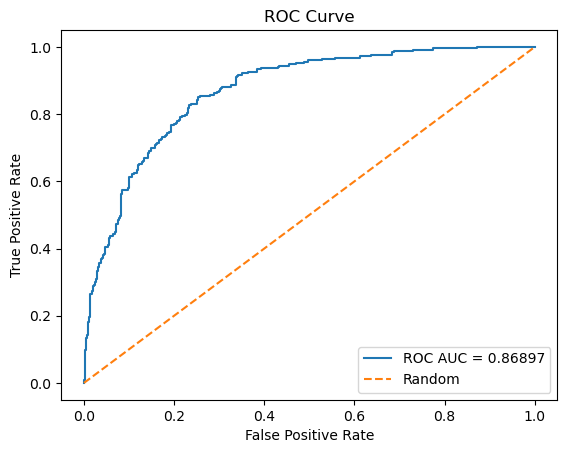

In [29]:
y_pred_probaCatBoost = cat.predict_proba(Xtest)[:, 1]
y_pred_cat_and_randomforest_logreg = (y_pred_probaCatBoost*y_test_predictedRandomForest*y_test_predictedLogReg)**(1/3)
fpr, tpr, thresholds = roc_curve(ytest, y_pred_cat_and_randomforest_logreg)

roc_auc = roc_auc_score(ytest, y_pred_cat_and_randomforest_logreg)

print(f'ROC AUC: {roc_auc:.5f}')

plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Предсказания

In [30]:
best_model = modelR

In [31]:
X_test = pd.read_csv('./test.csv')

X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
X_test = X_test.fillna(X_test.median())
X_test['Sex'] = X_test['Sex'].map({'Male': 0, 'Female': 1})

X_test['HasPartner'] = X_test['HasPartner'].map({'No': 0, 'Yes': 1})
X_test['HasChild'] = X_test['HasChild'].map({'No': 0, 'Yes': 1})
X_test['HasPhoneService'] = X_test['HasPhoneService'].map({'No': 0, 'Yes': 1})
X_test['HasMultiplePhoneNumbers'] = X_test['HasMultiplePhoneNumbers'].map({'No': -1, 'Yes': 1, 'No phone service': 0})

X_test['HasInternetService'] = X_test['HasInternetService'].map({'No': 0, 'Fiber optic': 1, 'DSL': 2})

X_test['HasOnlineSecurityService'] = X_test['HasOnlineSecurityService'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
X_test['HasOnlineBackup'] = X_test['HasOnlineBackup'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
X_test['HasDeviceProtection'] = X_test['HasDeviceProtection'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
X_test['HasTechSupportAccess'] = X_test['HasTechSupportAccess'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
X_test['HasOnlineTV'] = X_test['HasOnlineTV'].map({'No': -1, 'No internet service': 0, 'Yes': 1})
X_test['HasMovieSubscription'] = X_test['HasMovieSubscription'].map({'No': -1, 'No internet service': 0, 'Yes': 1})

X_test['IsBillingPaperless'] = X_test['IsBillingPaperless'].map({'No': 0, 'Yes': 1})

X_test['HasContractPhone'] = X_test['HasContractPhone'].map({'One year': 1, 'Two year': 2, 'Month-to-month': 0})

X_test['PaymentMethod'] = X_test['PaymentMethod'].map({'Electronic check': 1, 'Mailed check': 2, 'Bank transfer (automatic)': 3, 'Credit card (automatic)': 4})


X_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns) 

/var/folders/pl/tf0lv2bx6xg0fp2_nqvpy3mr0000gn/T/ipykernel_19626/1921610215.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_test = X_test.fillna(X_test.median())


In [32]:
submission = pd.read_csv('./submission.csv')
y_pred_probaCatBoost = cat.predict_proba(X_test)[:, 1]
y_test_predictedRandomForest = cat.predict_proba(X_test)[:, 1]
y_test_predictedLogReg = cat.predict_proba(X_test)[:, 1]
norm_pred = (y_pred_probaCatBoost+y_test_predictedRandomForest+y_test_predictedLogReg)/3
norm_pred


array([0.04462332, 0.76187527, 0.67046718, ..., 0.83504381, 0.53918658,
       0.0085686 ])

In [33]:
submission['Churn'] = norm_pred
submission['Churn'] = submission['Churn']
submission.to_csv('./my_submission.csv')

In [34]:
submission.reset_index()

,index,Id,Churn
0,0,0,0.044623
1,1,1,0.761875
2,2,2,0.670467
3,3,3,0.017056
4,4,4,0.002719
...,...,...,...
1756,1756,1756,0.185658
1757,1757,1757,0.012649
1758,1758,1758,0.835044
1759,1759,1759,0.539187
